## Exploring Neural Networks using [Concrete Compressive Strength Set from UCI](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

#### Analysis follows Chapter 7 of *Machine Learning with R* by Brett Lantz (though of course here we use Python, not R)

Objective:  Use a neural network to predict the compressive strength of concrete.

We'll first use the MLPRegressor function provided by scikit-learn, then use Keras to create a customized neural net.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline

from scipy.stats import pearsonr

warnings.filterwarnings("ignore")
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
data = pd.read_excel('Concrete_Data.xls')

In [3]:
data.columns = ['Cement','Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 
                'Fine Aggregate', 'Age', 'Compressive Strength']

In [4]:
data.head(5)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Compressive Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [5]:
data.shape

(1030, 9)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
Blast Furnace Slag,1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
Fly Ash,1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
Water,1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
Superplasticizer,1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
Coarse Aggregate,1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
Fine Aggregate,1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
Compressive Strength,1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225


In [7]:
y = data['Compressive Strength']
X = data.drop(labels = ['Compressive Strength'], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)

Ok, let's start by following the exercise in Lantz:
- scale the data to be in [0, 1]
- train the neural net with only 1 node (otherwise we'll use the default parameters)
- check the correlation between the predictions and the test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
MMS = MinMaxScaler()
MMS.fit(X_train)
X_train = MMS.transform(X_train)
X_test = MMS.transform(X_test)

In [10]:

NN = MLPRegressor(hidden_layer_sizes=(1,))
NN.fit(X_train, y_train)
predictions = NN.predict(X_test)

In [11]:
NN.n_outputs_ 

1

In [12]:
print('correlation =', pearsonr(predictions, y_test)[0])

correlation = 2.45398506533e-16


In [13]:
print('R2 score =',NN.score(X_test, y_test))

R2 score = -4.14523380199


Well, this net doesn't do a very good job.  Let's create a pipeline and try varying the parameters to find one that works:
- different scalers
- different # of nodes/layers
- different activation functions
- different algorithms
- different weights (alpha) for the l2 correction term

We'll use R2 score as the accuracy measure.  Correlation will be used as a sanity check.

In [14]:
#scaler to be used in the grid search
scaler_list = [
    ('mm', MinMaxScaler(), {})
    ,('std', StandardScaler(), {})

]
#parameters for the MLP regressor to be used in the grid search
classifier_list = [
    ('mlp', MLPRegressor(), {'mlp__hidden_layer_sizes': ((10,),(10, 10),(10, 10, 10), (30,),(30, 30),(30, 30, 30),
                                                        (50,),(50, 50),(50, 50, 50),(100,),(100, 100),(100, 100, 100)),        
    'mlp__activation':('logistic','relu','identity','tanh'),
     'mlp__solver':('lbfgs','sgd','adam'),
    'mlp__alpha':(1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0, 1.0e+1, 1.0e+2)})
]
results = {}

#loop over all scalers (2) and classifiers (only 1 here)
for s in scaler_list:
    for c in classifier_list:
        
        pipeline = Pipeline([ (s[0], s[1]), (c[0], c[1]) ])

        parameters = {}
        parameters.update(s[2])
        parameters.update(c[2])
        
        #do a grid search on the current scaler and classifier
        grid_search = GridSearchCV(pipeline, parameters, scoring='r2', verbose=1, n_jobs=4)

        results[(s[0], c[0])] = grid_search.fit(X_train,y_train)


Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=4)]: Done 114 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:   37.5s
[Parallel(n_jobs=4)]: Done 514 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 864 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 1314 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 1864 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 2514 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 3024 out of 3024 | elapsed:  6.4min finished


Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 229 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 479 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 829 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 1279 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 2028 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 2694 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 3024 out of 3024 | elapsed:  7.6min finished


In [15]:
print('Best R2 for MinMax scaling: ', results[('mm', 'mlp')].best_score_)

Best R2 for MinMax scaling:  0.868225619586


In [16]:
print('Best R2 for Z-scaling: ',results[('std', 'mlp')].best_score_)

Best R2 for Z-scaling:  0.885435347836


Much better.  Let's see which parameters give the best test scores.  First, MinMax scaling:

In [17]:
rdf = pd.DataFrame(results[('mm', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
909,0.216059,0.000746,0.868226,0.924569,tanh,1,"(30,)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",1,0.846622,0.935790,0.884451,0.909899,0.873694,0.928018,0.010692,2.153113e-06,0.015925,0.010848
927,0.439975,0.001145,0.867149,0.941156,tanh,1,"(100,)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",2,0.850665,0.943575,0.878899,0.937964,0.871953,0.941928,0.018729,5.734384e-05,0.012019,0.002355
156,0.351239,0.000914,0.866654,0.918872,logistic,1,"(30, 30)",lbfgs,"{'mlp__activation': 'logistic', 'mlp__hidden_l...",3,0.849215,0.927925,0.878386,0.907497,0.872433,0.921194,0.020703,4.989731e-06,0.012593,0.008500
918,0.301846,0.000902,0.865461,0.934838,tanh,1,"(50,)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",4,0.845562,0.935030,0.876022,0.931608,0.874883,0.937875,0.008171,3.532531e-05,0.014108,0.002562
966,1.749896,0.001960,0.862245,0.927694,tanh,10,"(100, 100)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",5,0.832166,0.930358,0.887052,0.928293,0.867641,0.924430,0.025386,6.723094e-05,0.022737,0.002457
126,0.272935,0.000821,0.861707,0.936819,logistic,0.1,"(50,)",lbfgs,"{'mlp__activation': 'logistic', 'mlp__hidden_l...",6,0.839124,0.941984,0.889119,0.927850,0.856971,0.940623,0.017339,4.198740e-05,0.020689,0.006367
930,1.782463,0.002018,0.860595,0.965649,tanh,1,"(100, 100)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",7,0.843269,0.961924,0.879672,0.968469,0.858916,0.966553,0.015793,2.133754e-05,0.014914,0.002747
948,0.413559,0.000980,0.860314,0.917655,tanh,10,"(30, 30)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",8,0.838158,0.922845,0.876521,0.905322,0.866355,0.924800,0.008169,8.199966e-06,0.016238,0.008758
465,2.860426,0.001972,0.858946,0.920369,relu,10,"(100, 100, 100)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",9,0.831031,0.927897,0.891441,0.921174,0.854483,0.912037,0.110876,1.419429e-04,0.024871,0.006500
354,1.609082,0.001332,0.858291,0.912492,relu,0.01,"(100, 100)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",10,0.826342,0.916692,0.888656,0.903738,0.860008,0.917046,0.021128,1.376871e-04,0.025477,0.006192


In [18]:
rdf = pd.DataFrame(results[('std', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
462,1.800037,0.001521,0.885435,0.984882,relu,10,"(100, 100)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",1,0.854599,0.985025,0.901015,0.981371,0.900821,0.988249,0.030740,0.000042,0.021850,0.002810
957,0.746443,0.001332,0.882555,0.985173,tanh,10,"(50, 50)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",2,0.876254,0.983765,0.892608,0.983457,0.878829,0.988298,0.035498,0.000052,0.007178,0.002213
954,0.324406,0.000967,0.880776,0.962555,tanh,10,"(50,)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",3,0.867397,0.967394,0.887352,0.960765,0.887635,0.959504,0.017542,0.000137,0.009480,0.003461
492,1.310196,0.003482,0.880620,0.966628,relu,100,"(50, 50, 50)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",4,0.846177,0.969508,0.891981,0.960974,0.903846,0.969402,0.043393,0.002996,0.024881,0.003998
963,0.501761,0.001679,0.880292,0.967539,tanh,10,"(100,)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",5,0.853495,0.970040,0.900882,0.964965,0.886611,0.967613,0.020084,0.000282,0.019861,0.002073
489,0.524997,0.001058,0.879515,0.940634,relu,100,"(50, 50)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",6,0.859960,0.948764,0.903056,0.938956,0.875610,0.934182,0.012535,0.000009,0.017815,0.006070
501,2.644783,0.002062,0.876931,0.973830,relu,100,"(100, 100, 100)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",7,0.855791,0.976694,0.883020,0.971565,0.892071,0.973230,0.024114,0.000094,0.015428,0.002136
966,1.788515,0.002062,0.875477,0.985851,tanh,10,"(100, 100)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",8,0.868163,0.983790,0.876005,0.983396,0.882292,0.990368,0.032192,0.000020,0.005782,0.003198
162,0.293071,0.000894,0.874987,0.977329,logistic,1,"(50,)",lbfgs,"{'mlp__activation': 'logistic', 'mlp__hidden_l...",9,0.855635,0.975871,0.889143,0.977579,0.880265,0.978536,0.023576,0.000041,0.014183,0.001102
945,0.306940,0.000785,0.874582,0.950432,tanh,10,"(30,)",lbfgs,"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",10,0.851206,0.954688,0.890062,0.945678,0.882575,0.950930,0.018088,0.000009,0.016843,0.003695


The highest scores are for Z-scaled data, the lbfgs algorithm, and the relu function with higher alpha.  Higher alphas seem to require more hidden layers, while lower alphas require fewer.  At the risk of overfitting, let's try to come up with even better values, using alphas between 1 and 100, and varying the number of nodes, keeping only one or 2 hidden layers.

In [19]:
scaler_list = [
    ('std', StandardScaler(), {})
]
classifier_list = [
    ('mlp', MLPRegressor(), {'mlp__hidden_layer_sizes': ((30,),(30, 30), (40,),(40, 40), (50,),(50, 50),
                                                        (60,),(60, 60),(70,),(70, 70),(80,), (80, 80),
                                                        (90,),(90, 90),(100,),(100, 100)),        
    'mlp__activation':('relu',),
    'mlp__solver':('lbfgs',),
    'mlp__alpha':(1, 5, 10, 20, 50, 100)})
]
results = {}

for s in scaler_list:
    for c in classifier_list:
        
        pipeline = Pipeline([ (s[0], s[1]), (c[0], c[1]) ])

        parameters = {}
        parameters.update(s[2])
        parameters.update(c[2])

        grid_search = GridSearchCV(pipeline, parameters, scoring='r2', verbose=1, n_jobs=4)

        results[(s[0], c[0])] = grid_search.fit(X_train,y_train)
    

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done 288 out of 288 | elapsed:   49.6s finished


In [20]:
rdf = pd.DataFrame(results[('std', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
75,1.298333,0.001376,0.883506,0.965308,relu,50,"(80, 80)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",1,0.861470,0.968539,0.900971,0.963030,0.888168,0.964355,0.033649,0.000039,0.016464,0.002348
79,1.578793,0.001624,0.881011,0.968152,relu,50,"(100, 100)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",2,0.850118,0.970891,0.905317,0.968794,0.887727,0.964772,0.014605,0.000139,0.023037,0.002539
55,1.021094,0.001167,0.880882,0.972274,relu,20,"(60, 60)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",3,0.859884,0.974774,0.893197,0.971797,0.889652,0.970250,0.012797,0.000119,0.014949,0.001878
29,2.245170,0.001502,0.879588,0.983839,relu,5,"(90, 90)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",4,0.856273,0.981932,0.892884,0.983897,0.889706,0.985688,0.030146,0.000089,0.016572,0.001534
57,1.139985,0.001399,0.878778,0.974033,relu,20,"(70, 70)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",5,0.842833,0.976703,0.898625,0.970370,0.895025,0.975027,0.012185,0.000086,0.025512,0.002679
51,0.459173,0.001023,0.878410,0.969178,relu,20,"(40, 40)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",6,0.860352,0.972731,0.888986,0.963708,0.885968,0.971096,0.028983,0.000145,0.012855,0.003925
53,0.597208,0.001060,0.876820,0.971292,relu,20,"(50, 50)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",7,0.854298,0.974536,0.883296,0.969203,0.892961,0.970136,0.017699,0.000015,0.016439,0.002325
59,1.302557,0.001389,0.876611,0.977488,relu,20,"(80, 80)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",8,0.841592,0.979026,0.893472,0.976412,0.894915,0.977027,0.022879,0.000079,0.024821,0.001116
91,1.288992,0.001319,0.876168,0.949135,relu,100,"(80, 80)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",9,0.846190,0.951913,0.890661,0.947471,0.891777,0.948022,0.040337,0.000035,0.021246,0.001977
77,1.448630,0.001361,0.875463,0.967037,relu,50,"(90, 90)",lbfgs,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",10,0.845625,0.972325,0.894525,0.965598,0.886363,0.963189,0.018797,0.000153,0.021403,0.003866


The best values are alpha=50 and two hidden layers of 80 nodes each.  Let's see how this looks on the test data:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
ZS = StandardScaler()
ZS.fit(X_train)
X_train = ZS.transform(X_train)
X_test = ZS.transform(X_test)
NN = MLPRegressor(hidden_layer_sizes=(80, 80), solver='lbfgs', alpha=50, activation='relu')
#NN = MLPRegressor(hidden_layer_sizes=(30,30), solver='lbfgs', alpha=10, activation='relu')
NN.fit(X_train, y_train)
predictions = NN.predict(X_test)
print('correlation =', pearsonr(predictions, y_test)[0])
print('R2 score =',NN.score(X_test, y_test))

correlation = 0.95478857865
R2 score = 0.911296627241


This is quite nice.  And visually, the points lie fairly close to the 45 degree line:

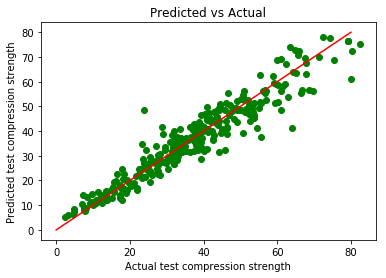

In [22]:
%matplotlib inline 
plt.scatter(y_test, predictions, marker='o', color='g')
plt.plot((0,80),(0,80), color='r')
plt.xlabel('Actual test compression strength')
plt.ylabel('Predicted test compression strength')
plt.title('Predicted vs Actual')
plt.show()

Next, let's try creating a neural net in Keras:

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K

Using TensorFlow backend.


In [24]:
#standard scaler had the best performance above, so let's just stick with that

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
SS = StandardScaler()
SS.fit(X_train)
X_train = SS.transform(X_train)
X_test = SS.transform(X_test)

In [25]:
#customized metric - doesn't already exist ?!?
def r_squared(y_true, y_pred):
    ''' Customized loss function for R^2 
    y_true = Keras tensor of actual values
    y_pred = Keras tensor of predicted values
    
    '''
    mu = K.mean(y_true)
    tss = K.sum(K.square(y_true - mu)) #total sum of squares
    rss = K.sum(K.square(y_true - y_pred)) #residual sum of squares

    return (1 - rss/(K.epsilon() + tss))

#each hidden layer can be a different size
def nn_model(layers, activation, optimizer, input_shape, alpha=1):
    '''Neural net model of only dense layers

    layers: List of integers, the number of hidden units in each layer
    activation:  String, name of activation function used for each layer ('relu', etc.)
    optimizer:  String, name of optimization algorithm ('sgd', etc.)
    input_shape:  Sequence of integers, dimensions of the input layer
    '''

    model = Sequential()
   
    first_layer = True

    for layer in layers:
        #if 1st layer, need to specify input shape
        if first_layer:
            model.add(Dense(layer, input_shape = input_shape, kernel_regularizer=regularizers.l2(alpha)) )
            first_layer = False
        else:
            model.add(Dense(layer, kernel_regularizer=regularizers.l2(alpha)))

        model.add(Activation(activation))

    model.add(Dense(1))
    model.add(Activation('linear'))
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=[r_squared])

    return model

#each hidden layer is the same size
def nn_model_same_size(layer_size, no_layers, activation, optimizer, input_shape, alpha=1):
    '''Neural net model of only dense layers

    layer_size: Integer, the number of hidden units in each layer
    no_layers: Integer, the number of hidden layers
    activation:  String, name of activation function used for each layer ('relu', etc.)
    optimizer:  String, name of optimization algorithm ('sgd', etc.)
    input_shape:  Sequence of integers, dimensions of the input layer
    '''

    model = Sequential()

    for layer in range(no_layers):
        #if 1st layer, need to specify input shape
        if layer:
            model.add(Dense(layer_size, kernel_regularizer=regularizers.l2(alpha)))
        else:
            model.add(Dense(layer_size, input_shape = input_shape, kernel_regularizer=regularizers.l2(alpha)) )
            
        model.add(Activation(activation))

    model.add(Dense(1))
    model.add(Activation('linear'))
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=[r_squared])

    return model

Let's do a sanity check:

In [29]:
myModel = nn_model_same_size(30, 1, 'tanh', 'sgd', (X_train.shape[1],), alpha=0)
myModel.fit(X_train, y_train, epochs=200, batch_size=32)
myModel.evaluate(X_test, y_test)

Epoch 1/200
721/721 [==============================] - 0s 469us/step - loss: 392.8587 - r_squared: -0.4878
Epoch 2/200
721/721 [==============================] - 0s 46us/step - loss: 87.6781 - r_squared: 0.6694
Epoch 3/200
721/721 [==============================] - 0s 46us/step - loss: 71.4892 - r_squared: 0.7193
Epoch 4/200
721/721 [==============================] - 0s 47us/step - loss: 69.5837 - r_squared: 0.7233
Epoch 5/200
721/721 [==============================] - 0s 47us/step - loss: 56.7013 - r_squared: 0.7829
Epoch 6/200
721/721 [==============================] - 0s 47us/step - loss: 52.0278 - r_squared: 0.7949
Epoch 7/200
721/721 [==============================] - 0s 48us/step - loss: 46.7089 - r_squared: 0.8134
Epoch 8/200
721/721 [==============================] - 0s 48us/step - loss: 47.9949 - r_squared: 0.8086
Epoch 9/200
721/721 [==============================] - 0s 50us/step - loss: 46.2182 - r_squared: 0.8129
Epoch 10/200
721/721 [==============================] - 0s 48

721/721 [==============================] - 0s 50us/step - loss: 19.1231 - r_squared: 0.9236
Epoch 79/200
721/721 [==============================] - 0s 48us/step - loss: 19.4044 - r_squared: 0.9240
Epoch 80/200
721/721 [==============================] - 0s 49us/step - loss: 19.9048 - r_squared: 0.9231
Epoch 81/200
721/721 [==============================] - 0s 51us/step - loss: 18.6278 - r_squared: 0.9245
Epoch 82/200
721/721 [==============================] - 0s 50us/step - loss: 19.3057 - r_squared: 0.9185
Epoch 83/200
721/721 [==============================] - 0s 49us/step - loss: 18.5118 - r_squared: 0.9250
Epoch 84/200
721/721 [==============================] - 0s 44us/step - loss: 18.9148 - r_squared: 0.9226
Epoch 85/200
721/721 [==============================] - 0s 51us/step - loss: 18.9486 - r_squared: 0.9232
Epoch 86/200
721/721 [==============================] - 0s 46us/step - loss: 17.8210 - r_squared: 0.9290
Epoch 87/200
721/721 [==============================] - 0s 47us/step

721/721 [==============================] - 0s 45us/step - loss: 15.0167 - r_squared: 0.9402
Epoch 156/200
721/721 [==============================] - 0s 47us/step - loss: 15.1155 - r_squared: 0.9417
Epoch 157/200
721/721 [==============================] - 0s 47us/step - loss: 14.7291 - r_squared: 0.9405
Epoch 158/200
721/721 [==============================] - 0s 46us/step - loss: 15.0739 - r_squared: 0.9404
Epoch 159/200
721/721 [==============================] - 0s 44us/step - loss: 15.1932 - r_squared: 0.9396
Epoch 160/200
721/721 [==============================] - 0s 48us/step - loss: 14.5685 - r_squared: 0.9400
Epoch 161/200
721/721 [==============================] - 0s 47us/step - loss: 14.6583 - r_squared: 0.9419
Epoch 162/200
721/721 [==============================] - 0s 47us/step - loss: 14.8526 - r_squared: 0.9397
Epoch 163/200
721/721 [==============================] - 0s 46us/step - loss: 14.2881 - r_squared: 0.9429
Epoch 164/200
721/721 [==============================] - 0s 

[27.627009215864163, 0.90130647525046637]

Ok, that's pretty close to the above result.  Let's set up a grid search.  First test using the same parameters as above:

In [30]:
#Based on this post on using GridSearchCV with keras:
#    https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
keras_model = KerasRegressor(build_fn=nn_model_same_size, input_shape=(X_train.shape[1],), alpha=0)
layer_list = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
layer_depth = (1, 2)

grid_search = GridSearchCV(keras_model
                         ,param_grid={'layer_size': (30,)
                                      ,'no_layers': (1,)
                                     ,'activation': ('tanh',)
                                     ,'optimizer': ('sgd',)
                                     } 
                        ,scoring='r2'
                        
                        )
result = grid_search.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
480/480 [==============================] - 0s 550us/step - loss: 552.3728 - r_squared: -0.8964
Epoch 2/200
480/480 [==============================] - 0s 46us/step - loss: 102.5515 - r_squared: 0.6267
Epoch 3/200
480/480 [==============================] - 0s 49us/step - loss: 87.8849 - r_squared: 0.6900
Epoch 4/200
480/480 [==============================] - 0s 46us/step - loss: 73.3283 - r_squared: 0.7478
Epoch 5/200
480/480 [==============================] - 0s 48us/step - loss: 60.9911 - r_squared: 0.7804
Epoch 6/200
480/480 [==============================] - 0s 47us/step - loss: 60.8519 - r_squared: 0.7822
Epoch 7/200
480/480 [==============================] - 0s 44us/step - loss: 52.6933 - r_squared: 0.8115
Epoch 8/200
480/480 [==============================] - 0s 44us/step - loss: 47.6928 - r_squared: 0.8351
Epoch 9/200
480/480 [==============================] - 0s 47us/step - loss: 52.7833 - r_squared: 0.8166
Epoch 10/200
480/480 [==============================] - 0s 4

480/480 [==============================] - 0s 47us/step - loss: 17.9369 - r_squared: 0.9320
Epoch 79/200
480/480 [==============================] - 0s 49us/step - loss: 18.6782 - r_squared: 0.9335
Epoch 80/200
480/480 [==============================] - 0s 50us/step - loss: 19.0173 - r_squared: 0.9303
Epoch 81/200
480/480 [==============================] - 0s 60us/step - loss: 17.7003 - r_squared: 0.9371
Epoch 82/200
480/480 [==============================] - 0s 50us/step - loss: 18.5569 - r_squared: 0.9352
Epoch 83/200
480/480 [==============================] - 0s 53us/step - loss: 19.0018 - r_squared: 0.9352
Epoch 84/200
480/480 [==============================] - 0s 48us/step - loss: 17.0704 - r_squared: 0.9373
Epoch 85/200
480/480 [==============================] - 0s 53us/step - loss: 17.6695 - r_squared: 0.9331
Epoch 86/200
480/480 [==============================] - 0s 56us/step - loss: 18.2014 - r_squared: 0.9297
Epoch 87/200
480/480 [==============================] - 0s 53us/step

480/480 [==============================] - 0s 57us/step - loss: 13.6740 - r_squared: 0.9507
Epoch 156/200
480/480 [==============================] - 0s 53us/step - loss: 14.0569 - r_squared: 0.9482
Epoch 157/200
480/480 [==============================] - 0s 49us/step - loss: 13.9610 - r_squared: 0.9508
Epoch 158/200
480/480 [==============================] - 0s 48us/step - loss: 13.3104 - r_squared: 0.9525
Epoch 159/200
480/480 [==============================] - 0s 53us/step - loss: 12.9995 - r_squared: 0.9507
Epoch 160/200
480/480 [==============================] - 0s 47us/step - loss: 13.3482 - r_squared: 0.9518
Epoch 161/200
480/480 [==============================] - 0s 50us/step - loss: 13.6544 - r_squared: 0.9490
Epoch 162/200
480/480 [==============================] - 0s 52us/step - loss: 12.6913 - r_squared: 0.9534
Epoch 163/200
480/480 [==============================] - 0s 53us/step - loss: 13.5285 - r_squared: 0.9513
Epoch 164/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 53us/step - loss: 30.4882 - r_squared: -43095.0723
Epoch 31/200
481/481 [==============================] - 0s 52us/step - loss: 28.9401 - r_squared: -46643.5803
Epoch 32/200
481/481 [==============================] - 0s 58us/step - loss: 30.1120 - r_squared: -831816.3764
Epoch 33/200
481/481 [==============================] - 0s 57us/step - loss: 35.8740 - r_squared: -2575310.9952
Epoch 34/200
481/481 [==============================] - 0s 53us/step - loss: 35.7383 - r_squared: -127018.5765
Epoch 35/200
481/481 [==============================] - 0s 53us/step - loss: 32.1128 - r_squared: -165663.9686
Epoch 36/200
481/481 [==============================] - 0s 51us/step - loss: 28.6741 - r_squared: -1094119.3082
Epoch 37/200
481/481 [==============================] - 0s 53us/step - loss: 40.5974 - r_squared: -448903.4963
Epoch 38/200
481/481 [==============================] - 0s 54us/step - loss: 32.8200 - r_squared: -1675907.1291
Epoch 39/200


481/481 [==============================] - 0s 62us/step - loss: 16.6754 - r_squared: -5630.7677
Epoch 105/200
481/481 [==============================] - 0s 51us/step - loss: 16.5798 - r_squared: -13599.1338
Epoch 106/200
481/481 [==============================] - 0s 53us/step - loss: 16.9576 - r_squared: -1302769.2347
Epoch 107/200
481/481 [==============================] - 0s 51us/step - loss: 26.0542 - r_squared: -309621.4065
Epoch 108/200
481/481 [==============================] - 0s 49us/step - loss: 22.3546 - r_squared: -775951.2621
Epoch 109/200
481/481 [==============================] - 0s 51us/step - loss: 24.6574 - r_squared: -172417.7243
Epoch 110/200
481/481 [==============================] - 0s 55us/step - loss: 18.5768 - r_squared: -10307.1496
Epoch 111/200
481/481 [==============================] - 0s 50us/step - loss: 17.6388 - r_squared: -1659352.2226
Epoch 112/200
481/481 [==============================] - 0s 51us/step - loss: 19.4506 - r_squared: -744645.7384
Epoch 11

481/481 [==============================] - 0s 50us/step - loss: 13.9249 - r_squared: -58999.0440
Epoch 178/200
481/481 [==============================] - 0s 58us/step - loss: 14.5064 - r_squared: -41582.7819
Epoch 179/200
481/481 [==============================] - 0s 52us/step - loss: 14.2632 - r_squared: -464022.1136
Epoch 180/200
481/481 [==============================] - 0s 53us/step - loss: 15.6711 - r_squared: -187507.2754
Epoch 181/200
481/481 [==============================] - 0s 49us/step - loss: 17.6693 - r_squared: -168458.3203
Epoch 182/200
481/481 [==============================] - 0s 48us/step - loss: 16.5737 - r_squared: -501171.0950
Epoch 183/200
481/481 [==============================] - 0s 49us/step - loss: 16.2361 - r_squared: -175015.4026
Epoch 184/200
481/481 [==============================] - 0s 49us/step - loss: 14.4438 - r_squared: -826920.6459
Epoch 185/200
481/481 [==============================] - 0s 52us/step - loss: 25.3310 - r_squared: -443893.7546
Epoch 18

Epoch 51/200
481/481 [==============================] - 0s 74us/step - loss: 31.5932 - r_squared: -955988.2230
Epoch 52/200
481/481 [==============================] - 0s 100us/step - loss: 44.0943 - r_squared: -320216.9677
Epoch 53/200
481/481 [==============================] - 0s 87us/step - loss: 26.5961 - r_squared: -5658.6610
Epoch 54/200
481/481 [==============================] - 0s 72us/step - loss: 24.7780 - r_squared: -23674.3757
Epoch 55/200
481/481 [==============================] - 0s 86us/step - loss: 24.7173 - r_squared: -23374.1301
Epoch 56/200
481/481 [==============================] - 0s 73us/step - loss: 23.9338 - r_squared: -527597.1399
Epoch 57/200
481/481 [==============================] - 0s 81us/step - loss: 27.6493 - r_squared: -67434.5859
Epoch 58/200
481/481 [==============================] - 0s 88us/step - loss: 23.3533 - r_squared: -51407.4198
Epoch 59/200
481/481 [==============================] - 0s 97us/step - loss: 23.0425 - r_squared: -19723.0529
Epoch 6

481/481 [==============================] - 0s 58us/step - loss: 19.3576 - r_squared: -245954.7428
Epoch 125/200
481/481 [==============================] - 0s 61us/step - loss: 19.5166 - r_squared: -73785.9840
Epoch 126/200
481/481 [==============================] - 0s 63us/step - loss: 18.2086 - r_squared: -141665.0702
Epoch 127/200
481/481 [==============================] - 0s 62us/step - loss: 18.7856 - r_squared: -245482.5254
Epoch 128/200
481/481 [==============================] - 0s 68us/step - loss: 20.0606 - r_squared: -71686.6640
Epoch 129/200
481/481 [==============================] - 0s 72us/step - loss: 18.0000 - r_squared: -401036.4800
Epoch 130/200
481/481 [==============================] - 0s 67us/step - loss: 20.7149 - r_squared: -218162.1620
Epoch 131/200
481/481 [==============================] - 0s 73us/step - loss: 19.2655 - r_squared: -1293356.7219
Epoch 132/200
481/481 [==============================] - 0s 67us/step - loss: 33.8859 - r_squared: -1034884.4108
Epoch 

481/481 [==============================] - 0s 62us/step - loss: 15.5628 - r_squared: -15146.8006
Epoch 198/200
481/481 [==============================] - 0s 65us/step - loss: 14.5555 - r_squared: -167788.2688
Epoch 199/200
481/481 [==============================] - 0s 57us/step - loss: 15.1722 - r_squared: -384124.7736
Epoch 200/200
481/481 [==============================] - 0s 56us/step - loss: 16.1983 - r_squared: -316501.3934
Epoch 1/200
721/721 [==============================] - 0s 498us/step - loss: 372.1376 - r_squared: -0.3880
Epoch 2/200
721/721 [==============================] - 0s 54us/step - loss: 89.6589 - r_squared: 0.6558
Epoch 3/200
721/721 [==============================] - 0s 53us/step - loss: 83.0713 - r_squared: 0.6583
Epoch 4/200
721/721 [==============================] - 0s 54us/step - loss: 68.5834 - r_squared: 0.7324
Epoch 5/200
721/721 [==============================] - 0s 53us/step - loss: 57.6692 - r_squared: 0.7701
Epoch 6/200
721/721 [=======================

Epoch 75/200
721/721 [==============================] - 0s 51us/step - loss: 21.1386 - r_squared: 0.9141
Epoch 76/200
721/721 [==============================] - 0s 56us/step - loss: 19.6668 - r_squared: 0.9210
Epoch 77/200
721/721 [==============================] - 0s 55us/step - loss: 20.6258 - r_squared: 0.9210
Epoch 78/200
721/721 [==============================] - 0s 54us/step - loss: 18.7732 - r_squared: 0.9249
Epoch 79/200
721/721 [==============================] - 0s 51us/step - loss: 18.8227 - r_squared: 0.9238
Epoch 80/200
721/721 [==============================] - 0s 57us/step - loss: 19.0644 - r_squared: 0.9226
Epoch 81/200
721/721 [==============================] - 0s 50us/step - loss: 19.5718 - r_squared: 0.9235
Epoch 82/200
721/721 [==============================] - 0s 54us/step - loss: 19.3805 - r_squared: 0.9197
Epoch 83/200
721/721 [==============================] - 0s 54us/step - loss: 18.5016 - r_squared: 0.9272
Epoch 84/200
721/721 [==============================] -

721/721 [==============================] - 0s 49us/step - loss: 15.4327 - r_squared: 0.9384
Epoch 153/200
721/721 [==============================] - 0s 51us/step - loss: 14.8065 - r_squared: 0.9396
Epoch 154/200
721/721 [==============================] - 0s 50us/step - loss: 13.8759 - r_squared: 0.9445
Epoch 155/200
721/721 [==============================] - 0s 54us/step - loss: 14.6446 - r_squared: 0.9394
Epoch 156/200
721/721 [==============================] - 0s 52us/step - loss: 14.3448 - r_squared: 0.9427
Epoch 157/200
721/721 [==============================] - 0s 55us/step - loss: 14.2782 - r_squared: 0.9432
Epoch 158/200
721/721 [==============================] - 0s 52us/step - loss: 14.4648 - r_squared: 0.9418
Epoch 159/200
721/721 [==============================] - 0s 50us/step - loss: 14.9990 - r_squared: 0.9395
Epoch 160/200
721/721 [==============================] - 0s 50us/step - loss: 14.3620 - r_squared: 0.9433
Epoch 161/200
721/721 [==============================] - 0s 

R squared is around 0.94, looks good.  Now, let's vary the parameters:

In [31]:
#Based on this post on using GridSearchCV with keras:
#    https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
keras_model = KerasRegressor(build_fn=nn_model_same_size, input_shape=(X_train.shape[1],), alpha=0)
layer_list = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
layer_depth = (1, 2)

grid_search = GridSearchCV(keras_model
                         ,param_grid={'layer_size': layer_list
                                      ,'no_layers': layer_depth
                                     ,'activation': ('tanh',)
                                     ,'optimizer': ('sgd',)
                                     } 
                        ,scoring='r2'
                        
                        )
result = grid_search.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
480/480 [==============================] - 0s 667us/step - loss: 720.3210 - r_squared: -1.5225
Epoch 2/200
480/480 [==============================] - 0s 44us/step - loss: 155.5374 - r_squared: 0.4650
Epoch 3/200
480/480 [==============================] - 0s 42us/step - loss: 109.4252 - r_squared: 0.6327
Epoch 4/200
480/480 [==============================] - 0s 44us/step - loss: 98.7203 - r_squared: 0.6526
Epoch 5/200
480/480 [==============================] - 0s 48us/step - loss: 88.1203 - r_squared: 0.6899
Epoch 6/200
480/480 [==============================] - 0s 45us/step - loss: 82.9420 - r_squared: 0.6955
Epoch 7/200
480/480 [==============================] - 0s 46us/step - loss: 72.3171 - r_squared: 0.7428
Epoch 8/200
480/480 [==============================] - 0s 47us/step - loss: 76.0741 - r_squared: 0.7301
Epoch 9/200
480/480 [==============================] - 0s 46us/step - loss: 61.6663 - r_squared: 0.7859
Epoch 10/200
480/480 [==============================] - 0s 

480/480 [==============================] - 0s 45us/step - loss: 27.9950 - r_squared: 0.8957
Epoch 79/200
480/480 [==============================] - 0s 54us/step - loss: 26.5337 - r_squared: 0.9080
Epoch 80/200
480/480 [==============================] - 0s 50us/step - loss: 28.6013 - r_squared: 0.8979
Epoch 81/200
480/480 [==============================] - 0s 51us/step - loss: 27.9004 - r_squared: 0.9031
Epoch 82/200
480/480 [==============================] - 0s 47us/step - loss: 26.9051 - r_squared: 0.8960
Epoch 83/200
480/480 [==============================] - 0s 52us/step - loss: 26.8623 - r_squared: 0.9083
Epoch 84/200
480/480 [==============================] - 0s 48us/step - loss: 25.7274 - r_squared: 0.9098
Epoch 85/200
480/480 [==============================] - 0s 46us/step - loss: 25.9621 - r_squared: 0.9081
Epoch 86/200
480/480 [==============================] - 0s 47us/step - loss: 26.6495 - r_squared: 0.9056
Epoch 87/200
480/480 [==============================] - 0s 56us/step

480/480 [==============================] - 0s 46us/step - loss: 25.4321 - r_squared: 0.9087
Epoch 156/200
480/480 [==============================] - 0s 49us/step - loss: 25.2087 - r_squared: 0.9072
Epoch 157/200
480/480 [==============================] - 0s 54us/step - loss: 24.5909 - r_squared: 0.9083
Epoch 158/200
480/480 [==============================] - 0s 57us/step - loss: 24.8895 - r_squared: 0.9104
Epoch 159/200
480/480 [==============================] - 0s 57us/step - loss: 24.0748 - r_squared: 0.9119
Epoch 160/200
480/480 [==============================] - 0s 48us/step - loss: 25.0151 - r_squared: 0.9092
Epoch 161/200
480/480 [==============================] - 0s 50us/step - loss: 24.8521 - r_squared: 0.9117
Epoch 162/200
480/480 [==============================] - 0s 49us/step - loss: 24.8842 - r_squared: 0.9123
Epoch 163/200
480/480 [==============================] - 0s 47us/step - loss: 23.9886 - r_squared: 0.9179
Epoch 164/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 51us/step - loss: 49.4274 - r_squared: -80728.6136
Epoch 31/200
481/481 [==============================] - 0s 51us/step - loss: 48.2501 - r_squared: -1091189.4909
Epoch 32/200
481/481 [==============================] - 0s 51us/step - loss: 61.1285 - r_squared: -289445.1125
Epoch 33/200
481/481 [==============================] - 0s 51us/step - loss: 52.1933 - r_squared: -358927.0929
Epoch 34/200
481/481 [==============================] - 0s 52us/step - loss: 45.6965 - r_squared: -651.6520
Epoch 35/200
481/481 [==============================] - 0s 51us/step - loss: 42.9131 - r_squared: -1858131.0073
Epoch 36/200
481/481 [==============================] - 0s 53us/step - loss: 44.4153 - r_squared: -429696.0473
Epoch 37/200
481/481 [==============================] - 0s 52us/step - loss: 40.8275 - r_squared: -85.7316
Epoch 38/200
481/481 [==============================] - 0s 48us/step - loss: 40.1541 - r_squared: -17496.5419
Epoch 39/200
481/481 

481/481 [==============================] - 0s 49us/step - loss: 45.0579 - r_squared: -124291.9248
Epoch 105/200
481/481 [==============================] - 0s 54us/step - loss: 44.0462 - r_squared: -47756.8314
Epoch 106/200
481/481 [==============================] - 0s 50us/step - loss: 43.5888 - r_squared: -906380.6194
Epoch 107/200
481/481 [==============================] - 0s 48us/step - loss: 49.5275 - r_squared: -454861.5822
Epoch 108/200
481/481 [==============================] - 0s 53us/step - loss: 45.5740 - r_squared: -686396.6721
Epoch 109/200
481/481 [==============================] - 0s 50us/step - loss: 42.9140 - r_squared: -97.7655
Epoch 110/200
481/481 [==============================] - 0s 52us/step - loss: 41.7589 - r_squared: -9753.4643
Epoch 111/200
481/481 [==============================] - 0s 53us/step - loss: 42.0778 - r_squared: -329879.9670
Epoch 112/200
481/481 [==============================] - 0s 53us/step - loss: 50.2702 - r_squared: -4813255.8521
Epoch 113/20

481/481 [==============================] - 0s 51us/step - loss: 42.0017 - r_squared: -459415.6628
Epoch 178/200
481/481 [==============================] - 0s 50us/step - loss: 43.8659 - r_squared: -83136.7443
Epoch 179/200
481/481 [==============================] - 0s 51us/step - loss: 41.4094 - r_squared: -12119.7520
Epoch 180/200
481/481 [==============================] - 0s 49us/step - loss: 39.6059 - r_squared: -1112365.6099
Epoch 181/200
481/481 [==============================] - 0s 50us/step - loss: 39.0265 - r_squared: -39263.3227
Epoch 182/200
481/481 [==============================] - 0s 49us/step - loss: 38.5266 - r_squared: -1939213.4016
Epoch 183/200
481/481 [==============================] - 0s 55us/step - loss: 50.8128 - r_squared: -101888.7519
Epoch 184/200
481/481 [==============================] - 0s 50us/step - loss: 40.0839 - r_squared: -138326.9346
Epoch 185/200
481/481 [==============================] - 0s 52us/step - loss: 38.5050 - r_squared: -6444.1018
Epoch 186

481/481 [==============================] - 0s 49us/step - loss: 40.9013 - r_squared: -470956.4381
Epoch 51/200
481/481 [==============================] - 0s 53us/step - loss: 64.8817 - r_squared: -420197.7855
Epoch 52/200
481/481 [==============================] - 0s 55us/step - loss: 47.9563 - r_squared: -37590.3747
Epoch 53/200
481/481 [==============================] - 0s 52us/step - loss: 41.3368 - r_squared: -149415.6133
Epoch 54/200
481/481 [==============================] - 0s 51us/step - loss: 43.3840 - r_squared: -758018.7054
Epoch 55/200
481/481 [==============================] - 0s 49us/step - loss: 42.6261 - r_squared: -871012.1674
Epoch 56/200
481/481 [==============================] - 0s 51us/step - loss: 38.3166 - r_squared: -776869.2089
Epoch 57/200
481/481 [==============================] - 0s 51us/step - loss: 40.3760 - r_squared: -68045.5890
Epoch 58/200
481/481 [==============================] - 0s 51us/step - loss: 37.9441 - r_squared: -179822.5284
Epoch 59/200
481

481/481 [==============================] - 0s 52us/step - loss: 52.0995 - r_squared: -93876.1306
Epoch 124/200
481/481 [==============================] - 0s 50us/step - loss: 49.7510 - r_squared: -2167572.6204
Epoch 125/200
481/481 [==============================] - 0s 54us/step - loss: 47.1370 - r_squared: -2327136.5893
Epoch 126/200
481/481 [==============================] - 0s 51us/step - loss: 45.9917 - r_squared: -167549.7677
Epoch 127/200
481/481 [==============================] - 0s 51us/step - loss: 45.8134 - r_squared: -56884.9700
Epoch 128/200
481/481 [==============================] - 0s 54us/step - loss: 43.6530 - r_squared: -737617.2015
Epoch 129/200
481/481 [==============================] - 0s 50us/step - loss: 45.2254 - r_squared: -1405582.6229
Epoch 130/200
481/481 [==============================] - 0s 52us/step - loss: 49.0437 - r_squared: -45863.5714
Epoch 131/200
481/481 [==============================] - 0s 54us/step - loss: 43.9421 - r_squared: -467696.4522
Epoch 

481/481 [==============================] - 0s 48us/step - loss: 39.4093 - r_squared: -321297.5603
Epoch 197/200
481/481 [==============================] - 0s 54us/step - loss: 43.6902 - r_squared: -395.7351
Epoch 198/200
481/481 [==============================] - 0s 51us/step - loss: 39.0152 - r_squared: -638141.6318
Epoch 199/200
481/481 [==============================] - 0s 49us/step - loss: 43.4999 - r_squared: -534082.0702
Epoch 200/200
481/481 [==============================] - 0s 50us/step - loss: 48.4349 - r_squared: -277348.6039
Epoch 1/200
480/480 [==============================] - 0s 853us/step - loss: 698.7053 - r_squared: -1.4616
Epoch 2/200
480/480 [==============================] - 0s 60us/step - loss: 172.3486 - r_squared: 0.4235
Epoch 3/200
480/480 [==============================] - 0s 55us/step - loss: 157.5215 - r_squared: 0.4666
Epoch 4/200
480/480 [==============================] - 0s 57us/step - loss: 110.4259 - r_squared: 0.6183
Epoch 5/200
480/480 [==============

480/480 [==============================] - 0s 57us/step - loss: 24.9809 - r_squared: 0.9127
Epoch 74/200
480/480 [==============================] - 0s 56us/step - loss: 28.2052 - r_squared: 0.8981
Epoch 75/200
480/480 [==============================] - 0s 61us/step - loss: 26.0757 - r_squared: 0.9052
Epoch 76/200
480/480 [==============================] - 0s 53us/step - loss: 24.0856 - r_squared: 0.9123
Epoch 77/200
480/480 [==============================] - 0s 54us/step - loss: 25.9752 - r_squared: 0.9036
Epoch 78/200
480/480 [==============================] - 0s 54us/step - loss: 24.2680 - r_squared: 0.9142
Epoch 79/200
480/480 [==============================] - 0s 52us/step - loss: 27.7149 - r_squared: 0.8972
Epoch 80/200
480/480 [==============================] - 0s 52us/step - loss: 26.5922 - r_squared: 0.9041
Epoch 81/200
480/480 [==============================] - 0s 53us/step - loss: 24.8601 - r_squared: 0.9075
Epoch 82/200
480/480 [==============================] - 0s 51us/step

480/480 [==============================] - 0s 50us/step - loss: 23.7211 - r_squared: 0.9149
Epoch 151/200
480/480 [==============================] - 0s 51us/step - loss: 21.6370 - r_squared: 0.9221
Epoch 152/200
480/480 [==============================] - 0s 55us/step - loss: 21.6924 - r_squared: 0.9133
Epoch 153/200
480/480 [==============================] - 0s 51us/step - loss: 22.8381 - r_squared: 0.9161
Epoch 154/200
480/480 [==============================] - 0s 52us/step - loss: 21.6700 - r_squared: 0.9233
Epoch 155/200
480/480 [==============================] - 0s 52us/step - loss: 21.5781 - r_squared: 0.9261
Epoch 156/200
480/480 [==============================] - 0s 50us/step - loss: 21.7652 - r_squared: 0.9240
Epoch 157/200
480/480 [==============================] - 0s 51us/step - loss: 19.9148 - r_squared: 0.9245
Epoch 158/200
480/480 [==============================] - 0s 54us/step - loss: 23.8827 - r_squared: 0.9139
Epoch 159/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 56us/step - loss: 60.2101 - r_squared: -2689226.5623
Epoch 27/200
481/481 [==============================] - 0s 57us/step - loss: 56.0193 - r_squared: -77.9510
Epoch 28/200
481/481 [==============================] - 0s 59us/step - loss: 48.7125 - r_squared: -90087.8995
Epoch 29/200
481/481 [==============================] - 0s 57us/step - loss: 55.7038 - r_squared: -545614.7057
Epoch 30/200
481/481 [==============================] - 0s 57us/step - loss: 48.3742 - r_squared: -3116464.4439
Epoch 31/200
481/481 [==============================] - 0s 57us/step - loss: 92.6216 - r_squared: -740.7602
Epoch 32/200
481/481 [==============================] - 0s 52us/step - loss: 56.3302 - r_squared: -2012637.1772
Epoch 33/200
481/481 [==============================] - 0s 59us/step - loss: 81.2111 - r_squared: -1164004.1932
Epoch 34/200
481/481 [==============================] - 0s 58us/step - loss: 58.9520 - r_squared: -2854100.1364
Epoch 35/200
481/

481/481 [==============================] - 0s 57us/step - loss: 39.5430 - r_squared: -2838.9664
Epoch 101/200
481/481 [==============================] - 0s 59us/step - loss: 38.0643 - r_squared: -160.3788
Epoch 102/200
481/481 [==============================] - 0s 55us/step - loss: 36.3480 - r_squared: -791716.1445
Epoch 103/200
481/481 [==============================] - 0s 61us/step - loss: 36.8112 - r_squared: -1560549.6129
Epoch 104/200
481/481 [==============================] - 0s 57us/step - loss: 39.5973 - r_squared: -192307.6610
Epoch 105/200
481/481 [==============================] - 0s 61us/step - loss: 39.2227 - r_squared: -1411556.9563
Epoch 106/200
481/481 [==============================] - 0s 54us/step - loss: 37.5354 - r_squared: -72309.9556
Epoch 107/200
481/481 [==============================] - 0s 58us/step - loss: 34.2131 - r_squared: -558779.9553
Epoch 108/200
481/481 [==============================] - 0s 58us/step - loss: 37.4893 - r_squared: -76223.5980
Epoch 109/2

481/481 [==============================] - 0s 55us/step - loss: 31.3846 - r_squared: -6450.6990
Epoch 174/200
481/481 [==============================] - 0s 57us/step - loss: 28.7537 - r_squared: -233795.5155
Epoch 175/200
481/481 [==============================] - 0s 58us/step - loss: 28.1778 - r_squared: -11500.1671
Epoch 176/200
481/481 [==============================] - 0s 56us/step - loss: 27.2694 - r_squared: -188569.8944
Epoch 177/200
481/481 [==============================] - 0s 56us/step - loss: 30.2119 - r_squared: -481893.2132
Epoch 178/200
481/481 [==============================] - 0s 57us/step - loss: 31.4680 - r_squared: -7284.0518
Epoch 179/200
481/481 [==============================] - 0s 56us/step - loss: 28.4484 - r_squared: -664080.5560
Epoch 180/200
481/481 [==============================] - ETA: 0s - loss: 47.1779 - r_squared: 0.83 - 0s 57us/step - loss: 33.6506 - r_squared: -56649.0258
Epoch 181/200
481/481 [==============================] - 0s 54us/step - loss: 28

481/481 [==============================] - 0s 60us/step - loss: 62.5610 - r_squared: -9155.3200
Epoch 47/200
481/481 [==============================] - 0s 58us/step - loss: 55.6277 - r_squared: -500160.9212
Epoch 48/200
481/481 [==============================] - 0s 64us/step - loss: 77.2724 - r_squared: -828698.2634
Epoch 49/200
481/481 [==============================] - 0s 58us/step - loss: 70.0273 - r_squared: -1069100.3203
Epoch 50/200
481/481 [==============================] - 0s 58us/step - loss: 61.5428 - r_squared: -314.9252
Epoch 51/200
481/481 [==============================] - 0s 55us/step - loss: 55.8136 - r_squared: -2444320.7482
Epoch 52/200
481/481 [==============================] - 0s 55us/step - loss: 55.9495 - r_squared: -549707.5468
Epoch 53/200
481/481 [==============================] - 0s 55us/step - loss: 61.9283 - r_squared: -1253688.3313
Epoch 54/200
481/481 [==============================] - 0s 58us/step - loss: 68.4159 - r_squared: -42542.0714
Epoch 55/200
481/

Epoch 119/200
481/481 [==============================] - 0s 56us/step - loss: 87.5267 - r_squared: -2313960.2049
Epoch 120/200
481/481 [==============================] - 0s 56us/step - loss: 71.8766 - r_squared: -84388.0817
Epoch 121/200
481/481 [==============================] - 0s 56us/step - loss: 56.4088 - r_squared: -1105859.8936
Epoch 122/200
481/481 [==============================] - 0s 54us/step - loss: 49.9344 - r_squared: -467882.8773
Epoch 123/200
481/481 [==============================] - 0s 58us/step - loss: 60.5813 - r_squared: -3619948.0883
Epoch 124/200
481/481 [==============================] - 0s 64us/step - loss: 53.4152 - r_squared: -196394.7088
Epoch 125/200
481/481 [==============================] - 0s 55us/step - loss: 72.9446 - r_squared: -218241.2481
Epoch 126/200
481/481 [==============================] - 0s 55us/step - loss: 52.2323 - r_squared: -667897.5575
Epoch 127/200
481/481 [==============================] - 0s 55us/step - loss: 52.6360 - r_squared: -31

Epoch 191/200
481/481 [==============================] - 0s 54us/step - loss: 50.3209 - r_squared: -312789.9046
Epoch 192/200
481/481 [==============================] - 0s 56us/step - loss: 51.5761 - r_squared: -1383258.4883
Epoch 193/200
481/481 [==============================] - 0s 58us/step - loss: 50.9245 - r_squared: -14934.3221
Epoch 194/200
481/481 [==============================] - 0s 56us/step - loss: 47.7501 - r_squared: -820066.9240
Epoch 195/200
481/481 [==============================] - 0s 55us/step - loss: 51.7119 - r_squared: -31695.1054
Epoch 196/200
481/481 [==============================] - 0s 58us/step - loss: 46.6303 - r_squared: -43447.4334
Epoch 197/200
481/481 [==============================] - 0s 59us/step - loss: 44.8866 - r_squared: -2569.4746
Epoch 198/200
481/481 [==============================] - 0s 59us/step - loss: 39.7716 - r_squared: -777.9285
Epoch 199/200
481/481 [==============================] - 0s 58us/step - loss: 43.8869 - r_squared: -390631.3310

480/480 [==============================] - 0s 52us/step - loss: 21.6302 - r_squared: 0.9243
Epoch 69/200
480/480 [==============================] - 0s 52us/step - loss: 22.4691 - r_squared: 0.9193
Epoch 70/200
480/480 [==============================] - 0s 53us/step - loss: 21.4420 - r_squared: 0.9203
Epoch 71/200
480/480 [==============================] - 0s 53us/step - loss: 20.7781 - r_squared: 0.9202
Epoch 72/200
480/480 [==============================] - 0s 50us/step - loss: 22.1656 - r_squared: 0.9202
Epoch 73/200
480/480 [==============================] - 0s 53us/step - loss: 20.6269 - r_squared: 0.9272
Epoch 74/200
480/480 [==============================] - 0s 48us/step - loss: 21.0184 - r_squared: 0.9261
Epoch 75/200
480/480 [==============================] - 0s 51us/step - loss: 21.3206 - r_squared: 0.9216
Epoch 76/200
480/480 [==============================] - 0s 49us/step - loss: 20.8377 - r_squared: 0.9222
Epoch 77/200
480/480 [==============================] - 0s 53us/step

480/480 [==============================] - 0s 53us/step - loss: 18.1540 - r_squared: 0.9359
Epoch 146/200
480/480 [==============================] - 0s 53us/step - loss: 17.4698 - r_squared: 0.9378
Epoch 147/200
480/480 [==============================] - 0s 47us/step - loss: 16.6786 - r_squared: 0.9382
Epoch 148/200
480/480 [==============================] - 0s 52us/step - loss: 17.5841 - r_squared: 0.9347
Epoch 149/200
480/480 [==============================] - 0s 48us/step - loss: 17.0852 - r_squared: 0.9349
Epoch 150/200
480/480 [==============================] - 0s 49us/step - loss: 17.6497 - r_squared: 0.9385
Epoch 151/200
480/480 [==============================] - 0s 51us/step - loss: 17.4700 - r_squared: 0.9365
Epoch 152/200
480/480 [==============================] - 0s 49us/step - loss: 17.0108 - r_squared: 0.9367
Epoch 153/200
480/480 [==============================] - 0s 49us/step - loss: 17.6458 - r_squared: 0.9376
Epoch 154/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 49us/step - loss: 43.9805 - r_squared: -260.8801
Epoch 22/200
481/481 [==============================] - 0s 48us/step - loss: 38.3964 - r_squared: -1515141.0186
Epoch 23/200
481/481 [==============================] - 0s 48us/step - loss: 48.2243 - r_squared: -744307.6975
Epoch 24/200
481/481 [==============================] - 0s 50us/step - loss: 45.5354 - r_squared: -35714.2267
Epoch 25/200
481/481 [==============================] - 0s 49us/step - loss: 34.9356 - r_squared: -82530.3272
Epoch 26/200
481/481 [==============================] - 0s 53us/step - loss: 33.6002 - r_squared: -163596.4779
Epoch 27/200
481/481 [==============================] - 0s 50us/step - loss: 31.8708 - r_squared: -706491.2795
Epoch 28/200
481/481 [==============================] - 0s 47us/step - loss: 42.9760 - r_squared: -195675.2886
Epoch 29/200
481/481 [==============================] - 0s 49us/step - loss: 35.8045 - r_squared: -1119.4321
Epoch 30/200
481/481

481/481 [==============================] - 0s 51us/step - loss: 21.0896 - r_squared: -143476.9292
Epoch 96/200
481/481 [==============================] - 0s 49us/step - loss: 21.4457 - r_squared: -1932060.2322
Epoch 97/200
481/481 [==============================] - 0s 53us/step - loss: 63.7086 - r_squared: -1544190.0794
Epoch 98/200
481/481 [==============================] - 0s 51us/step - loss: 28.6347 - r_squared: -905881.0679
Epoch 99/200
481/481 [==============================] - 0s 51us/step - loss: 30.0349 - r_squared: -14937.7394
Epoch 100/200
481/481 [==============================] - 0s 49us/step - loss: 22.8920 - r_squared: -344773.8532
Epoch 101/200
481/481 [==============================] - 0s 48us/step - loss: 23.8196 - r_squared: -959947.2104
Epoch 102/200
481/481 [==============================] - 0s 52us/step - loss: 23.4627 - r_squared: -6143.8245
Epoch 103/200
481/481 [==============================] - 0s 50us/step - loss: 20.9503 - r_squared: -592.8084
Epoch 104/200


481/481 [==============================] - 0s 49us/step - loss: 28.9426 - r_squared: -2535668.4792
Epoch 169/200
481/481 [==============================] - 0s 49us/step - loss: 33.8867 - r_squared: -466621.7815
Epoch 170/200
481/481 [==============================] - 0s 53us/step - loss: 30.5339 - r_squared: -685872.4283
Epoch 171/200
481/481 [==============================] - 0s 51us/step - loss: 27.7053 - r_squared: -1198649.2684
Epoch 172/200
481/481 [==============================] - 0s 52us/step - loss: 27.1665 - r_squared: -1321373.4523
Epoch 173/200
481/481 [==============================] - 0s 54us/step - loss: 49.5256 - r_squared: -354874.9693
Epoch 174/200
481/481 [==============================] - 0s 52us/step - loss: 29.5871 - r_squared: -918008.6111
Epoch 175/200
481/481 [==============================] - 0s 53us/step - loss: 27.8009 - r_squared: -899192.6031
Epoch 176/200
481/481 [==============================] - 0s 50us/step - loss: 25.6365 - r_squared: 0.3751
Epoch 177

481/481 [==============================] - 0s 49us/step - loss: 27.5358 - r_squared: -2040497.9413
Epoch 42/200
481/481 [==============================] - 0s 52us/step - loss: 47.4947 - r_squared: -3336480.9927
Epoch 43/200
481/481 [==============================] - 0s 54us/step - loss: 37.9203 - r_squared: -20516.7788
Epoch 44/200
481/481 [==============================] - 0s 53us/step - loss: 31.2256 - r_squared: -1772.8796
Epoch 45/200
481/481 [==============================] - 0s 54us/step - loss: 29.7978 - r_squared: -380587.6645
Epoch 46/200
481/481 [==============================] - 0s 52us/step - loss: 29.7821 - r_squared: -2536369.1529
Epoch 47/200
481/481 [==============================] - 0s 50us/step - loss: 37.8337 - r_squared: -143530.7314
Epoch 48/200
481/481 [==============================] - 0s 51us/step - loss: 27.1884 - r_squared: -955416.0708
Epoch 49/200
481/481 [==============================] - 0s 54us/step - loss: 34.6479 - r_squared: -1540502.6934
Epoch 50/200


481/481 [==============================] - 0s 56us/step - loss: 23.7518 - r_squared: -318418.4920
Epoch 116/200
481/481 [==============================] - 0s 54us/step - loss: 25.1729 - r_squared: -16053.5336
Epoch 117/200
481/481 [==============================] - 0s 49us/step - loss: 22.4380 - r_squared: -439337.6037
Epoch 118/200
481/481 [==============================] - 0s 50us/step - loss: 24.8763 - r_squared: -2394131.5997
Epoch 119/200
481/481 [==============================] - 0s 53us/step - loss: 30.3046 - r_squared: -101.9152
Epoch 120/200
481/481 [==============================] - 0s 49us/step - loss: 23.4701 - r_squared: -195160.1953
Epoch 121/200
481/481 [==============================] - 0s 47us/step - loss: 24.1370 - r_squared: -560089.7823
Epoch 122/200
481/481 [==============================] - 0s 55us/step - loss: 25.7481 - r_squared: -1348999.0955
Epoch 123/200
481/481 [==============================] - 0s 56us/step - loss: 24.4774 - r_squared: -65632.6022
Epoch 124

481/481 [==============================] - 0s 51us/step - loss: 31.6475 - r_squared: -247685.9187
Epoch 189/200
481/481 [==============================] - 0s 52us/step - loss: 29.1979 - r_squared: -19180.7961
Epoch 190/200
481/481 [==============================] - 0s 51us/step - loss: 27.4010 - r_squared: -49631.7907
Epoch 191/200
481/481 [==============================] - 0s 50us/step - loss: 26.1177 - r_squared: -1080.3004
Epoch 192/200
481/481 [==============================] - 0s 50us/step - loss: 24.6653 - r_squared: -348647.8518
Epoch 193/200
481/481 [==============================] - 0s 50us/step - loss: 22.5287 - r_squared: -122994.0705
Epoch 194/200
481/481 [==============================] - 0s 50us/step - loss: 21.1230 - r_squared: -3182.6180
Epoch 195/200
481/481 [==============================] - 0s 48us/step - loss: 19.8344 - r_squared: -49293.0370
Epoch 196/200
481/481 [==============================] - 0s 50us/step - loss: 19.9050 - r_squared: -5579.8791
Epoch 197/200
4

480/480 [==============================] - 0s 53us/step - loss: 15.6614 - r_squared: 0.9443
Epoch 66/200
480/480 [==============================] - 0s 52us/step - loss: 13.7880 - r_squared: 0.9480
Epoch 67/200
480/480 [==============================] - 0s 53us/step - loss: 12.9455 - r_squared: 0.9537
Epoch 68/200
480/480 [==============================] - 0s 55us/step - loss: 12.1242 - r_squared: 0.9572
Epoch 69/200
480/480 [==============================] - 0s 57us/step - loss: 13.9242 - r_squared: 0.9488
Epoch 70/200
480/480 [==============================] - 0s 53us/step - loss: 15.7044 - r_squared: 0.9439
Epoch 71/200
480/480 [==============================] - 0s 54us/step - loss: 14.0796 - r_squared: 0.9479
Epoch 72/200
480/480 [==============================] - 0s 51us/step - loss: 12.3631 - r_squared: 0.9573
Epoch 73/200
480/480 [==============================] - 0s 54us/step - loss: 14.4484 - r_squared: 0.9449
Epoch 74/200
480/480 [==============================] - 0s 55us/step

480/480 [==============================] - 0s 57us/step - loss: 8.6252 - r_squared: 0.9690
Epoch 142/200
480/480 [==============================] - 0s 52us/step - loss: 8.9697 - r_squared: 0.9659
Epoch 143/200
480/480 [==============================] - 0s 55us/step - loss: 9.0722 - r_squared: 0.9666
Epoch 144/200
480/480 [==============================] - 0s 54us/step - loss: 12.9610 - r_squared: 0.9519
Epoch 145/200
480/480 [==============================] - 0s 53us/step - loss: 10.1797 - r_squared: 0.9614
Epoch 146/200
480/480 [==============================] - 0s 56us/step - loss: 8.4315 - r_squared: 0.9700
Epoch 147/200
480/480 [==============================] - 0s 55us/step - loss: 8.9536 - r_squared: 0.9689
Epoch 148/200
480/480 [==============================] - 0s 57us/step - loss: 9.7674 - r_squared: 0.9643
Epoch 149/200
480/480 [==============================] - 0s 56us/step - loss: 8.6250 - r_squared: 0.9696
Epoch 150/200
480/480 [==============================] - 0s 56us/st

481/481 [==============================] - 0s 59us/step - loss: 66.8650 - r_squared: -144827.4480
Epoch 19/200
481/481 [==============================] - 0s 60us/step - loss: 45.3280 - r_squared: -72662.9593
Epoch 20/200
481/481 [==============================] - 0s 55us/step - loss: 41.2657 - r_squared: -1670381.2114
Epoch 21/200
481/481 [==============================] - 0s 56us/step - loss: 68.5006 - r_squared: -2470982.0618
Epoch 22/200
481/481 [==============================] - 0s 58us/step - loss: 43.5605 - r_squared: -476283.5256
Epoch 23/200
481/481 [==============================] - 0s 57us/step - loss: 49.9379 - r_squared: -1984.7076
Epoch 24/200
481/481 [==============================] - 0s 53us/step - loss: 35.3216 - r_squared: -498636.9944
Epoch 25/200
481/481 [==============================] - 0s 62us/step - loss: 54.3222 - r_squared: -776984.7357
Epoch 26/200
481/481 [==============================] - 0s 58us/step - loss: 40.9373 - r_squared: -660336.7426
Epoch 27/200
48

481/481 [==============================] - 0s 56us/step - loss: 57.1031 - r_squared: -1874.3341
Epoch 92/200
481/481 [==============================] - 0s 58us/step - loss: 33.5202 - r_squared: -46327.7367
Epoch 93/200
481/481 [==============================] - 0s 57us/step - loss: 32.9177 - r_squared: -139996.9136
Epoch 94/200
481/481 [==============================] - 0s 60us/step - loss: 32.7458 - r_squared: -50174.7917
Epoch 95/200
481/481 [==============================] - 0s 59us/step - loss: 31.6431 - r_squared: -6117.1786
Epoch 96/200
481/481 [==============================] - 0s 58us/step - loss: 25.6528 - r_squared: -21835.8366
Epoch 97/200
481/481 [==============================] - 0s 53us/step - loss: 25.6684 - r_squared: -603017.6226
Epoch 98/200
481/481 [==============================] - 0s 58us/step - loss: 27.9692 - r_squared: -12885.6317
Epoch 99/200
481/481 [==============================] - 0s 61us/step - loss: 25.4283 - r_squared: -195864.0595
Epoch 100/200
481/481 

Epoch 164/200
481/481 [==============================] - 0s 54us/step - loss: 27.2653 - r_squared: -315047.5030
Epoch 165/200
481/481 [==============================] - 0s 57us/step - loss: 23.7395 - r_squared: -2672463.4664
Epoch 166/200
481/481 [==============================] - 0s 53us/step - loss: 36.5660 - r_squared: -107204.0963
Epoch 167/200
481/481 [==============================] - 0s 55us/step - loss: 24.7582 - r_squared: -12193.8512
Epoch 168/200
481/481 [==============================] - 0s 62us/step - loss: 19.4904 - r_squared: -140998.0051
Epoch 169/200
481/481 [==============================] - 0s 58us/step - loss: 20.9031 - r_squared: -777503.3613
Epoch 170/200
481/481 [==============================] - 0s 60us/step - loss: 17.2181 - r_squared: -14264.9601
Epoch 171/200
481/481 [==============================] - 0s 60us/step - loss: 16.7941 - r_squared: -94763.8380
Epoch 172/200
481/481 [==============================] - 0s 60us/step - loss: 17.1874 - r_squared: -114.65

481/481 [==============================] - 0s 56us/step - loss: 25.6638 - r_squared: -169128.8355
Epoch 38/200
481/481 [==============================] - 0s 64us/step - loss: 28.4816 - r_squared: -1122316.2907
Epoch 39/200
481/481 [==============================] - 0s 57us/step - loss: 25.8234 - r_squared: -79949.9374
Epoch 40/200
481/481 [==============================] - 0s 59us/step - loss: 27.6894 - r_squared: -1742727.7657
Epoch 41/200
481/481 [==============================] - 0s 55us/step - loss: 25.4094 - r_squared: -96787.7974
Epoch 42/200
481/481 [==============================] - 0s 54us/step - loss: 25.1226 - r_squared: -918470.8886
Epoch 43/200
481/481 [==============================] - 0s 59us/step - loss: 37.2559 - r_squared: -460066.0467
Epoch 44/200
481/481 [==============================] - 0s 59us/step - loss: 42.0335 - r_squared: -535521.2684
Epoch 45/200
481/481 [==============================] - 0s 58us/step - loss: 31.5797 - r_squared: -1397284.5171
Epoch 46/200


481/481 [==============================] - 0s 55us/step - loss: 29.3358 - r_squared: -1760179.6822
Epoch 111/200
481/481 [==============================] - 0s 57us/step - loss: 47.5633 - r_squared: -35388.1549
Epoch 112/200
481/481 [==============================] - 0s 55us/step - loss: 30.5031 - r_squared: -1926720.9979
Epoch 113/200
481/481 [==============================] - 0s 53us/step - loss: 57.5907 - r_squared: -577682.3178
Epoch 114/200
481/481 [==============================] - 0s 55us/step - loss: 37.9735 - r_squared: -200855.4276
Epoch 115/200
481/481 [==============================] - 0s 55us/step - loss: 30.3687 - r_squared: -55743.2009
Epoch 116/200
481/481 [==============================] - 0s 55us/step - loss: 27.0075 - r_squared: -6917.3217
Epoch 117/200
481/481 [==============================] - 0s 55us/step - loss: 26.3230 - r_squared: -151392.1076
Epoch 118/200
481/481 [==============================] - 0s 58us/step - loss: 25.7616 - r_squared: -279985.5022
Epoch 11

481/481 [==============================] - 0s 57us/step - loss: 37.3227 - r_squared: -887407.3976
Epoch 184/200
481/481 [==============================] - 0s 56us/step - loss: 32.0518 - r_squared: -116977.4897
Epoch 185/200
481/481 [==============================] - 0s 61us/step - loss: 23.5772 - r_squared: -150480.9271
Epoch 186/200
481/481 [==============================] - 0s 57us/step - loss: 22.4682 - r_squared: -1484759.0463
Epoch 187/200
481/481 [==============================] - 0s 56us/step - loss: 62.5090 - r_squared: -1748255.8599
Epoch 188/200
481/481 [==============================] - 0s 58us/step - loss: 86.9918 - r_squared: -938112.6917
Epoch 189/200
481/481 [==============================] - 0s 57us/step - loss: 67.4386 - r_squared: -2228256.4113
Epoch 190/200
481/481 [==============================] - 0s 58us/step - loss: 53.8142 - r_squared: -76588.8554
Epoch 191/200
481/481 [==============================] - 0s 59us/step - loss: 36.2468 - r_squared: -462264.5903
Epoc

480/480 [==============================] - 0s 50us/step - loss: 20.4190 - r_squared: 0.9265
Epoch 60/200
480/480 [==============================] - 0s 50us/step - loss: 21.1397 - r_squared: 0.9249
Epoch 61/200
480/480 [==============================] - 0s 49us/step - loss: 21.1086 - r_squared: 0.9204
Epoch 62/200
480/480 [==============================] - 0s 50us/step - loss: 20.3524 - r_squared: 0.9275
Epoch 63/200
480/480 [==============================] - 0s 52us/step - loss: 20.5231 - r_squared: 0.9258
Epoch 64/200
480/480 [==============================] - 0s 50us/step - loss: 21.5641 - r_squared: 0.9221
Epoch 65/200
480/480 [==============================] - 0s 47us/step - loss: 20.0327 - r_squared: 0.9304
Epoch 66/200
480/480 [==============================] - 0s 49us/step - loss: 20.0197 - r_squared: 0.9304
Epoch 67/200
480/480 [==============================] - 0s 49us/step - loss: 19.9453 - r_squared: 0.9297
Epoch 68/200
480/480 [==============================] - 0s 51us/step

480/480 [==============================] - 0s 49us/step - loss: 15.0616 - r_squared: 0.9470
Epoch 137/200
480/480 [==============================] - 0s 52us/step - loss: 15.6251 - r_squared: 0.9429
Epoch 138/200
480/480 [==============================] - 0s 50us/step - loss: 15.7537 - r_squared: 0.9405
Epoch 139/200
480/480 [==============================] - 0s 53us/step - loss: 15.3036 - r_squared: 0.9442
Epoch 140/200
480/480 [==============================] - 0s 51us/step - loss: 15.3361 - r_squared: 0.9439
Epoch 141/200
480/480 [==============================] - 0s 50us/step - loss: 15.5904 - r_squared: 0.9433
Epoch 142/200
480/480 [==============================] - 0s 51us/step - loss: 14.6441 - r_squared: 0.9475
Epoch 143/200
480/480 [==============================] - 0s 51us/step - loss: 15.6633 - r_squared: 0.9420
Epoch 144/200
480/480 [==============================] - 0s 54us/step - loss: 14.3105 - r_squared: 0.9488
Epoch 145/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 52us/step - loss: 45.8601 - r_squared: -587844.5858
Epoch 13/200
481/481 [==============================] - 0s 50us/step - loss: 50.7197 - r_squared: -310547.7104
Epoch 14/200
481/481 [==============================] - 0s 50us/step - loss: 42.4799 - r_squared: -1033456.4104
Epoch 15/200
481/481 [==============================] - 0s 52us/step - loss: 41.8487 - r_squared: -1430283.8177
Epoch 16/200
481/481 [==============================] - 0s 50us/step - loss: 58.8594 - r_squared: -135316.5434
Epoch 17/200
481/481 [==============================] - 0s 50us/step - loss: 40.6146 - r_squared: -56122.6412
Epoch 18/200
481/481 [==============================] - 0s 52us/step - loss: 38.2850 - r_squared: -60755.4020
Epoch 19/200
481/481 [==============================] - 0s 52us/step - loss: 35.2762 - r_squared: -1143571.5053
Epoch 20/200
481/481 [==============================] - 0s 50us/step - loss: 60.9320 - r_squared: -77117.0912
Epoch 21/200
4

481/481 [==============================] - 0s 50us/step - loss: 23.2000 - r_squared: -194265.1062
Epoch 87/200
481/481 [==============================] - 0s 51us/step - loss: 23.1597 - r_squared: -2244530.4561
Epoch 88/200
481/481 [==============================] - 0s 51us/step - loss: 28.4144 - r_squared: -414297.3660
Epoch 89/200
481/481 [==============================] - 0s 51us/step - loss: 23.6195 - r_squared: -147565.6385
Epoch 90/200
481/481 [==============================] - 0s 51us/step - loss: 21.9278 - r_squared: -646968.4393
Epoch 91/200
481/481 [==============================] - 0s 51us/step - loss: 27.3946 - r_squared: -24858.1068
Epoch 92/200
481/481 [==============================] - 0s 54us/step - loss: 20.2736 - r_squared: -409.4809
Epoch 93/200
481/481 [==============================] - 0s 49us/step - loss: 20.2906 - r_squared: -1420805.6050
Epoch 94/200
481/481 [==============================] - 0s 51us/step - loss: 29.0606 - r_squared: -750922.0364
Epoch 95/200
481

481/481 [==============================] - 0s 53us/step - loss: 17.9646 - r_squared: -46000.9068
Epoch 160/200
481/481 [==============================] - 0s 51us/step - loss: 17.0155 - r_squared: -42375.1456
Epoch 161/200
481/481 [==============================] - 0s 51us/step - loss: 16.8112 - r_squared: -11526.3232
Epoch 162/200
481/481 [==============================] - 0s 50us/step - loss: 16.1738 - r_squared: -15080.3329
Epoch 163/200
481/481 [==============================] - 0s 52us/step - loss: 15.7088 - r_squared: -125602.4182
Epoch 164/200
481/481 [==============================] - 0s 51us/step - loss: 15.8315 - r_squared: -72408.6324
Epoch 165/200
481/481 [==============================] - 0s 52us/step - loss: 15.2492 - r_squared: -252645.1445
Epoch 166/200
481/481 [==============================] - 0s 62us/step - loss: 16.2823 - r_squared: -54.5048
Epoch 167/200
481/481 [==============================] - 0s 57us/step - loss: 14.9462 - r_squared: -131048.1814
Epoch 168/200
4

481/481 [==============================] - 0s 53us/step - loss: 31.0351 - r_squared: -124958.5641
Epoch 34/200
481/481 [==============================] - 0s 50us/step - loss: 30.0530 - r_squared: -3016.8177
Epoch 35/200
481/481 [==============================] - 0s 56us/step - loss: 28.6092 - r_squared: -627659.0277
Epoch 36/200
481/481 [==============================] - 0s 51us/step - loss: 30.7004 - r_squared: -1179412.4176
Epoch 37/200
481/481 [==============================] - 0s 53us/step - loss: 46.5452 - r_squared: -2122741.7560
Epoch 38/200
481/481 [==============================] - 0s 49us/step - loss: 50.1965 - r_squared: -11401.8407
Epoch 39/200
481/481 [==============================] - 0s 51us/step - loss: 32.3978 - r_squared: -62802.1669
Epoch 40/200
481/481 [==============================] - 0s 52us/step - loss: 30.4519 - r_squared: -18128.1668
Epoch 41/200
481/481 [==============================] - 0s 48us/step - loss: 27.5960 - r_squared: -547899.1000
Epoch 42/200
481/

481/481 [==============================] - 0s 53us/step - loss: 26.7585 - r_squared: -350228.6982
Epoch 108/200
481/481 [==============================] - 0s 51us/step - loss: 26.6128 - r_squared: -58932.1159
Epoch 109/200
481/481 [==============================] - 0s 52us/step - loss: 24.6243 - r_squared: -54072.2149
Epoch 110/200
481/481 [==============================] - 0s 51us/step - loss: 23.4562 - r_squared: -1743.3194
Epoch 111/200
481/481 [==============================] - 0s 54us/step - loss: 22.8578 - r_squared: -1068.2952
Epoch 112/200
481/481 [==============================] - 0s 51us/step - loss: 22.8151 - r_squared: -30208.9893
Epoch 113/200
481/481 [==============================] - 0s 51us/step - loss: 22.8663 - r_squared: -26783.9380
Epoch 114/200
481/481 [==============================] - 0s 51us/step - loss: 21.5067 - r_squared: -40701.6671
Epoch 115/200
481/481 [==============================] - 0s 53us/step - loss: 21.9925 - r_squared: -254936.9892
Epoch 116/200
4

481/481 [==============================] - 0s 55us/step - loss: 23.3433 - r_squared: -19000.6551
Epoch 181/200
481/481 [==============================] - 0s 54us/step - loss: 17.2172 - r_squared: -170.9864
Epoch 182/200
481/481 [==============================] - 0s 53us/step - loss: 16.6117 - r_squared: -1615022.3081
Epoch 183/200
481/481 [==============================] - 0s 51us/step - loss: 21.5029 - r_squared: -665628.5002
Epoch 184/200
481/481 [==============================] - 0s 51us/step - loss: 26.7464 - r_squared: -72596.3157
Epoch 185/200
481/481 [==============================] - 0s 51us/step - loss: 17.0774 - r_squared: -99420.8206
Epoch 186/200
481/481 [==============================] - 0s 50us/step - loss: 15.8609 - r_squared: -25565.5971
Epoch 187/200
481/481 [==============================] - 0s 55us/step - loss: 16.1266 - r_squared: -79778.9130
Epoch 188/200
481/481 [==============================] - 0s 52us/step - loss: 14.7237 - r_squared: -20906.3019
Epoch 189/200


Epoch 57/200
480/480 [==============================] - 0s 55us/step - loss: 12.8271 - r_squared: 0.9518
Epoch 58/200
480/480 [==============================] - 0s 58us/step - loss: 12.6981 - r_squared: 0.9546
Epoch 59/200
480/480 [==============================] - 0s 53us/step - loss: 11.5313 - r_squared: 0.9571
Epoch 60/200
480/480 [==============================] - 0s 54us/step - loss: 17.5532 - r_squared: 0.9408
Epoch 61/200
480/480 [==============================] - 0s 55us/step - loss: 12.3400 - r_squared: 0.9557
Epoch 62/200
480/480 [==============================] - 0s 54us/step - loss: 12.6922 - r_squared: 0.9542
Epoch 63/200
480/480 [==============================] - 0s 54us/step - loss: 12.1249 - r_squared: 0.9563
Epoch 64/200
480/480 [==============================] - 0s 57us/step - loss: 11.0587 - r_squared: 0.9603
Epoch 65/200
480/480 [==============================] - 0s 54us/step - loss: 10.7389 - r_squared: 0.9610
Epoch 66/200
480/480 [==============================] -

480/480 [==============================] - 0s 59us/step - loss: 8.0992 - r_squared: 0.9694
Epoch 135/200
480/480 [==============================] - 0s 54us/step - loss: 8.0852 - r_squared: 0.9704
Epoch 136/200
480/480 [==============================] - 0s 56us/step - loss: 6.5377 - r_squared: 0.9761
Epoch 137/200
480/480 [==============================] - 0s 55us/step - loss: 7.2918 - r_squared: 0.9720
Epoch 138/200
480/480 [==============================] - 0s 56us/step - loss: 6.7816 - r_squared: 0.9756
Epoch 139/200
480/480 [==============================] - 0s 56us/step - loss: 6.9032 - r_squared: 0.9749
Epoch 140/200
480/480 [==============================] - 0s 54us/step - loss: 7.3847 - r_squared: 0.9715
Epoch 141/200
480/480 [==============================] - 0s 54us/step - loss: 7.2545 - r_squared: 0.9755
Epoch 142/200
480/480 [==============================] - 0s 52us/step - loss: 6.9381 - r_squared: 0.9743
Epoch 143/200
480/480 [==============================] - 0s 54us/step

481/481 [==============================] - 0s 60us/step - loss: 65.1658 - r_squared: -2384371.5788
Epoch 12/200
481/481 [==============================] - 0s 64us/step - loss: 114.3045 - r_squared: -699.5494
Epoch 13/200
481/481 [==============================] - 0s 61us/step - loss: 56.2003 - r_squared: -270658.1787
Epoch 14/200
481/481 [==============================] - 0s 61us/step - loss: 59.2531 - r_squared: -5400845.6324
Epoch 15/200
481/481 [==============================] - 0s 62us/step - loss: 237.7678 - r_squared: -404513.1909
Epoch 16/200
481/481 [==============================] - 0s 60us/step - loss: 75.0137 - r_squared: -563824.8681
Epoch 17/200
481/481 [==============================] - 0s 61us/step - loss: 60.9381 - r_squared: -222393.8842
Epoch 18/200
481/481 [==============================] - 0s 61us/step - loss: 55.9392 - r_squared: -1977584.0597
Epoch 19/200
481/481 [==============================] - 0s 61us/step - loss: 49.1047 - r_squared: -1349530.0831
Epoch 20/20

481/481 [==============================] - 0s 62us/step - loss: 15.2998 - r_squared: -33884.1577
Epoch 85/200
481/481 [==============================] - 0s 63us/step - loss: 14.4639 - r_squared: -507389.6670
Epoch 86/200
481/481 [==============================] - 0s 62us/step - loss: 20.7190 - r_squared: -718008.3728
Epoch 87/200
481/481 [==============================] - 0s 63us/step - loss: 33.3435 - r_squared: -6357333.8888
Epoch 88/200
481/481 [==============================] - 0s 69us/step - loss: 84.1606 - r_squared: -3055.2996
Epoch 89/200
481/481 [==============================] - 0s 73us/step - loss: 32.3756 - r_squared: -248565.6814
Epoch 90/200
481/481 [==============================] - 0s 64us/step - loss: 29.2385 - r_squared: -275494.8847
Epoch 91/200
481/481 [==============================] - 0s 64us/step - loss: 33.6368 - r_squared: -85366.7106
Epoch 92/200
481/481 [==============================] - ETA: 0s - loss: 25.4680 - r_squared: 0.85 - 0s 65us/step - loss: 24.6074

481/481 [==============================] - 0s 57us/step - loss: 9.1942 - r_squared: -63634.6168
Epoch 158/200
481/481 [==============================] - 0s 58us/step - loss: 7.7195 - r_squared: -406280.0158
Epoch 159/200
481/481 [==============================] - 0s 55us/step - loss: 10.1304 - r_squared: -6709.1704
Epoch 160/200
481/481 [==============================] - 0s 63us/step - loss: 7.5568 - r_squared: -28531.9364
Epoch 161/200
481/481 [==============================] - 0s 62us/step - loss: 8.0149 - r_squared: -39882.8901
Epoch 162/200
481/481 [==============================] - 0s 63us/step - loss: 7.1410 - r_squared: -588787.0567
Epoch 163/200
481/481 [==============================] - 0s 62us/step - loss: 18.4698 - r_squared: -206837.2188
Epoch 164/200
481/481 [==============================] - 0s 61us/step - loss: 19.5918 - r_squared: -395067.4331
Epoch 165/200
481/481 [==============================] - 0s 61us/step - loss: 28.3564 - r_squared: -205947.8143
Epoch 166/200
48

481/481 [==============================] - 0s 57us/step - loss: 29.0408 - r_squared: -134234.2894
Epoch 32/200
481/481 [==============================] - 0s 56us/step - loss: 34.1736 - r_squared: -3657851.6803
Epoch 33/200
481/481 [==============================] - 0s 56us/step - loss: 90.1518 - r_squared: -3437.8186
Epoch 34/200
481/481 [==============================] - 0s 58us/step - loss: 51.4584 - r_squared: -24649.7208
Epoch 35/200
481/481 [==============================] - 0s 61us/step - loss: 39.0250 - r_squared: -1992710.4792
Epoch 36/200
481/481 [==============================] - 0s 57us/step - loss: 74.1698 - r_squared: -103303.5573
Epoch 37/200
481/481 [==============================] - 0s 61us/step - loss: 49.2585 - r_squared: -63706.6701
Epoch 38/200
481/481 [==============================] - 0s 57us/step - loss: 42.0897 - r_squared: -53407.4549
Epoch 39/200
481/481 [==============================] - 0s 57us/step - loss: 34.6376 - r_squared: -126289.9890
Epoch 40/200
481/

481/481 [==============================] - 0s 61us/step - loss: 30.2778 - r_squared: -94922.1022
Epoch 105/200
481/481 [==============================] - 0s 57us/step - loss: 25.2759 - r_squared: -186392.4021
Epoch 106/200
481/481 [==============================] - 0s 55us/step - loss: 26.8415 - r_squared: -235987.2938
Epoch 107/200
481/481 [==============================] - 0s 57us/step - loss: 30.9117 - r_squared: -636176.4238
Epoch 108/200
481/481 [==============================] - 0s 55us/step - loss: 28.7523 - r_squared: -199761.5185
Epoch 109/200
481/481 [==============================] - 0s 55us/step - loss: 24.0455 - r_squared: -31554.1728
Epoch 110/200
481/481 [==============================] - 0s 58us/step - loss: 22.4376 - r_squared: -4147.1115
Epoch 111/200
481/481 [==============================] - ETA: 0s - loss: 14.5048 - r_squared: 0.93 - 0s 55us/step - loss: 20.9557 - r_squared: -22086.8107
Epoch 112/200
481/481 [==============================] - 0s 61us/step - loss: 2

481/481 [==============================] - 0s 53us/step - loss: 27.1836 - r_squared: -331016.8974
Epoch 178/200
481/481 [==============================] - 0s 55us/step - loss: 24.9088 - r_squared: -62833.2947
Epoch 179/200
481/481 [==============================] - 0s 67us/step - loss: 21.9760 - r_squared: -42324.7941
Epoch 180/200
481/481 [==============================] - 0s 61us/step - loss: 20.5295 - r_squared: -2512.7772
Epoch 181/200
481/481 [==============================] - 0s 58us/step - loss: 18.7013 - r_squared: -69769.5846
Epoch 182/200
481/481 [==============================] - 0s 60us/step - loss: 17.2897 - r_squared: -394086.5343
Epoch 183/200
481/481 [==============================] - 0s 62us/step - loss: 19.9007 - r_squared: -434500.6711
Epoch 184/200
481/481 [==============================] - 0s 70us/step - loss: 16.8725 - r_squared: -34244.5479
Epoch 185/200
481/481 [==============================] - 0s 62us/step - loss: 15.9653 - r_squared: -185074.5179
Epoch 186/20

480/480 [==============================] - 0s 53us/step - loss: 21.0663 - r_squared: 0.9229
Epoch 54/200
480/480 [==============================] - 0s 55us/step - loss: 22.3979 - r_squared: 0.9181
Epoch 55/200
480/480 [==============================] - 0s 53us/step - loss: 20.9944 - r_squared: 0.9235
Epoch 56/200
480/480 [==============================] - 0s 50us/step - loss: 20.3390 - r_squared: 0.9294
Epoch 57/200
480/480 [==============================] - 0s 51us/step - loss: 22.0737 - r_squared: 0.9176
Epoch 58/200
480/480 [==============================] - 0s 50us/step - loss: 20.3552 - r_squared: 0.9288
Epoch 59/200
480/480 [==============================] - 0s 50us/step - loss: 21.3847 - r_squared: 0.9248
Epoch 60/200
480/480 [==============================] - 0s 48us/step - loss: 21.1715 - r_squared: 0.9234
Epoch 61/200
480/480 [==============================] - 0s 51us/step - loss: 19.7321 - r_squared: 0.9304
Epoch 62/200
480/480 [==============================] - 0s 47us/step

480/480 [==============================] - 0s 53us/step - loss: 13.2448 - r_squared: 0.9528
Epoch 131/200
480/480 [==============================] - 0s 55us/step - loss: 13.3458 - r_squared: 0.9524
Epoch 132/200
480/480 [==============================] - 0s 56us/step - loss: 13.5390 - r_squared: 0.9527
Epoch 133/200
480/480 [==============================] - 0s 52us/step - loss: 13.3414 - r_squared: 0.9512
Epoch 134/200
480/480 [==============================] - 0s 49us/step - loss: 14.9708 - r_squared: 0.9442
Epoch 135/200
480/480 [==============================] - 0s 50us/step - loss: 13.2138 - r_squared: 0.9527
Epoch 136/200
480/480 [==============================] - 0s 52us/step - loss: 13.2041 - r_squared: 0.9517
Epoch 137/200
480/480 [==============================] - 0s 49us/step - loss: 13.1301 - r_squared: 0.9533
Epoch 138/200
480/480 [==============================] - 0s 49us/step - loss: 13.9508 - r_squared: 0.9461
Epoch 139/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 52us/step - loss: 72.8878 - r_squared: -4216.2275
Epoch 7/200
481/481 [==============================] - 0s 51us/step - loss: 60.9712 - r_squared: -886748.5335
Epoch 8/200
481/481 [==============================] - 0s 54us/step - loss: 64.6052 - r_squared: -1136351.8710
Epoch 9/200
481/481 [==============================] - 0s 60us/step - loss: 60.8441 - r_squared: -116080.0082
Epoch 10/200
481/481 [==============================] - 0s 57us/step - loss: 50.5633 - r_squared: -1153280.8061
Epoch 11/200
481/481 [==============================] - 0s 51us/step - loss: 54.6260 - r_squared: -2332850.8527
Epoch 12/200
481/481 [==============================] - 0s 55us/step - loss: 69.1117 - r_squared: -4154092.4101
Epoch 13/200
481/481 [==============================] - 0s 50us/step - loss: 96.2949 - r_squared: -3348685.3869
Epoch 14/200
481/481 [==============================] - 0s 52us/step - loss: 79.8514 - r_squared: -6279870.3817
Epoch 15/200


481/481 [==============================] - 0s 57us/step - loss: 18.2594 - r_squared: -8831.3791
Epoch 81/200
481/481 [==============================] - 0s 58us/step - loss: 17.5149 - r_squared: -442051.6685
Epoch 82/200
481/481 [==============================] - 0s 56us/step - loss: 20.3158 - r_squared: -121250.4917
Epoch 83/200
481/481 [==============================] - 0s 61us/step - loss: 17.9430 - r_squared: -159254.4951
Epoch 84/200
481/481 [==============================] - 0s 55us/step - loss: 18.1826 - r_squared: -1156881.9756
Epoch 85/200
481/481 [==============================] - 0s 55us/step - loss: 25.2468 - r_squared: -57200.7012
Epoch 86/200
481/481 [==============================] - 0s 57us/step - loss: 18.9337 - r_squared: -77576.1378
Epoch 87/200
481/481 [==============================] - 0s 59us/step - loss: 18.1039 - r_squared: -16909.9313
Epoch 88/200
481/481 [==============================] - 0s 59us/step - loss: 17.1468 - r_squared: -251559.3737
Epoch 89/200
481/4

481/481 [==============================] - 0s 56us/step - loss: 13.9833 - r_squared: -22242.5156
Epoch 154/200
481/481 [==============================] - 0s 54us/step - loss: 14.4355 - r_squared: -955.1254
Epoch 155/200
481/481 [==============================] - 0s 56us/step - loss: 13.5299 - r_squared: -27461.8417
Epoch 156/200
481/481 [==============================] - 0s 54us/step - loss: 13.6385 - r_squared: -42220.2659
Epoch 157/200
481/481 [==============================] - 0s 56us/step - loss: 13.3303 - r_squared: -33510.3601
Epoch 158/200
481/481 [==============================] - 0s 53us/step - loss: 13.9456 - r_squared: -88813.6562
Epoch 159/200
481/481 [==============================] - 0s 54us/step - loss: 13.6615 - r_squared: -647643.6649
Epoch 160/200
481/481 [==============================] - 0s 59us/step - loss: 17.5565 - r_squared: -160943.1558
Epoch 161/200
481/481 [==============================] - 0s 57us/step - loss: 14.5764 - r_squared: -32966.0494
Epoch 162/200
4

Epoch 27/200
481/481 [==============================] - 0s 52us/step - loss: 37.3857 - r_squared: -235458.4526
Epoch 28/200
481/481 [==============================] - 0s 53us/step - loss: 35.4759 - r_squared: -149677.4418
Epoch 29/200
481/481 [==============================] - 0s 56us/step - loss: 30.1093 - r_squared: -183754.0848
Epoch 30/200
481/481 [==============================] - 0s 50us/step - loss: 32.8532 - r_squared: -24244.8421
Epoch 31/200
481/481 [==============================] - 0s 51us/step - loss: 30.6409 - r_squared: -16475.2073
Epoch 32/200
481/481 [==============================] - 0s 57us/step - loss: 30.9544 - r_squared: -7829.1515
Epoch 33/200
481/481 [==============================] - 0s 51us/step - loss: 31.3513 - r_squared: -48522.1235
Epoch 34/200
481/481 [==============================] - 0s 51us/step - loss: 28.1435 - r_squared: -4153.2645
Epoch 35/200
481/481 [==============================] - 0s 51us/step - loss: 28.8601 - r_squared: -36641.9059
Epoch 36/

481/481 [==============================] - 0s 58us/step - loss: 16.8811 - r_squared: -7696.4455
Epoch 102/200
481/481 [==============================] - 0s 60us/step - loss: 15.5365 - r_squared: -181.2853
Epoch 103/200
481/481 [==============================] - 0s 54us/step - loss: 16.8792 - r_squared: -2527018.7146
Epoch 104/200
481/481 [==============================] - 0s 58us/step - loss: 46.7466 - r_squared: -1435316.8279
Epoch 105/200
481/481 [==============================] - 0s 54us/step - loss: 66.3863 - r_squared: -121646.0008
Epoch 106/200
481/481 [==============================] - 0s 55us/step - loss: 29.7232 - r_squared: -115960.1691
Epoch 107/200
481/481 [==============================] - 0s 57us/step - loss: 26.0717 - r_squared: -3589883.9122
Epoch 108/200
481/481 [==============================] - 0s 53us/step - loss: 34.5781 - r_squared: -6533.4957
Epoch 109/200
481/481 [==============================] - 0s 54us/step - loss: 23.7886 - r_squared: -98099.0371
Epoch 110/2

481/481 [==============================] - 0s 53us/step - loss: 12.2274 - r_squared: -49868.1323
Epoch 175/200
481/481 [==============================] - 0s 52us/step - loss: 12.5785 - r_squared: -7666.8766
Epoch 176/200
481/481 [==============================] - 0s 55us/step - loss: 11.7821 - r_squared: -91224.4831
Epoch 177/200
481/481 [==============================] - 0s 52us/step - loss: 13.6888 - r_squared: -295211.7997
Epoch 178/200
481/481 [==============================] - 0s 60us/step - loss: 14.3705 - r_squared: -507059.4882
Epoch 179/200
481/481 [==============================] - 0s 51us/step - loss: 32.7665 - r_squared: -108057.9531
Epoch 180/200
481/481 [==============================] - 0s 49us/step - loss: 13.9514 - r_squared: -59663.9763
Epoch 181/200
481/481 [==============================] - 0s 53us/step - loss: 12.8161 - r_squared: -653976.5336
Epoch 182/200
481/481 [==============================] - 0s 52us/step - loss: 13.3196 - r_squared: -23598.2253
Epoch 183/20

480/480 [==============================] - 0s 52us/step - loss: 13.8458 - r_squared: 0.9510
Epoch 51/200
480/480 [==============================] - ETA: 0s - loss: 10.4184 - r_squared: 0.96 - 0s 58us/step - loss: 11.6787 - r_squared: 0.9560
Epoch 52/200
480/480 [==============================] - 0s 53us/step - loss: 11.9036 - r_squared: 0.9555
Epoch 53/200
480/480 [==============================] - 0s 58us/step - loss: 13.1161 - r_squared: 0.9527
Epoch 54/200
480/480 [==============================] - 0s 52us/step - loss: 12.8578 - r_squared: 0.9498
Epoch 55/200
480/480 [==============================] - 0s 58us/step - loss: 11.6498 - r_squared: 0.9575
Epoch 56/200
480/480 [==============================] - 0s 56us/step - loss: 12.5121 - r_squared: 0.9548
Epoch 57/200
480/480 [==============================] - 0s 57us/step - loss: 11.5738 - r_squared: 0.9591
Epoch 58/200
480/480 [==============================] - 0s 54us/step - loss: 10.8706 - r_squared: 0.9617
Epoch 59/200
480/480 [==

480/480 [==============================] - 0s 55us/step - loss: 7.1440 - r_squared: 0.9773
Epoch 129/200
480/480 [==============================] - 0s 54us/step - loss: 6.8854 - r_squared: 0.9757
Epoch 130/200
480/480 [==============================] - 0s 57us/step - loss: 6.7407 - r_squared: 0.9741
Epoch 131/200
480/480 [==============================] - 0s 57us/step - loss: 7.3116 - r_squared: 0.9754
Epoch 132/200
480/480 [==============================] - 0s 58us/step - loss: 6.9526 - r_squared: 0.9753
Epoch 133/200
480/480 [==============================] - 0s 57us/step - loss: 6.3310 - r_squared: 0.9775
Epoch 134/200
480/480 [==============================] - 0s 54us/step - loss: 7.8010 - r_squared: 0.9707
Epoch 135/200
480/480 [==============================] - 0s 57us/step - loss: 6.4901 - r_squared: 0.9775
Epoch 136/200
480/480 [==============================] - ETA: 0s - loss: 4.3803 - r_squared: 0.986 - 0s 59us/step - loss: 6.1301 - r_squared: 0.9757
Epoch 137/200
480/480 [==

481/481 [==============================] - 0s 59us/step - loss: 73.9321 - r_squared: -1545740.6191
Epoch 5/200
481/481 [==============================] - 0s 58us/step - loss: 145.0102 - r_squared: -1216395.3320
Epoch 6/200
481/481 [==============================] - 0s 58us/step - loss: 92.9255 - r_squared: -649858.6468
Epoch 7/200
481/481 [==============================] - 0s 56us/step - loss: 76.5893 - r_squared: -2099937.9108
Epoch 8/200
481/481 [==============================] - 0s 58us/step - loss: 103.1998 - r_squared: -3875907.0391
Epoch 9/200
481/481 [==============================] - 0s 59us/step - loss: 90.0644 - r_squared: -99355.0630
Epoch 10/200
481/481 [==============================] - 0s 61us/step - loss: 52.7438 - r_squared: -120919.3137
Epoch 11/200
481/481 [==============================] - 0s 60us/step - loss: 50.3980 - r_squared: -2790.3942
Epoch 12/200
481/481 [==============================] - 0s 62us/step - loss: 45.6875 - r_squared: -1329088.2645
Epoch 13/200
48

481/481 [==============================] - 0s 57us/step - loss: 62.0622 - r_squared: -625334.4077
Epoch 79/200
481/481 [==============================] - 0s 58us/step - loss: 52.5948 - r_squared: -753924.3417
Epoch 80/200
481/481 [==============================] - 0s 63us/step - loss: 49.5421 - r_squared: -5477.8382
Epoch 81/200
481/481 [==============================] - 0s 62us/step - loss: 30.1687 - r_squared: -800706.5219
Epoch 82/200
481/481 [==============================] - 0s 62us/step - loss: 35.8755 - r_squared: -268397.3455
Epoch 83/200
481/481 [==============================] - 0s 62us/step - loss: 29.4768 - r_squared: -33675.1527
Epoch 84/200
481/481 [==============================] - 0s 63us/step - loss: 25.8583 - r_squared: -2500953.0663
Epoch 85/200
481/481 [==============================] - 0s 61us/step - loss: 45.0280 - r_squared: -2786897.9598
Epoch 86/200
481/481 [==============================] - 0s 64us/step - loss: 44.5451 - r_squared: -64254.5487
Epoch 87/200
481

481/481 [==============================] - 0s 62us/step - loss: 18.4740 - r_squared: -68123.4431
Epoch 152/200
481/481 [==============================] - 0s 63us/step - loss: 16.1888 - r_squared: -17254.9224
Epoch 153/200
481/481 [==============================] - 0s 63us/step - loss: 13.3704 - r_squared: -1533615.2242
Epoch 154/200
481/481 [==============================] - 0s 62us/step - loss: 16.2098 - r_squared: -35108.1832
Epoch 155/200
481/481 [==============================] - 0s 60us/step - loss: 13.7924 - r_squared: -185022.7935
Epoch 156/200
481/481 [==============================] - 0s 63us/step - loss: 16.7952 - r_squared: -723790.3744
Epoch 157/200
481/481 [==============================] - 0s 59us/step - loss: 14.0342 - r_squared: -48485.7065
Epoch 158/200
481/481 [==============================] - 0s 63us/step - loss: 12.7177 - r_squared: -94628.7462
Epoch 159/200
481/481 [==============================] - 0s 62us/step - loss: 11.4979 - r_squared: -519625.8269
Epoch 160/

481/481 [==============================] - 0s 60us/step - loss: 44.5836 - r_squared: -153891.1849
Epoch 25/200
481/481 [==============================] - 0s 60us/step - loss: 34.5370 - r_squared: -273836.2192
Epoch 26/200
481/481 [==============================] - 0s 61us/step - loss: 50.8828 - r_squared: -490154.4093
Epoch 27/200
481/481 [==============================] - 0s 55us/step - loss: 50.5816 - r_squared: -8620937.0582
Epoch 28/200
481/481 [==============================] - 0s 62us/step - loss: 104.5888 - r_squared: -403762.5861
Epoch 29/200
481/481 [==============================] - 0s 62us/step - loss: 67.9758 - r_squared: -9407788.5105
Epoch 30/200
481/481 [==============================] - 0s 60us/step - loss: 62.8380 - r_squared: -217852.6158
Epoch 31/200
481/481 [==============================] - 0s 55us/step - loss: 43.7112 - r_squared: -1416383.8459
Epoch 32/200
481/481 [==============================] - 0s 59us/step - loss: 55.9804 - r_squared: -1737015.7649
Epoch 33/

481/481 [==============================] - 0s 62us/step - loss: 13.9332 - r_squared: -273461.4949
Epoch 99/200
481/481 [==============================] - 0s 62us/step - loss: 39.5508 - r_squared: -568012.9221
Epoch 100/200
481/481 [==============================] - 0s 64us/step - loss: 35.7416 - r_squared: -164818.8136
Epoch 101/200
481/481 [==============================] - 0s 67us/step - loss: 28.2154 - r_squared: -596306.6784
Epoch 102/200
481/481 [==============================] - 0s 64us/step - loss: 26.2692 - r_squared: -123723.7427
Epoch 103/200
481/481 [==============================] - 0s 63us/step - loss: 23.2620 - r_squared: -173738.3931
Epoch 104/200
481/481 [==============================] - 0s 65us/step - loss: 21.1935 - r_squared: -274.7542
Epoch 105/200
481/481 [==============================] - 0s 62us/step - loss: 20.5621 - r_squared: -54474.0429
Epoch 106/200
481/481 [==============================] - 0s 61us/step - loss: 17.4546 - r_squared: -7707.7967
Epoch 107/200

481/481 [==============================] - 0s 64us/step - loss: 10.9426 - r_squared: -45297.8842
Epoch 172/200
481/481 [==============================] - 0s 62us/step - loss: 12.4671 - r_squared: -1074.8567
Epoch 173/200
481/481 [==============================] - 0s 63us/step - loss: 10.8376 - r_squared: -214618.1927
Epoch 174/200
481/481 [==============================] - 0s 61us/step - loss: 12.1690 - r_squared: -5082.8234
Epoch 175/200
481/481 [==============================] - 0s 63us/step - loss: 13.2904 - r_squared: -348753.6507
Epoch 176/200
481/481 [==============================] - 0s 62us/step - loss: 15.2664 - r_squared: -1743076.1846
Epoch 177/200
481/481 [==============================] - 0s 64us/step - loss: 39.6032 - r_squared: -242148.5366
Epoch 178/200
481/481 [==============================] - 0s 66us/step - loss: 23.1410 - r_squared: -42905.4723
Epoch 179/200
481/481 [==============================] - 0s 64us/step - loss: 18.6651 - r_squared: -3538.3025
Epoch 180/200

480/480 [==============================] - 0s 53us/step - loss: 24.5796 - r_squared: 0.9103
Epoch 48/200
480/480 [==============================] - 0s 50us/step - loss: 23.2642 - r_squared: 0.9169
Epoch 49/200
480/480 [==============================] - 0s 53us/step - loss: 23.9509 - r_squared: 0.9139
Epoch 50/200
480/480 [==============================] - 0s 49us/step - loss: 24.1737 - r_squared: 0.9140
Epoch 51/200
480/480 [==============================] - 0s 52us/step - loss: 22.3622 - r_squared: 0.9235
Epoch 52/200
480/480 [==============================] - 0s 53us/step - loss: 22.8160 - r_squared: 0.9203
Epoch 53/200
480/480 [==============================] - 0s 51us/step - loss: 22.8747 - r_squared: 0.9141
Epoch 54/200
480/480 [==============================] - 0s 52us/step - loss: 23.6061 - r_squared: 0.9158
Epoch 55/200
480/480 [==============================] - 0s 52us/step - loss: 21.6459 - r_squared: 0.9208
Epoch 56/200
480/480 [==============================] - 0s 50us/step

480/480 [==============================] - 0s 57us/step - loss: 14.8152 - r_squared: 0.9443
Epoch 125/200
480/480 [==============================] - 0s 52us/step - loss: 13.9445 - r_squared: 0.9498
Epoch 126/200
480/480 [==============================] - 0s 55us/step - loss: 14.4711 - r_squared: 0.9484
Epoch 127/200
480/480 [==============================] - ETA: 0s - loss: 14.8868 - r_squared: 0.95 - 0s 61us/step - loss: 14.7769 - r_squared: 0.9464
Epoch 128/200
480/480 [==============================] - 0s 71us/step - loss: 14.2133 - r_squared: 0.9491
Epoch 129/200
480/480 [==============================] - 0s 55us/step - loss: 14.3131 - r_squared: 0.9463
Epoch 130/200
480/480 [==============================] - ETA: 0s - loss: 10.1017 - r_squared: 0.96 - 0s 52us/step - loss: 15.6775 - r_squared: 0.9436
Epoch 131/200
480/480 [==============================] - 0s 52us/step - loss: 14.0060 - r_squared: 0.9507
Epoch 132/200
480/480 [==============================] - 0s 56us/step - loss: 

480/480 [==============================] - ETA: 0s - loss: 9.5671 - r_squared: 0.969 - 0s 57us/step - loss: 11.4636 - r_squared: 0.9565
Epoch 1/200
481/481 [==============================] - 1s 1ms/step - loss: 512.0645 - r_squared: -424369.6491
Epoch 2/200
481/481 [==============================] - 0s 52us/step - loss: 103.9775 - r_squared: -517946.6642
Epoch 3/200
481/481 [==============================] - 0s 51us/step - loss: 82.7141 - r_squared: -195235.5653
Epoch 4/200
481/481 [==============================] - 0s 53us/step - loss: 72.7582 - r_squared: -109131.1507
Epoch 5/200
481/481 [==============================] - 0s 52us/step - loss: 66.8370 - r_squared: -346784.3098
Epoch 6/200
481/481 [==============================] - 0s 50us/step - loss: 63.2399 - r_squared: -877056.4010
Epoch 7/200
481/481 [==============================] - 0s 54us/step - loss: 68.5871 - r_squared: -49953.1625
Epoch 8/200
481/481 [==============================] - 0s 50us/step - loss: 55.8841 - r_square

481/481 [==============================] - 0s 53us/step - loss: 25.0930 - r_squared: -3010.5809
Epoch 74/200
481/481 [==============================] - 0s 57us/step - loss: 21.4891 - r_squared: -93793.0958
Epoch 75/200
481/481 [==============================] - 0s 57us/step - loss: 21.3723 - r_squared: -14098.1426
Epoch 76/200
481/481 [==============================] - 0s 52us/step - loss: 19.8805 - r_squared: -926509.2582
Epoch 77/200
481/481 [==============================] - 0s 57us/step - loss: 25.2188 - r_squared: -353231.7192
Epoch 78/200
481/481 [==============================] - 0s 55us/step - loss: 22.3711 - r_squared: -156199.4962
Epoch 79/200
481/481 [==============================] - 0s 54us/step - loss: 20.8809 - r_squared: -273488.2876
Epoch 80/200
481/481 [==============================] - 0s 52us/step - loss: 20.9282 - r_squared: -56258.2823
Epoch 81/200
481/481 [==============================] - 0s 54us/step - loss: 19.8338 - r_squared: -202802.6468
Epoch 82/200
481/48

Epoch 147/200
481/481 [==============================] - 0s 53us/step - loss: 14.5435 - r_squared: -2480.3445
Epoch 148/200
481/481 [==============================] - 0s 57us/step - loss: 13.1754 - r_squared: -99395.1402
Epoch 149/200
481/481 [==============================] - 0s 56us/step - loss: 13.0649 - r_squared: -808057.7381
Epoch 150/200
481/481 [==============================] - 0s 55us/step - loss: 16.3554 - r_squared: -386766.5040
Epoch 151/200
481/481 [==============================] - 0s 56us/step - loss: 16.4093 - r_squared: -3207.3179
Epoch 152/200
481/481 [==============================] - 0s 55us/step - loss: 12.9289 - r_squared: -13743.0517
Epoch 153/200
481/481 [==============================] - 0s 52us/step - loss: 12.4611 - r_squared: -2552.6002
Epoch 154/200
481/481 [==============================] - 0s 54us/step - loss: 12.0547 - r_squared: -193058.6611
Epoch 155/200
481/481 [==============================] - 0s 54us/step - loss: 13.2497 - r_squared: -817493.2113


481/481 [==============================] - 0s 65us/step - loss: 72.9043 - r_squared: -2420084.3893
Epoch 21/200
481/481 [==============================] - 0s 54us/step - loss: 71.4797 - r_squared: -366459.6557
Epoch 22/200
481/481 [==============================] - 0s 50us/step - loss: 47.7724 - r_squared: -1275374.5640
Epoch 23/200
481/481 [==============================] - 0s 54us/step - loss: 43.9278 - r_squared: -386786.8019
Epoch 24/200
481/481 [==============================] - 0s 54us/step - loss: 39.9677 - r_squared: -1052461.7324
Epoch 25/200
481/481 [==============================] - 0s 52us/step - loss: 45.8219 - r_squared: -636791.7506
Epoch 26/200
481/481 [==============================] - 0s 64us/step - loss: 39.9859 - r_squared: -384737.7279
Epoch 27/200
481/481 [==============================] - 0s 64us/step - loss: 36.7313 - r_squared: -1921402.4978
Epoch 28/200
481/481 [==============================] - 0s 51us/step - loss: 49.3868 - r_squared: -151261.0383
Epoch 29/2

481/481 [==============================] - 0s 57us/step - loss: 16.3991 - r_squared: -4844.7487
Epoch 95/200
481/481 [==============================] - 0s 59us/step - loss: 15.5891 - r_squared: -13370.5934
Epoch 96/200
481/481 [==============================] - 0s 52us/step - loss: 15.9618 - r_squared: -184646.1180
Epoch 97/200
481/481 [==============================] - 0s 55us/step - loss: 16.0627 - r_squared: -312180.3617
Epoch 98/200
481/481 [==============================] - 0s 51us/step - loss: 17.8418 - r_squared: -4046.8496
Epoch 99/200
481/481 [==============================] - 0s 55us/step - loss: 15.3596 - r_squared: -989908.6891
Epoch 100/200
481/481 [==============================] - 0s 53us/step - loss: 20.5950 - r_squared: -41005.6112
Epoch 101/200
481/481 [==============================] - 0s 52us/step - loss: 15.9322 - r_squared: -7246.8409
Epoch 102/200
481/481 [==============================] - 0s 52us/step - loss: 15.2758 - r_squared: -2910.5982
Epoch 103/200
481/481

481/481 [==============================] - 0s 54us/step - loss: 25.1350 - r_squared: -242048.8902
Epoch 168/200
481/481 [==============================] - 0s 54us/step - loss: 13.6122 - r_squared: -233059.8659
Epoch 169/200
481/481 [==============================] - 0s 54us/step - loss: 12.6386 - r_squared: -1870808.4660
Epoch 170/200
481/481 [==============================] - 0s 53us/step - loss: 24.9947 - r_squared: -179595.1187
Epoch 171/200
481/481 [==============================] - 0s 55us/step - loss: 13.2453 - r_squared: -434991.3246
Epoch 172/200
481/481 [==============================] - 0s 54us/step - loss: 21.7973 - r_squared: -803197.8863
Epoch 173/200
481/481 [==============================] - 0s 54us/step - loss: 14.9802 - r_squared: -57540.1543
Epoch 174/200
481/481 [==============================] - 0s 55us/step - loss: 11.7792 - r_squared: -1810.6935
Epoch 175/200
481/481 [==============================] - 0s 54us/step - loss: 11.1424 - r_squared: -873.7373
Epoch 176/2

480/480 [==============================] - 0s 58us/step - loss: 15.7319 - r_squared: 0.9415
Epoch 43/200
480/480 [==============================] - 0s 57us/step - loss: 15.7245 - r_squared: 0.9408
Epoch 44/200
480/480 [==============================] - 0s 62us/step - loss: 18.5487 - r_squared: 0.9337
Epoch 45/200
480/480 [==============================] - 0s 56us/step - loss: 13.6382 - r_squared: 0.9525
Epoch 46/200
480/480 [==============================] - 0s 60us/step - loss: 21.0825 - r_squared: 0.9278
Epoch 47/200
480/480 [==============================] - 0s 55us/step - loss: 15.3339 - r_squared: 0.9451
Epoch 48/200
480/480 [==============================] - 0s 54us/step - loss: 14.5546 - r_squared: 0.9497
Epoch 49/200
480/480 [==============================] - 0s 52us/step - loss: 14.8177 - r_squared: 0.9452
Epoch 50/200
480/480 [==============================] - 0s 56us/step - loss: 14.3907 - r_squared: 0.9485
Epoch 51/200
480/480 [==============================] - 0s 60us/step

480/480 [==============================] - 0s 56us/step - loss: 7.4201 - r_squared: 0.9740
Epoch 120/200
480/480 [==============================] - 0s 58us/step - loss: 8.5137 - r_squared: 0.9688
Epoch 121/200
480/480 [==============================] - 0s 57us/step - loss: 7.1656 - r_squared: 0.9731
Epoch 122/200
480/480 [==============================] - 0s 58us/step - loss: 7.2966 - r_squared: 0.9727
Epoch 123/200
480/480 [==============================] - 0s 59us/step - loss: 7.7484 - r_squared: 0.9721
Epoch 124/200
480/480 [==============================] - 0s 54us/step - loss: 6.9690 - r_squared: 0.9748
Epoch 125/200
480/480 [==============================] - 0s 56us/step - loss: 7.5263 - r_squared: 0.9725
Epoch 126/200
480/480 [==============================] - 0s 54us/step - loss: 7.8857 - r_squared: 0.9717
Epoch 127/200
480/480 [==============================] - 0s 55us/step - loss: 6.2008 - r_squared: 0.9773
Epoch 128/200
480/480 [==============================] - 0s 58us/step

480/480 [==============================] - 0s 55us/step - loss: 4.4208 - r_squared: 0.9852
Epoch 196/200
480/480 [==============================] - 0s 55us/step - loss: 5.9190 - r_squared: 0.9795
Epoch 197/200
480/480 [==============================] - 0s 54us/step - loss: 5.9759 - r_squared: 0.9795
Epoch 198/200
480/480 [==============================] - 0s 54us/step - loss: 4.8652 - r_squared: 0.9813
Epoch 199/200
480/480 [==============================] - 0s 59us/step - loss: 4.5334 - r_squared: 0.9843
Epoch 200/200
480/480 [==============================] - 0s 53us/step - loss: 5.2736 - r_squared: 0.9815
Epoch 1/200
481/481 [==============================] - 1s 2ms/step - loss: 423.2514 - r_squared: -4089324.6878
Epoch 2/200
481/481 [==============================] - 0s 58us/step - loss: 198.7250 - r_squared: -72151.3471
Epoch 3/200
481/481 [==============================] - 0s 59us/step - loss: 96.6518 - r_squared: -349659.5421
Epoch 4/200
481/481 [==============================] 

481/481 [==============================] - 0s 58us/step - loss: 37.5144 - r_squared: -28738.8864
Epoch 70/200
481/481 [==============================] - 0s 62us/step - loss: 21.2925 - r_squared: -261661.3036
Epoch 71/200
481/481 [==============================] - 0s 61us/step - loss: 23.6752 - r_squared: -239856.2772
Epoch 72/200
481/481 [==============================] - 0s 59us/step - loss: 19.9696 - r_squared: -109.0154
Epoch 73/200
481/481 [==============================] - 0s 58us/step - loss: 16.1472 - r_squared: -42191.3545
Epoch 74/200
481/481 [==============================] - 0s 58us/step - loss: 16.8046 - r_squared: -2245.9962
Epoch 75/200
481/481 [==============================] - 0s 61us/step - loss: 14.0050 - r_squared: -51593.3403
Epoch 76/200
481/481 [==============================] - 0s 58us/step - loss: 15.5843 - r_squared: -12053.4843
Epoch 77/200
481/481 [==============================] - 0s 59us/step - loss: 15.5942 - r_squared: -82435.3874
Epoch 78/200
481/481 [==

Epoch 143/200
481/481 [==============================] - 0s 59us/step - loss: 20.4407 - r_squared: -1149735.8025
Epoch 144/200
481/481 [==============================] - 0s 59us/step - loss: 36.4486 - r_squared: -156379.9350
Epoch 145/200
481/481 [==============================] - 0s 62us/step - loss: 22.1730 - r_squared: -53080.4343
Epoch 146/200
481/481 [==============================] - 0s 60us/step - loss: 21.3066 - r_squared: -18043.5804
Epoch 147/200
481/481 [==============================] - 0s 58us/step - loss: 16.9079 - r_squared: -227672.3395
Epoch 148/200
481/481 [==============================] - 0s 60us/step - loss: 18.2888 - r_squared: -125074.5184
Epoch 149/200
481/481 [==============================] - 0s 56us/step - loss: 17.4855 - r_squared: -420727.5925
Epoch 150/200
481/481 [==============================] - 0s 58us/step - loss: 26.6626 - r_squared: -40505.9585
Epoch 151/200
481/481 [==============================] - 0s 60us/step - loss: 17.5865 - r_squared: -127407

481/481 [==============================] - 0s 60us/step - loss: 33.6476 - r_squared: -24091.8681
Epoch 17/200
481/481 [==============================] - 0s 61us/step - loss: 37.4399 - r_squared: -890302.1128
Epoch 18/200
481/481 [==============================] - 0s 62us/step - loss: 33.5151 - r_squared: -266545.0718
Epoch 19/200
481/481 [==============================] - 0s 58us/step - loss: 35.5227 - r_squared: -1443143.5252
Epoch 20/200
481/481 [==============================] - 0s 59us/step - loss: 61.2301 - r_squared: -1804324.2352
Epoch 21/200
481/481 [==============================] - 0s 59us/step - loss: 46.5023 - r_squared: -107022.4861
Epoch 22/200
481/481 [==============================] - 0s 61us/step - loss: 40.8015 - r_squared: -4059.8134
Epoch 23/200
481/481 [==============================] - 0s 60us/step - loss: 36.2561 - r_squared: -922850.2853
Epoch 24/200
481/481 [==============================] - 0s 60us/step - loss: 39.5211 - r_squared: -30772.3619
Epoch 25/200
481

481/481 [==============================] - 0s 61us/step - loss: 18.5868 - r_squared: -0.2756
Epoch 91/200
481/481 [==============================] - 0s 61us/step - loss: 18.4556 - r_squared: -564.8832
Epoch 92/200
481/481 [==============================] - 0s 59us/step - loss: 16.0042 - r_squared: -43811.1587
Epoch 93/200
481/481 [==============================] - 0s 59us/step - loss: 16.0759 - r_squared: -642325.6202
Epoch 94/200
481/481 [==============================] - 0s 61us/step - loss: 20.5699 - r_squared: -179113.3820
Epoch 95/200
481/481 [==============================] - 0s 59us/step - loss: 20.4052 - r_squared: -382710.6693
Epoch 96/200
481/481 [==============================] - 0s 57us/step - loss: 25.3290 - r_squared: -39540.6930
Epoch 97/200
481/481 [==============================] - 0s 61us/step - loss: 19.2211 - r_squared: -80867.4778
Epoch 98/200
481/481 [==============================] - 0s 61us/step - loss: 16.5375 - r_squared: -502228.7566
Epoch 99/200
481/481 [===

481/481 [==============================] - 0s 57us/step - loss: 13.7725 - r_squared: -358787.4818
Epoch 164/200
481/481 [==============================] - 0s 56us/step - loss: 13.2618 - r_squared: -47695.2913
Epoch 165/200
481/481 [==============================] - 0s 63us/step - loss: 12.3473 - r_squared: -13945.2316
Epoch 166/200
481/481 [==============================] - 0s 60us/step - loss: 9.6865 - r_squared: -12741.5109
Epoch 167/200
481/481 [==============================] - 0s 63us/step - loss: 9.6721 - r_squared: -316441.9509
Epoch 168/200
481/481 [==============================] - 0s 62us/step - loss: 22.7832 - r_squared: -28496.6102
Epoch 169/200
481/481 [==============================] - 0s 61us/step - loss: 13.0589 - r_squared: -141179.9955
Epoch 170/200
481/481 [==============================] - 0s 61us/step - loss: 12.1616 - r_squared: -9999.7375
Epoch 171/200
481/481 [==============================] - 0s 59us/step - loss: 9.7835 - r_squared: -76266.3099
Epoch 172/200
48

480/480 [==============================] - 0s 56us/step - loss: 30.7759 - r_squared: 0.8800
Epoch 40/200
480/480 [==============================] - 0s 50us/step - loss: 25.7164 - r_squared: 0.9100
Epoch 41/200
480/480 [==============================] - 0s 48us/step - loss: 27.7016 - r_squared: 0.9050
Epoch 42/200
480/480 [==============================] - 0s 50us/step - loss: 24.4754 - r_squared: 0.9088
Epoch 43/200
480/480 [==============================] - 0s 49us/step - loss: 24.9639 - r_squared: 0.9090
Epoch 44/200
480/480 [==============================] - 0s 52us/step - loss: 23.8312 - r_squared: 0.9105
Epoch 45/200
480/480 [==============================] - 0s 49us/step - loss: 23.5206 - r_squared: 0.9148
Epoch 46/200
480/480 [==============================] - 0s 50us/step - loss: 23.9018 - r_squared: 0.9072
Epoch 47/200
480/480 [==============================] - 0s 49us/step - loss: 23.5897 - r_squared: 0.9150
Epoch 48/200
480/480 [==============================] - 0s 50us/step

Epoch 117/200
480/480 [==============================] - 0s 54us/step - loss: 13.5806 - r_squared: 0.9502
Epoch 118/200
480/480 [==============================] - 0s 49us/step - loss: 15.2807 - r_squared: 0.9455
Epoch 119/200
480/480 [==============================] - 0s 51us/step - loss: 13.8907 - r_squared: 0.9500
Epoch 120/200
480/480 [==============================] - 0s 49us/step - loss: 13.8812 - r_squared: 0.9514
Epoch 121/200
480/480 [==============================] - 0s 50us/step - loss: 14.0872 - r_squared: 0.9492
Epoch 122/200
480/480 [==============================] - 0s 49us/step - loss: 13.0575 - r_squared: 0.9515
Epoch 123/200
480/480 [==============================] - 0s 51us/step - loss: 13.5918 - r_squared: 0.9533
Epoch 124/200
480/480 [==============================] - 0s 53us/step - loss: 12.7456 - r_squared: 0.9539
Epoch 125/200
480/480 [==============================] - 0s 52us/step - loss: 13.1743 - r_squared: 0.9501
Epoch 126/200
480/480 [=======================

480/480 [==============================] - 0s 54us/step - loss: 10.3115 - r_squared: 0.9635
Epoch 195/200
480/480 [==============================] - 0s 53us/step - loss: 10.2902 - r_squared: 0.9625
Epoch 196/200
480/480 [==============================] - 0s 52us/step - loss: 9.8197 - r_squared: 0.9640
Epoch 197/200
480/480 [==============================] - 0s 51us/step - loss: 10.5543 - r_squared: 0.9610
Epoch 198/200
480/480 [==============================] - 0s 49us/step - loss: 10.2386 - r_squared: 0.9640
Epoch 199/200
480/480 [==============================] - 0s 51us/step - loss: 10.5613 - r_squared: 0.9614
Epoch 200/200
480/480 [==============================] - 0s 51us/step - loss: 10.3509 - r_squared: 0.9605
Epoch 1/200
481/481 [==============================] - 1s 2ms/step - loss: 462.4968 - r_squared: -2986041.2641
Epoch 2/200
481/481 [==============================] - 0s 56us/step - loss: 103.2616 - r_squared: -838331.8771
Epoch 3/200
481/481 [==============================

481/481 [==============================] - 0s 52us/step - loss: 19.4425 - r_squared: -38320.0066
Epoch 69/200
481/481 [==============================] - 0s 54us/step - loss: 19.4082 - r_squared: -773632.1469
Epoch 70/200
481/481 [==============================] - 0s 54us/step - loss: 25.0451 - r_squared: -441304.4841
Epoch 71/200
481/481 [==============================] - 0s 54us/step - loss: 22.3068 - r_squared: -29654.5897
Epoch 72/200
481/481 [==============================] - 0s 58us/step - loss: 19.6891 - r_squared: -368246.6380
Epoch 73/200
481/481 [==============================] - 0s 55us/step - loss: 21.4952 - r_squared: -51.7520
Epoch 74/200
481/481 [==============================] - 0s 55us/step - loss: 18.6300 - r_squared: -159431.0192
Epoch 75/200
481/481 [==============================] - 0s 55us/step - loss: 19.3210 - r_squared: -19894.9431
Epoch 76/200
481/481 [==============================] - 0s 57us/step - loss: 18.1365 - r_squared: -94451.2022
Epoch 77/200
481/481 [

Epoch 142/200
481/481 [==============================] - 0s 53us/step - loss: 14.7876 - r_squared: -97866.0490
Epoch 143/200
481/481 [==============================] - 0s 56us/step - loss: 13.8780 - r_squared: -1298532.4493
Epoch 144/200
481/481 [==============================] - 0s 70us/step - loss: 14.7274 - r_squared: -12211.3040
Epoch 145/200
481/481 [==============================] - 0s 70us/step - loss: 12.4708 - r_squared: -788346.6017
Epoch 146/200
481/481 [==============================] - 0s 57us/step - loss: 15.3021 - r_squared: -31636.3103
Epoch 147/200
481/481 [==============================] - 0s 56us/step - loss: 12.3728 - r_squared: -20139.7769
Epoch 148/200
481/481 [==============================] - 0s 55us/step - loss: 12.8980 - r_squared: -352992.7559
Epoch 149/200
481/481 [==============================] - 0s 56us/step - loss: 13.0949 - r_squared: -1122395.4036
Epoch 150/200
481/481 [==============================] - 0s 55us/step - loss: 30.1641 - r_squared: -66657.

481/481 [==============================] - 0s 54us/step - loss: 50.7520 - r_squared: -3999.3983
Epoch 16/200
481/481 [==============================] - 0s 53us/step - loss: 43.5021 - r_squared: -1808026.0536
Epoch 17/200
481/481 [==============================] - 0s 51us/step - loss: 48.8673 - r_squared: -1420523.9115
Epoch 18/200
481/481 [==============================] - 0s 50us/step - loss: 47.3860 - r_squared: -17355.3471
Epoch 19/200
481/481 [==============================] - 0s 53us/step - loss: 38.7060 - r_squared: -51188.5584
Epoch 20/200
481/481 [==============================] - 0s 54us/step - loss: 39.1438 - r_squared: -153713.8375
Epoch 21/200
481/481 [==============================] - 0s 54us/step - loss: 40.2139 - r_squared: -170921.5237
Epoch 22/200
481/481 [==============================] - 0s 52us/step - loss: 44.3837 - r_squared: -146839.1520
Epoch 23/200
481/481 [==============================] - 0s 54us/step - loss: 34.5173 - r_squared: -167464.0722
Epoch 24/200
481

481/481 [==============================] - 0s 51us/step - loss: 23.5108 - r_squared: -2398138.4387
Epoch 90/200
481/481 [==============================] - 0s 56us/step - loss: 27.6660 - r_squared: -324011.6155
Epoch 91/200
481/481 [==============================] - 0s 55us/step - loss: 20.8967 - r_squared: -8101.4673
Epoch 92/200
481/481 [==============================] - 0s 55us/step - loss: 18.5075 - r_squared: -215820.5852
Epoch 93/200
481/481 [==============================] - 0s 56us/step - loss: 20.1235 - r_squared: -20068.0653
Epoch 94/200
481/481 [==============================] - 0s 58us/step - loss: 18.0527 - r_squared: -72448.8973
Epoch 95/200
481/481 [==============================] - 0s 55us/step - loss: 17.4118 - r_squared: -211037.8616
Epoch 96/200
481/481 [==============================] - 0s 54us/step - loss: 19.5673 - r_squared: -147343.6331
Epoch 97/200
481/481 [==============================] - 0s 56us/step - loss: 16.7289 - r_squared: -132726.8911
Epoch 98/200
481/

Epoch 163/200
481/481 [==============================] - 0s 59us/step - loss: 15.0128 - r_squared: -51471.2371
Epoch 164/200
481/481 [==============================] - 0s 55us/step - loss: 10.9001 - r_squared: -17539.5141
Epoch 165/200
481/481 [==============================] - 0s 56us/step - loss: 9.6205 - r_squared: -5728.0751
Epoch 166/200
481/481 [==============================] - 0s 54us/step - loss: 9.7701 - r_squared: -24508.6529
Epoch 167/200
481/481 [==============================] - 0s 56us/step - loss: 9.7372 - r_squared: -57387.7195
Epoch 168/200
481/481 [==============================] - 0s 53us/step - loss: 9.8139 - r_squared: -293193.5259
Epoch 169/200
481/481 [==============================] - 0s 57us/step - loss: 17.2927 - r_squared: -403978.5510
Epoch 170/200
481/481 [==============================] - 0s 58us/step - loss: 14.2529 - r_squared: -87708.5263
Epoch 171/200
481/481 [==============================] - 0s 61us/step - loss: 11.4015 - r_squared: -12360.1755
Epoc

480/480 [==============================] - 0s 57us/step - loss: 18.8595 - r_squared: 0.9339
Epoch 39/200
480/480 [==============================] - 0s 59us/step - loss: 16.8748 - r_squared: 0.9391
Epoch 40/200
480/480 [==============================] - 0s 55us/step - loss: 20.5639 - r_squared: 0.9174
Epoch 41/200
480/480 [==============================] - 0s 58us/step - loss: 15.4774 - r_squared: 0.9452
Epoch 42/200
480/480 [==============================] - 0s 57us/step - loss: 21.2900 - r_squared: 0.9282
Epoch 43/200
480/480 [==============================] - 0s 56us/step - loss: 18.4442 - r_squared: 0.9277
Epoch 44/200
480/480 [==============================] - 0s 63us/step - loss: 15.7209 - r_squared: 0.9412
Epoch 45/200
480/480 [==============================] - 0s 56us/step - loss: 16.4213 - r_squared: 0.9382
Epoch 46/200
480/480 [==============================] - 0s 58us/step - loss: 17.0335 - r_squared: 0.9362
Epoch 47/200
480/480 [==============================] - 0s 54us/step

480/480 [==============================] - 0s 59us/step - loss: 7.1111 - r_squared: 0.9749
Epoch 117/200
480/480 [==============================] - 0s 58us/step - loss: 8.7282 - r_squared: 0.9680
Epoch 118/200
480/480 [==============================] - 0s 59us/step - loss: 7.4901 - r_squared: 0.9715
Epoch 119/200
480/480 [==============================] - 0s 57us/step - loss: 8.4879 - r_squared: 0.9693
Epoch 120/200
480/480 [==============================] - 0s 54us/step - loss: 8.8069 - r_squared: 0.9677
Epoch 121/200
480/480 [==============================] - 0s 57us/step - loss: 6.8497 - r_squared: 0.9763
Epoch 122/200
480/480 [==============================] - 0s 58us/step - loss: 9.9267 - r_squared: 0.9625
Epoch 123/200
480/480 [==============================] - 0s 56us/step - loss: 7.3998 - r_squared: 0.9725
Epoch 124/200
480/480 [==============================] - 0s 59us/step - loss: 8.5258 - r_squared: 0.9689
Epoch 125/200
480/480 [==============================] - 0s 55us/step

480/480 [==============================] - 0s 57us/step - loss: 5.1977 - r_squared: 0.9811
Epoch 195/200
480/480 [==============================] - 0s 56us/step - loss: 6.2811 - r_squared: 0.9779
Epoch 196/200
480/480 [==============================] - 0s 56us/step - loss: 5.8822 - r_squared: 0.9770
Epoch 197/200
480/480 [==============================] - 0s 51us/step - loss: 4.6414 - r_squared: 0.9818
Epoch 198/200
480/480 [==============================] - 0s 58us/step - loss: 5.4257 - r_squared: 0.9820
Epoch 199/200
480/480 [==============================] - 0s 56us/step - loss: 6.6514 - r_squared: 0.9743
Epoch 200/200
480/480 [==============================] - 0s 56us/step - loss: 6.0050 - r_squared: 0.9760
Epoch 1/200
481/481 [==============================] - 1s 2ms/step - loss: 412.7045 - r_squared: -657360.2715
Epoch 2/200
481/481 [==============================] - 0s 60us/step - loss: 141.3831 - r_squared: -11143713.6725
Epoch 3/200
481/481 [==============================] - 0

481/481 [==============================] - 0s 63us/step - loss: 11.2135 - r_squared: -776997.5690
Epoch 69/200
481/481 [==============================] - 0s 63us/step - loss: 16.8086 - r_squared: -1260308.7593
Epoch 70/200
481/481 [==============================] - 0s 61us/step - loss: 23.0058 - r_squared: -85416.6528
Epoch 71/200
481/481 [==============================] - 0s 60us/step - loss: 13.9900 - r_squared: -1011623.7120
Epoch 72/200
481/481 [==============================] - 0s 59us/step - loss: 21.4449 - r_squared: -1036963.5547
Epoch 73/200
481/481 [==============================] - 0s 63us/step - loss: 36.2750 - r_squared: -111233.1836
Epoch 74/200
481/481 [==============================] - 0s 60us/step - loss: 19.8575 - r_squared: -29016.4191
Epoch 75/200
481/481 [==============================] - 0s 60us/step - loss: 15.6110 - r_squared: -226825.4314
Epoch 76/200
481/481 [==============================] - 0s 59us/step - loss: 16.3118 - r_squared: -927101.2094
Epoch 77/200


481/481 [==============================] - 0s 61us/step - loss: 19.0007 - r_squared: -22082.2997
Epoch 142/200
481/481 [==============================] - 0s 63us/step - loss: 9.1290 - r_squared: -102763.0418
Epoch 143/200
481/481 [==============================] - 0s 58us/step - loss: 11.3842 - r_squared: -228304.7306
Epoch 144/200
481/481 [==============================] - 0s 60us/step - loss: 13.4585 - r_squared: -167102.9285
Epoch 145/200
481/481 [==============================] - 0s 60us/step - loss: 9.3257 - r_squared: -180862.9914
Epoch 146/200
481/481 [==============================] - 0s 57us/step - loss: 13.7669 - r_squared: -55277.3820
Epoch 147/200
481/481 [==============================] - 0s 60us/step - loss: 11.0472 - r_squared: -17320.7883
Epoch 148/200
481/481 [==============================] - 0s 57us/step - loss: 8.1289 - r_squared: -7485.9737
Epoch 149/200
481/481 [==============================] - 0s 57us/step - loss: 7.7801 - r_squared: -4497.6438
Epoch 150/200
481

481/481 [==============================] - 0s 66us/step - loss: 90.5019 - r_squared: -60.2667
Epoch 16/200
481/481 [==============================] - 0s 59us/step - loss: 53.4756 - r_squared: -640340.1178
Epoch 17/200
481/481 [==============================] - 0s 60us/step - loss: 65.3354 - r_squared: -4749196.8484
Epoch 18/200
481/481 [==============================] - 0s 61us/step - loss: 98.4980 - r_squared: -325249.7878
Epoch 19/200
481/481 [==============================] - 0s 61us/step - loss: 50.8228 - r_squared: -1250620.6744
Epoch 20/200
481/481 [==============================] - 0s 60us/step - loss: 51.9976 - r_squared: -345264.2452
Epoch 21/200
481/481 [==============================] - 0s 61us/step - loss: 46.8997 - r_squared: -20087.4225
Epoch 22/200
481/481 [==============================] - 0s 61us/step - loss: 38.8920 - r_squared: -85947.2112
Epoch 23/200
481/481 [==============================] - 0s 59us/step - loss: 38.7738 - r_squared: -1771669.2540
Epoch 24/200
481/

481/481 [==============================] - 0s 58us/step - loss: 22.3647 - r_squared: -5844.1996
Epoch 90/200
481/481 [==============================] - 0s 60us/step - loss: 19.7580 - r_squared: -258115.3253
Epoch 91/200
481/481 [==============================] - 0s 64us/step - loss: 25.5797 - r_squared: -51446.0003
Epoch 92/200
481/481 [==============================] - 0s 62us/step - loss: 17.6046 - r_squared: -10402.7489
Epoch 93/200
481/481 [==============================] - 0s 59us/step - loss: 17.2137 - r_squared: -2290.3273
Epoch 94/200
481/481 [==============================] - 0s 64us/step - loss: 16.0995 - r_squared: -68860.5904
Epoch 95/200
481/481 [==============================] - 0s 60us/step - loss: 16.4546 - r_squared: -5358.6732
Epoch 96/200
481/481 [==============================] - 0s 60us/step - loss: 16.5230 - r_squared: -30330.6954
Epoch 97/200
481/481 [==============================] - 0s 64us/step - loss: 13.9424 - r_squared: -35405.8293
Epoch 98/200
481/481 [===

481/481 [==============================] - 0s 67us/step - loss: 13.6783 - r_squared: -14568.1442
Epoch 164/200
481/481 [==============================] - 0s 79us/step - loss: 12.3413 - r_squared: -3750467.4415
Epoch 165/200
481/481 [==============================] - 0s 67us/step - loss: 37.2683 - r_squared: -769.6710
Epoch 166/200
481/481 [==============================] - 0s 64us/step - loss: 13.7818 - r_squared: -84390.3940
Epoch 167/200
481/481 [==============================] - 0s 66us/step - loss: 13.9502 - r_squared: -2332.4043
Epoch 168/200
481/481 [==============================] - 0s 67us/step - loss: 13.5371 - r_squared: -45785.9511
Epoch 169/200
481/481 [==============================] - 0s 66us/step - loss: 12.0030 - r_squared: -298874.7582
Epoch 170/200
481/481 [==============================] - 0s 64us/step - loss: 13.2998 - r_squared: -13054.9632
Epoch 171/200
481/481 [==============================] - 0s 67us/step - loss: 11.7514 - r_squared: -91638.4437
Epoch 172/200
4

Epoch 38/200
480/480 [==============================] - 0s 47us/step - loss: 25.7193 - r_squared: 0.9076
Epoch 39/200
480/480 [==============================] - 0s 51us/step - loss: 28.0289 - r_squared: 0.8964
Epoch 40/200
480/480 [==============================] - 0s 52us/step - loss: 25.8581 - r_squared: 0.9009
Epoch 41/200
480/480 [==============================] - 0s 51us/step - loss: 26.9648 - r_squared: 0.9024
Epoch 42/200
480/480 [==============================] - 0s 49us/step - loss: 24.8633 - r_squared: 0.9100
Epoch 43/200
480/480 [==============================] - 0s 54us/step - loss: 26.3984 - r_squared: 0.9082
Epoch 44/200
480/480 [==============================] - 0s 53us/step - loss: 25.7162 - r_squared: 0.9053
Epoch 45/200
480/480 [==============================] - 0s 54us/step - loss: 24.2303 - r_squared: 0.9142
Epoch 46/200
480/480 [==============================] - 0s 69us/step - loss: 24.7719 - r_squared: 0.9040
Epoch 47/200
480/480 [==============================] -

480/480 [==============================] - 0s 53us/step - loss: 16.9264 - r_squared: 0.9393
Epoch 116/200
480/480 [==============================] - 0s 66us/step - loss: 15.2336 - r_squared: 0.9434
Epoch 117/200
480/480 [==============================] - 0s 55us/step - loss: 14.4459 - r_squared: 0.9511
Epoch 118/200
480/480 [==============================] - 0s 57us/step - loss: 14.9968 - r_squared: 0.9475
Epoch 119/200
480/480 [==============================] - 0s 63us/step - loss: 15.4427 - r_squared: 0.9469
Epoch 120/200
480/480 [==============================] - 0s 74us/step - loss: 15.2087 - r_squared: 0.9425
Epoch 121/200
480/480 [==============================] - 0s 56us/step - loss: 16.0372 - r_squared: 0.9414
Epoch 122/200
480/480 [==============================] - 0s 56us/step - loss: 13.5304 - r_squared: 0.9490
Epoch 123/200
480/480 [==============================] - 0s 59us/step - loss: 13.5930 - r_squared: 0.9517
Epoch 124/200
480/480 [==============================] - 0s 

480/480 [==============================] - 0s 61us/step - loss: 10.2060 - r_squared: 0.9630
Epoch 193/200
480/480 [==============================] - 0s 58us/step - loss: 11.2993 - r_squared: 0.9583
Epoch 194/200
480/480 [==============================] - 0s 63us/step - loss: 10.4619 - r_squared: 0.9631
Epoch 195/200
480/480 [==============================] - 0s 61us/step - loss: 12.3178 - r_squared: 0.9582
Epoch 196/200
480/480 [==============================] - 0s 57us/step - loss: 11.6740 - r_squared: 0.9540
Epoch 197/200
480/480 [==============================] - 0s 58us/step - loss: 11.5214 - r_squared: 0.9561
Epoch 198/200
480/480 [==============================] - 0s 60us/step - loss: 10.9076 - r_squared: 0.9608
Epoch 199/200
480/480 [==============================] - 0s 62us/step - loss: 9.8638 - r_squared: 0.9643
Epoch 200/200
480/480 [==============================] - 0s 60us/step - loss: 10.0237 - r_squared: 0.9637
Epoch 1/200
481/481 [==============================] - 1s 2ms

481/481 [==============================] - 0s 63us/step - loss: 24.2012 - r_squared: -993214.7041
Epoch 67/200
481/481 [==============================] - 0s 64us/step - loss: 31.5577 - r_squared: -696860.9385
Epoch 68/200
481/481 [==============================] - 0s 63us/step - loss: 30.1655 - r_squared: -1176342.9535
Epoch 69/200
481/481 [==============================] - 0s 67us/step - loss: 29.3835 - r_squared: -13475.5476
Epoch 70/200
481/481 [==============================] - 0s 59us/step - loss: 22.9188 - r_squared: -667484.9044
Epoch 71/200
481/481 [==============================] - 0s 60us/step - loss: 26.2849 - r_squared: -72105.8791
Epoch 72/200
481/481 [==============================] - 0s 58us/step - loss: 22.6033 - r_squared: -399346.4920
Epoch 73/200
481/481 [==============================] - 0s 60us/step - loss: 23.1759 - r_squared: -44503.1762
Epoch 74/200
481/481 [==============================] - 0s 61us/step - loss: 22.0371 - r_squared: -421206.1786
Epoch 75/200
481

481/481 [==============================] - 0s 64us/step - loss: 14.0192 - r_squared: -110676.2801
Epoch 140/200
481/481 [==============================] - 0s 63us/step - loss: 14.7459 - r_squared: -640.5950
Epoch 141/200
481/481 [==============================] - 0s 59us/step - loss: 13.7544 - r_squared: -402740.5169
Epoch 142/200
481/481 [==============================] - 0s 59us/step - loss: 17.8862 - r_squared: -410628.3046
Epoch 143/200
481/481 [==============================] - 0s 56us/step - loss: 20.8716 - r_squared: -387.1228
Epoch 144/200
481/481 [==============================] - 0s 58us/step - loss: 13.8723 - r_squared: -111251.6010
Epoch 145/200
481/481 [==============================] - 0s 56us/step - loss: 15.3969 - r_squared: -11880.8480
Epoch 146/200
481/481 [==============================] - 0s 56us/step - loss: 13.8136 - r_squared: -95002.0443
Epoch 147/200
481/481 [==============================] - 0s 57us/step - loss: 14.6155 - r_squared: -6343.2370
Epoch 148/200
48

481/481 [==============================] - 0s 53us/step - loss: 55.7543 - r_squared: -74554.5855
Epoch 13/200
481/481 [==============================] - 0s 57us/step - loss: 43.9888 - r_squared: -1913405.4529
Epoch 14/200
481/481 [==============================] - 0s 58us/step - loss: 57.5021 - r_squared: -767620.8138
Epoch 15/200
481/481 [==============================] - ETA: 0s - loss: 94.4825 - r_squared: 0.75 - 0s 62us/step - loss: 57.2813 - r_squared: -400290.5652
Epoch 16/200
481/481 [==============================] - 0s 65us/step - loss: 43.9222 - r_squared: -3684523.0920
Epoch 17/200
481/481 [==============================] - 0s 62us/step - loss: 72.4263 - r_squared: -453997.7020
Epoch 18/200
481/481 [==============================] - 0s 61us/step - loss: 44.3327 - r_squared: -25419.4499
Epoch 19/200
481/481 [==============================] - 0s 65us/step - loss: 37.9275 - r_squared: -1225645.3201
Epoch 20/200
481/481 [==============================] - 0s 59us/step - loss: 43.

481/481 [==============================] - 0s 64us/step - loss: 99.1952 - r_squared: -207791.7381
Epoch 86/200
481/481 [==============================] - 0s 55us/step - loss: 31.8820 - r_squared: -212461.6322
Epoch 87/200
481/481 [==============================] - 0s 56us/step - loss: 30.2337 - r_squared: -73236.0323
Epoch 88/200
481/481 [==============================] - 0s 60us/step - loss: 24.7077 - r_squared: -7.1100
Epoch 89/200
481/481 [==============================] - 0s 56us/step - loss: 23.0179 - r_squared: -29501.4401
Epoch 90/200
481/481 [==============================] - 0s 54us/step - loss: 21.9726 - r_squared: -2592.9214
Epoch 91/200
481/481 [==============================] - 0s 61us/step - loss: 20.6370 - r_squared: -2028.0767
Epoch 92/200
481/481 [==============================] - 0s 59us/step - loss: 20.3807 - r_squared: -61838.6125
Epoch 93/200
481/481 [==============================] - 0s 62us/step - loss: 20.3643 - r_squared: -171073.5972
Epoch 94/200
481/481 [====

Epoch 159/200
481/481 [==============================] - 0s 72us/step - loss: 13.4919 - r_squared: -23774.3910
Epoch 160/200
481/481 [==============================] - 0s 66us/step - loss: 13.7285 - r_squared: -36381.0873
Epoch 161/200
481/481 [==============================] - 0s 53us/step - loss: 12.8805 - r_squared: -839.3897
Epoch 162/200
481/481 [==============================] - 0s 57us/step - loss: 12.4881 - r_squared: -102471.9701
Epoch 163/200
481/481 [==============================] - 0s 57us/step - loss: 13.0102 - r_squared: -925133.1608
Epoch 164/200
481/481 [==============================] - 0s 53us/step - loss: 17.2495 - r_squared: -401909.4951
Epoch 165/200
481/481 [==============================] - 0s 50us/step - loss: 14.7493 - r_squared: -3076501.1507
Epoch 166/200
481/481 [==============================] - 0s 55us/step - loss: 64.9006 - r_squared: -3993898.0996
Epoch 167/200
481/481 [==============================] - 0s 52us/step - loss: 41.3799 - r_squared: -970202.

480/480 [==============================] - 0s 54us/step - loss: 20.2355 - r_squared: 0.9260
Epoch 35/200
480/480 [==============================] - 0s 59us/step - loss: 25.5015 - r_squared: 0.8960
Epoch 36/200
480/480 [==============================] - 0s 57us/step - loss: 18.7306 - r_squared: 0.9336
Epoch 37/200
480/480 [==============================] - 0s 60us/step - loss: 17.9217 - r_squared: 0.9362
Epoch 38/200
480/480 [==============================] - 0s 57us/step - loss: 18.0310 - r_squared: 0.9327
Epoch 39/200
480/480 [==============================] - 0s 64us/step - loss: 18.2825 - r_squared: 0.9335
Epoch 40/200
480/480 [==============================] - 0s 58us/step - loss: 19.0618 - r_squared: 0.9333
Epoch 41/200
480/480 [==============================] - 0s 55us/step - loss: 16.5934 - r_squared: 0.9389
Epoch 42/200
480/480 [==============================] - 0s 56us/step - loss: 17.5766 - r_squared: 0.9392
Epoch 43/200
480/480 [==============================] - 0s 56us/step

480/480 [==============================] - 0s 61us/step - loss: 8.0369 - r_squared: 0.9727
Epoch 113/200
480/480 [==============================] - 0s 55us/step - loss: 8.7264 - r_squared: 0.9688
Epoch 114/200
480/480 [==============================] - 0s 58us/step - loss: 7.1158 - r_squared: 0.9710
Epoch 115/200
480/480 [==============================] - 0s 55us/step - loss: 6.7308 - r_squared: 0.9758
Epoch 116/200
480/480 [==============================] - 0s 54us/step - loss: 7.1158 - r_squared: 0.9740
Epoch 117/200
480/480 [==============================] - 0s 57us/step - loss: 8.0636 - r_squared: 0.9718
Epoch 118/200
480/480 [==============================] - 0s 59us/step - loss: 7.1030 - r_squared: 0.9758
Epoch 119/200
480/480 [==============================] - 0s 55us/step - loss: 8.4891 - r_squared: 0.9684
Epoch 120/200
480/480 [==============================] - 0s 61us/step - loss: 7.3997 - r_squared: 0.9735
Epoch 121/200
480/480 [==============================] - 0s 61us/step

480/480 [==============================] - 0s 56us/step - loss: 6.0925 - r_squared: 0.9797
Epoch 191/200
480/480 [==============================] - 0s 59us/step - loss: 5.5733 - r_squared: 0.9809
Epoch 192/200
480/480 [==============================] - 0s 59us/step - loss: 5.7980 - r_squared: 0.9793
Epoch 193/200
480/480 [==============================] - 0s 54us/step - loss: 5.9419 - r_squared: 0.9794
Epoch 194/200
480/480 [==============================] - 0s 55us/step - loss: 4.5770 - r_squared: 0.9828
Epoch 195/200
480/480 [==============================] - 0s 58us/step - loss: 5.7984 - r_squared: 0.9779
Epoch 196/200
480/480 [==============================] - 0s 60us/step - loss: 5.5225 - r_squared: 0.9799
Epoch 197/200
480/480 [==============================] - 0s 58us/step - loss: 5.6138 - r_squared: 0.9781
Epoch 198/200
480/480 [==============================] - 0s 59us/step - loss: 5.7873 - r_squared: 0.9799
Epoch 199/200
480/480 [==============================] - 0s 56us/step

481/481 [==============================] - 0s 61us/step - loss: 31.1793 - r_squared: -36101.5782
Epoch 65/200
481/481 [==============================] - 0s 64us/step - loss: 22.6116 - r_squared: -45998.0894
Epoch 66/200
481/481 [==============================] - 0s 62us/step - loss: 19.6859 - r_squared: -4242.4798
Epoch 67/200
481/481 [==============================] - 0s 61us/step - loss: 17.8108 - r_squared: -31930.4082
Epoch 68/200
481/481 [==============================] - 0s 58us/step - loss: 15.3575 - r_squared: -4938760.1189
Epoch 69/200
481/481 [==============================] - 0s 60us/step - loss: 97.9935 - r_squared: -6482182.3745
Epoch 70/200
481/481 [==============================] - 0s 60us/step - loss: 75.9061 - r_squared: -63434.8171
Epoch 71/200
481/481 [==============================] - 0s 61us/step - loss: 46.3799 - r_squared: -85942.3974
Epoch 72/200
481/481 [==============================] - 0s 67us/step - loss: 37.4225 - r_squared: -5133.5654
Epoch 73/200
481/481 

481/481 [==============================] - 0s 77us/step - loss: 16.7692 - r_squared: -62537.1791
Epoch 139/200
481/481 [==============================] - 0s 69us/step - loss: 18.4730 - r_squared: -374562.5388
Epoch 140/200
481/481 [==============================] - 0s 66us/step - loss: 23.6674 - r_squared: -62.0080
Epoch 141/200
481/481 [==============================] - 0s 74us/step - loss: 22.6314 - r_squared: -542.2498
Epoch 142/200
481/481 [==============================] - 0s 84us/step - loss: 15.7244 - r_squared: -389388.2398
Epoch 143/200
481/481 [==============================] - 0s 87us/step - loss: 20.9090 - r_squared: -580784.9824
Epoch 144/200
481/481 [==============================] - 0s 75us/step - loss: 25.6257 - r_squared: -25246.4770
Epoch 145/200
481/481 [==============================] - ETA: 0s - loss: 9.8152 - r_squared: 0.956 - 0s 81us/step - loss: 17.2735 - r_squared: -32615.2682
Epoch 146/200
481/481 [==============================] - 0s 67us/step - loss: 15.771

481/481 [==============================] - 0s 68us/step - loss: 42.8916 - r_squared: -2815971.7733
Epoch 12/200
481/481 [==============================] - 0s 71us/step - loss: 63.4013 - r_squared: -274116.8274
Epoch 13/200
481/481 [==============================] - 0s 66us/step - loss: 48.7658 - r_squared: -2726211.8590
Epoch 14/200
481/481 [==============================] - 0s 67us/step - loss: 105.0395 - r_squared: -674121.8603
Epoch 15/200
481/481 [==============================] - 0s 68us/step - loss: 62.8955 - r_squared: -38312.4269
Epoch 16/200
481/481 [==============================] - 0s 69us/step - loss: 50.6603 - r_squared: -5612.6822
Epoch 17/200
481/481 [==============================] - 0s 63us/step - loss: 44.8343 - r_squared: -309350.3758
Epoch 18/200
481/481 [==============================] - 0s 66us/step - loss: 62.0984 - r_squared: -815464.1657
Epoch 19/200
481/481 [==============================] - 0s 70us/step - loss: 73.0665 - r_squared: -27003.2474
Epoch 20/200
48

481/481 [==============================] - 0s 62us/step - loss: 16.4527 - r_squared: -696905.3849
Epoch 86/200
481/481 [==============================] - 0s 62us/step - loss: 42.3668 - r_squared: -631496.2296
Epoch 87/200
481/481 [==============================] - 0s 65us/step - loss: 29.2327 - r_squared: -353033.0056
Epoch 88/200
481/481 [==============================] - 0s 58us/step - loss: 26.6896 - r_squared: -17531.7150
Epoch 89/200
481/481 [==============================] - 0s 59us/step - loss: 17.5228 - r_squared: -76591.8307
Epoch 90/200
481/481 [==============================] - 0s 60us/step - loss: 21.1998 - r_squared: -3727.8401
Epoch 91/200
481/481 [==============================] - 0s 61us/step - loss: 16.1411 - r_squared: -53826.6308
Epoch 92/200
481/481 [==============================] - 0s 62us/step - loss: 15.0491 - r_squared: -484032.1966
Epoch 93/200
481/481 [==============================] - 0s 58us/step - loss: 18.4251 - r_squared: -2950.3367
Epoch 94/200
481/481 

481/481 [==============================] - 0s 71us/step - loss: 11.6775 - r_squared: -180059.1097
Epoch 160/200
481/481 [==============================] - 0s 69us/step - loss: 9.7256 - r_squared: -95.1103
Epoch 161/200
481/481 [==============================] - 0s 68us/step - loss: 8.7783 - r_squared: -52860.1111
Epoch 162/200
481/481 [==============================] - 0s 76us/step - loss: 9.2870 - r_squared: -119842.6071
Epoch 163/200
481/481 [==============================] - 0s 75us/step - loss: 12.1128 - r_squared: -152035.4092
Epoch 164/200
481/481 [==============================] - 0s 84us/step - loss: 9.6702 - r_squared: -16805.6991
Epoch 165/200
481/481 [==============================] - 0s 75us/step - loss: 8.1872 - r_squared: -12647.2710
Epoch 166/200
481/481 [==============================] - 0s 83us/step - loss: 7.4610 - r_squared: -2720.9942
Epoch 167/200
481/481 [==============================] - 0s 72us/step - loss: 7.5801 - r_squared: -10402.9266
Epoch 168/200
481/481 [

480/480 [==============================] - 0s 47us/step - loss: 28.6966 - r_squared: 0.8959
Epoch 35/200
480/480 [==============================] - 0s 53us/step - loss: 29.1523 - r_squared: 0.9007
Epoch 36/200
480/480 [==============================] - 0s 51us/step - loss: 27.0144 - r_squared: 0.8908
Epoch 37/200
480/480 [==============================] - 0s 51us/step - loss: 26.3514 - r_squared: 0.9076
Epoch 38/200
480/480 [==============================] - 0s 52us/step - loss: 28.2091 - r_squared: 0.8997
Epoch 39/200
480/480 [==============================] - 0s 51us/step - loss: 26.6516 - r_squared: 0.8998
Epoch 40/200
480/480 [==============================] - 0s 60us/step - loss: 25.4331 - r_squared: 0.9055
Epoch 41/200
480/480 [==============================] - 0s 56us/step - loss: 26.6350 - r_squared: 0.9068
Epoch 42/200
480/480 [==============================] - 0s 53us/step - loss: 27.3802 - r_squared: 0.9045
Epoch 43/200
480/480 [==============================] - 0s 55us/step

480/480 [==============================] - 0s 51us/step - loss: 13.9908 - r_squared: 0.9491
Epoch 112/200
480/480 [==============================] - 0s 49us/step - loss: 14.2678 - r_squared: 0.9503
Epoch 113/200
480/480 [==============================] - 0s 51us/step - loss: 14.1931 - r_squared: 0.9473
Epoch 114/200
480/480 [==============================] - 0s 52us/step - loss: 15.2605 - r_squared: 0.9464
Epoch 115/200
480/480 [==============================] - 0s 52us/step - loss: 14.6974 - r_squared: 0.9445
Epoch 116/200
480/480 [==============================] - 0s 52us/step - loss: 14.3304 - r_squared: 0.9490
Epoch 117/200
480/480 [==============================] - 0s 55us/step - loss: 13.4975 - r_squared: 0.9517
Epoch 118/200
480/480 [==============================] - 0s 52us/step - loss: 13.3820 - r_squared: 0.9520
Epoch 119/200
480/480 [==============================] - 0s 55us/step - loss: 14.0061 - r_squared: 0.9479
Epoch 120/200
480/480 [==============================] - 0s 

480/480 [==============================] - 0s 51us/step - loss: 10.2536 - r_squared: 0.9626
Epoch 189/200
480/480 [==============================] - 0s 52us/step - loss: 9.5578 - r_squared: 0.9667
Epoch 190/200
480/480 [==============================] - 0s 53us/step - loss: 10.4524 - r_squared: 0.9637
Epoch 191/200
480/480 [==============================] - 0s 53us/step - loss: 9.3762 - r_squared: 0.9644
Epoch 192/200
480/480 [==============================] - 0s 52us/step - loss: 9.7029 - r_squared: 0.9650
Epoch 193/200
480/480 [==============================] - 0s 52us/step - loss: 9.6890 - r_squared: 0.9650
Epoch 194/200
480/480 [==============================] - 0s 53us/step - loss: 9.8738 - r_squared: 0.9666
Epoch 195/200
480/480 [==============================] - 0s 55us/step - loss: 10.8307 - r_squared: 0.9610
Epoch 196/200
480/480 [==============================] - 0s 51us/step - loss: 10.8682 - r_squared: 0.9598
Epoch 197/200
480/480 [==============================] - 0s 52us/

481/481 [==============================] - 0s 59us/step - loss: 27.9860 - r_squared: -237345.0061
Epoch 63/200
481/481 [==============================] - 0s 58us/step - loss: 23.2807 - r_squared: -1184721.5983
Epoch 64/200
481/481 [==============================] - 0s 57us/step - loss: 27.4722 - r_squared: -937512.6979
Epoch 65/200
481/481 [==============================] - 0s 54us/step - loss: 25.1494 - r_squared: -57496.0232
Epoch 66/200
481/481 [==============================] - 0s 52us/step - loss: 21.5500 - r_squared: -938755.0192
Epoch 67/200
481/481 [==============================] - 0s 58us/step - loss: 23.9469 - r_squared: -26762.8050
Epoch 68/200
481/481 [==============================] - 0s 62us/step - loss: 20.7629 - r_squared: -4360.2358
Epoch 69/200
481/481 [==============================] - 0s 60us/step - loss: 19.5564 - r_squared: -70122.7871
Epoch 70/200
481/481 [==============================] - 0s 53us/step - loss: 20.1421 - r_squared: -597887.7514
Epoch 71/200
481/4

481/481 [==============================] - 0s 61us/step - loss: 17.0643 - r_squared: -340.1595
Epoch 136/200
481/481 [==============================] - 0s 57us/step - loss: 12.5882 - r_squared: -48757.6279
Epoch 137/200
481/481 [==============================] - 0s 58us/step - loss: 13.6715 - r_squared: -2335.2334
Epoch 138/200
481/481 [==============================] - 0s 60us/step - loss: 12.4091 - r_squared: -248806.4257
Epoch 139/200
481/481 [==============================] - 0s 65us/step - loss: 14.4362 - r_squared: -12813.8759
Epoch 140/200
481/481 [==============================] - 0s 61us/step - loss: 12.0862 - r_squared: -404.5157
Epoch 141/200
481/481 [==============================] - 0s 60us/step - loss: 11.5231 - r_squared: -1435.8914
Epoch 142/200
481/481 [==============================] - 0s 67us/step - loss: 11.2954 - r_squared: -292073.2940
Epoch 143/200
481/481 [==============================] - 0s 58us/step - loss: 13.3095 - r_squared: -6809.2608
Epoch 144/200
481/48

481/481 [==============================] - 0s 59us/step - loss: 113.9560 - r_squared: -786200.6927
Epoch 9/200
481/481 [==============================] - 0s 57us/step - loss: 74.6765 - r_squared: -3199.0464
Epoch 10/200
481/481 [==============================] - 0s 58us/step - loss: 48.6478 - r_squared: -1153019.7356
Epoch 11/200
481/481 [==============================] - 0s 57us/step - loss: 69.3745 - r_squared: -693024.1701
Epoch 12/200
481/481 [==============================] - 0s 55us/step - loss: 48.7376 - r_squared: -58112.3457
Epoch 13/200
481/481 [==============================] - 0s 56us/step - loss: 43.4383 - r_squared: -757174.5954
Epoch 14/200
481/481 [==============================] - 0s 58us/step - loss: 57.2446 - r_squared: -167.8390
Epoch 15/200
481/481 [==============================] - 0s 58us/step - loss: 41.6106 - r_squared: -363794.0028
Epoch 16/200
481/481 [==============================] - 0s 60us/step - loss: 41.7298 - r_squared: -3051979.5489
Epoch 17/200
481/4

481/481 [==============================] - 0s 54us/step - loss: 19.1986 - r_squared: -12324.3243
Epoch 82/200
481/481 [==============================] - ETA: 0s - loss: 18.2398 - r_squared: 0.93 - 0s 58us/step - loss: 19.2972 - r_squared: -5148.5173
Epoch 83/200
481/481 [==============================] - 0s 57us/step - loss: 18.9935 - r_squared: -1150591.0795
Epoch 84/200
481/481 [==============================] - 0s 54us/step - loss: 28.2241 - r_squared: -8963.5114
Epoch 85/200
481/481 [==============================] - 0s 57us/step - loss: 19.0336 - r_squared: -45289.9497
Epoch 86/200
481/481 [==============================] - 0s 55us/step - loss: 19.0590 - r_squared: -114947.5429
Epoch 87/200
481/481 [==============================] - 0s 58us/step - loss: 18.5031 - r_squared: -22421.9729
Epoch 88/200
481/481 [==============================] - 0s 57us/step - loss: 18.3225 - r_squared: -443915.7486
Epoch 89/200
481/481 [==============================] - 0s 55us/step - loss: 29.0742 - 

481/481 [==============================] - 0s 57us/step - loss: 12.6110 - r_squared: -40461.8993
Epoch 155/200
481/481 [==============================] - 0s 57us/step - loss: 13.1042 - r_squared: -60222.0250
Epoch 156/200
481/481 [==============================] - 0s 55us/step - loss: 12.0204 - r_squared: -68072.0261
Epoch 157/200
481/481 [==============================] - 0s 55us/step - loss: 12.2772 - r_squared: -173867.1941
Epoch 158/200
481/481 [==============================] - 0s 54us/step - loss: 13.0735 - r_squared: -105976.1363
Epoch 159/200
481/481 [==============================] - 0s 53us/step - loss: 13.2982 - r_squared: -43406.6031
Epoch 160/200
481/481 [==============================] - 0s 57us/step - loss: 12.0110 - r_squared: -669180.0584
Epoch 161/200
481/481 [==============================] - 0s 61us/step - loss: 29.6983 - r_squared: -8313.5810
Epoch 162/200
481/481 [==============================] - 0s 58us/step - loss: 13.8568 - r_squared: -32346.0186
Epoch 163/200

Epoch 29/200
480/480 [==============================] - 0s 62us/step - loss: 26.3239 - r_squared: 0.9060
Epoch 30/200
480/480 [==============================] - 0s 60us/step - loss: 24.8890 - r_squared: 0.9083
Epoch 31/200
480/480 [==============================] - 0s 62us/step - loss: 19.9069 - r_squared: 0.9294
Epoch 32/200
480/480 [==============================] - 0s 59us/step - loss: 26.2146 - r_squared: 0.9062
Epoch 33/200
480/480 [==============================] - 0s 59us/step - loss: 18.9397 - r_squared: 0.9333
Epoch 34/200
480/480 [==============================] - 0s 59us/step - loss: 21.9497 - r_squared: 0.9199
Epoch 35/200
480/480 [==============================] - 0s 62us/step - loss: 20.3188 - r_squared: 0.9287
Epoch 36/200
480/480 [==============================] - 0s 61us/step - loss: 22.4312 - r_squared: 0.9202
Epoch 37/200
480/480 [==============================] - 0s 59us/step - loss: 18.8242 - r_squared: 0.9317
Epoch 38/200
480/480 [==============================] -

480/480 [==============================] - 0s 60us/step - loss: 7.1390 - r_squared: 0.9759
Epoch 108/200
480/480 [==============================] - 0s 60us/step - loss: 8.3142 - r_squared: 0.9709
Epoch 109/200
480/480 [==============================] - 0s 59us/step - loss: 7.4177 - r_squared: 0.9731
Epoch 110/200
480/480 [==============================] - 0s 60us/step - loss: 7.1840 - r_squared: 0.9713
Epoch 111/200
480/480 [==============================] - 0s 61us/step - loss: 7.7200 - r_squared: 0.9720
Epoch 112/200
480/480 [==============================] - 0s 59us/step - loss: 8.5599 - r_squared: 0.9697
Epoch 113/200
480/480 [==============================] - 0s 57us/step - loss: 7.3821 - r_squared: 0.9722
Epoch 114/200
480/480 [==============================] - 0s 60us/step - loss: 7.0234 - r_squared: 0.9720
Epoch 115/200
480/480 [==============================] - 0s 64us/step - loss: 7.1413 - r_squared: 0.9747
Epoch 116/200
480/480 [==============================] - 0s 67us/step

480/480 [==============================] - 0s 57us/step - loss: 5.2366 - r_squared: 0.9812
Epoch 186/200
480/480 [==============================] - 0s 61us/step - loss: 6.3622 - r_squared: 0.9779
Epoch 187/200
480/480 [==============================] - 0s 57us/step - loss: 6.3291 - r_squared: 0.9760
Epoch 188/200
480/480 [==============================] - 0s 60us/step - loss: 6.6896 - r_squared: 0.9760
Epoch 189/200
480/480 [==============================] - 0s 58us/step - loss: 6.2033 - r_squared: 0.9780
Epoch 190/200
480/480 [==============================] - 0s 59us/step - loss: 5.4594 - r_squared: 0.9798
Epoch 191/200
480/480 [==============================] - 0s 57us/step - loss: 5.7615 - r_squared: 0.9798
Epoch 192/200
480/480 [==============================] - 0s 60us/step - loss: 5.4165 - r_squared: 0.9816
Epoch 193/200
480/480 [==============================] - 0s 64us/step - loss: 5.8691 - r_squared: 0.9783
Epoch 194/200
480/480 [==============================] - 0s 60us/step

481/481 [==============================] - 0s 65us/step - loss: 12.1892 - r_squared: -68772.4840
Epoch 61/200
481/481 [==============================] - 0s 67us/step - loss: 14.1679 - r_squared: -265096.8421
Epoch 62/200
481/481 [==============================] - 0s 63us/step - loss: 15.3937 - r_squared: -41945.4118
Epoch 63/200
481/481 [==============================] - 0s 61us/step - loss: 13.3876 - r_squared: -1382865.8181
Epoch 64/200
481/481 [==============================] - 0s 60us/step - loss: 20.2014 - r_squared: -91.8649
Epoch 65/200
481/481 [==============================] - 0s 63us/step - loss: 11.5184 - r_squared: -1266.2120
Epoch 66/200
481/481 [==============================] - 0s 64us/step - loss: 11.2280 - r_squared: -6487.7347
Epoch 67/200
481/481 [==============================] - 0s 59us/step - loss: 10.3151 - r_squared: -2002.2964
Epoch 68/200
481/481 [==============================] - 0s 61us/step - loss: 9.9203 - r_squared: -165849.2735
Epoch 69/200
481/481 [====

481/481 [==============================] - 0s 60us/step - loss: 17.2115 - r_squared: -33479.5730
Epoch 135/200
481/481 [==============================] - 0s 67us/step - loss: 15.8948 - r_squared: -105182.1794
Epoch 136/200
481/481 [==============================] - 0s 64us/step - loss: 14.8430 - r_squared: -1017776.5649
Epoch 137/200
481/481 [==============================] - 0s 65us/step - loss: 38.5887 - r_squared: -5641484.4647
Epoch 138/200
481/481 [==============================] - 0s 63us/step - loss: 60.9521 - r_squared: -1106607.4476
Epoch 139/200
481/481 [==============================] - 0s 67us/step - loss: 26.9457 - r_squared: -1715.0508
Epoch 140/200
481/481 [==============================] - 0s 66us/step - loss: 20.5707 - r_squared: -931730.4476
Epoch 141/200
481/481 [==============================] - 0s 60us/step - loss: 31.0920 - r_squared: -1074432.1411
Epoch 142/200
481/481 [==============================] - 0s 63us/step - loss: 24.4417 - r_squared: -3381.7284
Epoch 1

481/481 [==============================] - 0s 69us/step - loss: 91.7153 - r_squared: -870838.2631
Epoch 9/200
481/481 [==============================] - 0s 73us/step - loss: 69.4597 - r_squared: -2606830.5259
Epoch 10/200
481/481 [==============================] - 0s 71us/step - loss: 69.3564 - r_squared: -1004295.4507
Epoch 11/200
481/481 [==============================] - 0s 64us/step - loss: 78.2687 - r_squared: -36709.4351
Epoch 12/200
481/481 [==============================] - 0s 65us/step - loss: 42.7535 - r_squared: -103047.4221
Epoch 13/200
481/481 [==============================] - 0s 65us/step - loss: 46.3696 - r_squared: -4497618.4909
Epoch 14/200
481/481 [==============================] - 0s 73us/step - loss: 111.8784 - r_squared: -184.7734
Epoch 15/200
481/481 [==============================] - 0s 71us/step - loss: 60.5928 - r_squared: -1777249.4404
Epoch 16/200
481/481 [==============================] - 0s 68us/step - loss: 68.2693 - r_squared: -1377181.0970
Epoch 17/200


481/481 [==============================] - 0s 63us/step - loss: 14.6444 - r_squared: -108465.8058
Epoch 83/200
481/481 [==============================] - 0s 64us/step - loss: 16.0997 - r_squared: -78282.7435
Epoch 84/200
481/481 [==============================] - 0s 61us/step - loss: 13.3681 - r_squared: -69407.9701
Epoch 85/200
481/481 [==============================] - 0s 61us/step - loss: 12.8680 - r_squared: -377021.5618
Epoch 86/200
481/481 [==============================] - 0s 67us/step - loss: 22.2719 - r_squared: -961.0587
Epoch 87/200
481/481 [==============================] - 0s 61us/step - loss: 12.7021 - r_squared: -3116.7926
Epoch 88/200
481/481 [==============================] - 0s 63us/step - loss: 12.6059 - r_squared: -320247.6370
Epoch 89/200
481/481 [==============================] - 0s 62us/step - loss: 17.3267 - r_squared: -3112.6706
Epoch 90/200
481/481 [==============================] - 0s 60us/step - loss: 13.0560 - r_squared: -9854.6733
Epoch 91/200
481/481 [===

481/481 [==============================] - 0s 67us/step - loss: 17.4664 - r_squared: -678768.3034
Epoch 157/200
481/481 [==============================] - 0s 68us/step - loss: 20.5530 - r_squared: -666328.6989
Epoch 158/200
481/481 [==============================] - 0s 64us/step - loss: 35.4911 - r_squared: -449644.5189
Epoch 159/200
481/481 [==============================] - 0s 61us/step - loss: 33.3277 - r_squared: -159630.5613
Epoch 160/200
481/481 [==============================] - 0s 64us/step - loss: 20.9429 - r_squared: -181779.2792
Epoch 161/200
481/481 [==============================] - 0s 61us/step - loss: 16.9803 - r_squared: -327511.6215
Epoch 162/200
481/481 [==============================] - 0s 61us/step - loss: 16.4531 - r_squared: -7292.4364
Epoch 163/200
481/481 [==============================] - 0s 63us/step - loss: 12.9555 - r_squared: -188820.4624
Epoch 164/200
481/481 [==============================] - 0s 66us/step - loss: 13.4595 - r_squared: -6903.4968
Epoch 165/

480/480 [==============================] - 0s 56us/step - loss: 31.5397 - r_squared: 0.8881
Epoch 32/200
480/480 [==============================] - 0s 52us/step - loss: 30.0779 - r_squared: 0.8956
Epoch 33/200
480/480 [==============================] - 0s 55us/step - loss: 29.9436 - r_squared: 0.8932
Epoch 34/200
480/480 [==============================] - 0s 54us/step - loss: 29.4920 - r_squared: 0.8872
Epoch 35/200
480/480 [==============================] - 0s 58us/step - loss: 30.3010 - r_squared: 0.8940
Epoch 36/200
480/480 [==============================] - 0s 56us/step - loss: 30.2497 - r_squared: 0.8884
Epoch 37/200
480/480 [==============================] - 0s 55us/step - loss: 29.1211 - r_squared: 0.8983
Epoch 38/200
480/480 [==============================] - 0s 57us/step - loss: 29.0747 - r_squared: 0.8975
Epoch 39/200
480/480 [==============================] - 0s 55us/step - loss: 29.5171 - r_squared: 0.8957
Epoch 40/200
480/480 [==============================] - 0s 59us/step

480/480 [==============================] - 0s 55us/step - loss: 16.7037 - r_squared: 0.9411
Epoch 109/200
480/480 [==============================] - 0s 55us/step - loss: 17.4059 - r_squared: 0.9361
Epoch 110/200
480/480 [==============================] - 0s 55us/step - loss: 15.1611 - r_squared: 0.9454
Epoch 111/200
480/480 [==============================] - 0s 57us/step - loss: 14.9027 - r_squared: 0.9447
Epoch 112/200
480/480 [==============================] - 0s 52us/step - loss: 15.2497 - r_squared: 0.9439
Epoch 113/200
480/480 [==============================] - 0s 55us/step - loss: 15.8688 - r_squared: 0.9390
Epoch 114/200
480/480 [==============================] - 0s 54us/step - loss: 14.9025 - r_squared: 0.9460
Epoch 115/200
480/480 [==============================] - 0s 56us/step - loss: 15.1372 - r_squared: 0.9469
Epoch 116/200
480/480 [==============================] - 0s 54us/step - loss: 16.3118 - r_squared: 0.9423
Epoch 117/200
480/480 [==============================] - 0s 

480/480 [==============================] - 0s 55us/step - loss: 11.3002 - r_squared: 0.9604
Epoch 186/200
480/480 [==============================] - 0s 56us/step - loss: 10.8347 - r_squared: 0.9602
Epoch 187/200
480/480 [==============================] - 0s 52us/step - loss: 11.3428 - r_squared: 0.9564
Epoch 188/200
480/480 [==============================] - 0s 53us/step - loss: 11.1267 - r_squared: 0.9611
Epoch 189/200
480/480 [==============================] - 0s 53us/step - loss: 12.0162 - r_squared: 0.9587
Epoch 190/200
480/480 [==============================] - 0s 55us/step - loss: 11.3769 - r_squared: 0.9584
Epoch 191/200
480/480 [==============================] - 0s 59us/step - loss: 10.7802 - r_squared: 0.9624
Epoch 192/200
480/480 [==============================] - 0s 56us/step - loss: 11.2948 - r_squared: 0.9578
Epoch 193/200
480/480 [==============================] - 0s 59us/step - loss: 11.2272 - r_squared: 0.9590
Epoch 194/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 56us/step - loss: 22.9654 - r_squared: -692.0705
Epoch 60/200
481/481 [==============================] - 0s 59us/step - loss: 22.3346 - r_squared: -354919.5465
Epoch 61/200
481/481 [==============================] - 0s 57us/step - loss: 23.6663 - r_squared: -1452595.2578
Epoch 62/200
481/481 [==============================] - 0s 56us/step - loss: 31.9525 - r_squared: -245484.4751
Epoch 63/200
481/481 [==============================] - 0s 56us/step - loss: 23.7115 - r_squared: -260226.0978
Epoch 64/200
481/481 [==============================] - 0s 60us/step - loss: 23.6787 - r_squared: -3806186.0792
Epoch 65/200
481/481 [==============================] - 0s 56us/step - loss: 73.8067 - r_squared: -530880.1664
Epoch 66/200
481/481 [==============================] - 0s 57us/step - loss: 37.7623 - r_squared: -51070.1689
Epoch 67/200
481/481 [==============================] - 0s 58us/step - loss: 30.6822 - r_squared: -136294.2630
Epoch 68/200
481

481/481 [==============================] - 0s 55us/step - loss: 13.3475 - r_squared: -47830.0456
Epoch 134/200
481/481 [==============================] - 0s 55us/step - loss: 12.7728 - r_squared: -13852.6332
Epoch 135/200
481/481 [==============================] - 0s 58us/step - loss: 12.0567 - r_squared: -153471.0083
Epoch 136/200
481/481 [==============================] - 0s 57us/step - loss: 14.1450 - r_squared: -167429.3329
Epoch 137/200
481/481 [==============================] - 0s 58us/step - loss: 13.5592 - r_squared: -111115.7047
Epoch 138/200
481/481 [==============================] - 0s 58us/step - loss: 14.4470 - r_squared: -1129893.6566
Epoch 139/200
481/481 [==============================] - 0s 58us/step - loss: 24.1764 - r_squared: -14999.6609
Epoch 140/200
481/481 [==============================] - 0s 59us/step - loss: 12.5271 - r_squared: -768.8980
Epoch 141/200
481/481 [==============================] - 0s 58us/step - loss: 12.0169 - r_squared: -484531.3450
Epoch 142/2

481/481 [==============================] - 0s 59us/step - loss: 56.6290 - r_squared: -392301.8287
Epoch 8/200
481/481 [==============================] - 0s 59us/step - loss: 55.4221 - r_squared: -1049685.5237
Epoch 9/200
481/481 [==============================] - 0s 55us/step - loss: 58.9321 - r_squared: -943160.6465
Epoch 10/200
481/481 [==============================] - 0s 56us/step - loss: 64.3344 - r_squared: -21221.5812
Epoch 11/200
481/481 [==============================] - 0s 56us/step - loss: 46.0529 - r_squared: -4709.8234
Epoch 12/200
481/481 [==============================] - 0s 57us/step - loss: 45.8555 - r_squared: -1727654.5826
Epoch 13/200
481/481 [==============================] - 0s 60us/step - loss: 56.9899 - r_squared: -118631.6204
Epoch 14/200
481/481 [==============================] - 0s 57us/step - loss: 42.4419 - r_squared: -72897.0969
Epoch 15/200
481/481 [==============================] - 0s 60us/step - loss: 43.9014 - r_squared: -118620.7678
Epoch 16/200
481/4

481/481 [==============================] - 0s 60us/step - loss: 20.1584 - r_squared: -890932.1757
Epoch 82/200
481/481 [==============================] - 0s 61us/step - loss: 22.1053 - r_squared: -4394.8122
Epoch 83/200
481/481 [==============================] - 0s 60us/step - loss: 19.8057 - r_squared: -945190.9329
Epoch 84/200
481/481 [==============================] - 0s 60us/step - loss: 23.2987 - r_squared: -91854.5832
Epoch 85/200
481/481 [==============================] - 0s 60us/step - loss: 19.2361 - r_squared: -189883.1920
Epoch 86/200
481/481 [==============================] - 0s 60us/step - loss: 22.8395 - r_squared: -3360961.8884
Epoch 87/200
481/481 [==============================] - 0s 60us/step - loss: 41.5435 - r_squared: -7540.6342
Epoch 88/200
481/481 [==============================] - 0s 60us/step - loss: 20.8294 - r_squared: -54878.1502
Epoch 89/200
481/481 [==============================] - 0s 61us/step - loss: 20.5131 - r_squared: -468920.9664
Epoch 90/200
481/48

481/481 [==============================] - 0s 59us/step - loss: 19.4814 - r_squared: -5795416.4915
Epoch 155/200
481/481 [==============================] - 0s 58us/step - loss: 40.7216 - r_squared: -1971.7118
Epoch 156/200
481/481 [==============================] - 0s 58us/step - loss: 20.1870 - r_squared: -38207.6845
Epoch 157/200
481/481 [==============================] - 0s 59us/step - loss: 17.7637 - r_squared: -1094.6687
Epoch 158/200
481/481 [==============================] - 0s 58us/step - loss: 16.3162 - r_squared: -62220.3884
Epoch 159/200
481/481 [==============================] - 0s 57us/step - loss: 16.2323 - r_squared: -66895.1027
Epoch 160/200
481/481 [==============================] - 0s 58us/step - loss: 15.6931 - r_squared: -146709.2223
Epoch 161/200
481/481 [==============================] - 0s 61us/step - loss: 15.9781 - r_squared: -7852.2750
Epoch 162/200
481/481 [==============================] - 0s 57us/step - loss: 14.5814 - r_squared: -186226.6528
Epoch 163/200


480/480 [==============================] - 0s 67us/step - loss: 24.5689 - r_squared: 0.9091
Epoch 30/200
480/480 [==============================] - 0s 67us/step - loss: 25.5671 - r_squared: 0.9035
Epoch 31/200
480/480 [==============================] - 0s 63us/step - loss: 22.2063 - r_squared: 0.9152
Epoch 32/200
480/480 [==============================] - 0s 64us/step - loss: 21.4255 - r_squared: 0.9259
Epoch 33/200
480/480 [==============================] - 0s 62us/step - loss: 20.0149 - r_squared: 0.9274
Epoch 34/200
480/480 [==============================] - 0s 64us/step - loss: 26.5860 - r_squared: 0.9072
Epoch 35/200
480/480 [==============================] - 0s 62us/step - loss: 20.0314 - r_squared: 0.9265
Epoch 36/200
480/480 [==============================] - 0s 70us/step - loss: 18.2389 - r_squared: 0.9309
Epoch 37/200
480/480 [==============================] - 0s 66us/step - loss: 22.7012 - r_squared: 0.9167
Epoch 38/200
480/480 [==============================] - 0s 67us/step

480/480 [==============================] - 0s 59us/step - loss: 8.0488 - r_squared: 0.9712
Epoch 108/200
480/480 [==============================] - 0s 63us/step - loss: 6.6819 - r_squared: 0.9768
Epoch 109/200
480/480 [==============================] - 0s 65us/step - loss: 6.9328 - r_squared: 0.9743
Epoch 110/200
480/480 [==============================] - 0s 65us/step - loss: 7.2228 - r_squared: 0.9737
Epoch 111/200
480/480 [==============================] - 0s 62us/step - loss: 7.3820 - r_squared: 0.9747
Epoch 112/200
480/480 [==============================] - 0s 58us/step - loss: 6.6656 - r_squared: 0.9743
Epoch 113/200
480/480 [==============================] - 0s 64us/step - loss: 7.8799 - r_squared: 0.9693
Epoch 114/200
480/480 [==============================] - 0s 61us/step - loss: 6.6515 - r_squared: 0.9743
Epoch 115/200
480/480 [==============================] - 0s 60us/step - loss: 8.4310 - r_squared: 0.9676
Epoch 116/200
480/480 [==============================] - 0s 59us/step

480/480 [==============================] - 0s 61us/step - loss: 5.6540 - r_squared: 0.9801
Epoch 185/200
480/480 [==============================] - 0s 61us/step - loss: 5.5236 - r_squared: 0.9787
Epoch 186/200
480/480 [==============================] - 0s 60us/step - loss: 5.0153 - r_squared: 0.9821
Epoch 187/200
480/480 [==============================] - 0s 59us/step - loss: 5.0028 - r_squared: 0.9811
Epoch 188/200
480/480 [==============================] - 0s 60us/step - loss: 5.5092 - r_squared: 0.9811
Epoch 189/200
480/480 [==============================] - 0s 59us/step - loss: 4.7314 - r_squared: 0.9819
Epoch 190/200
480/480 [==============================] - 0s 60us/step - loss: 6.9168 - r_squared: 0.9730
Epoch 191/200
480/480 [==============================] - 0s 57us/step - loss: 5.1267 - r_squared: 0.9805
Epoch 192/200
480/480 [==============================] - 0s 61us/step - loss: 5.6978 - r_squared: 0.9765
Epoch 193/200
480/480 [==============================] - 0s 64us/step

481/481 [==============================] - 0s 67us/step - loss: 22.8537 - r_squared: -585073.0617
Epoch 60/200
481/481 [==============================] - 0s 62us/step - loss: 25.6217 - r_squared: -10936.8284
Epoch 61/200
481/481 [==============================] - 0s 64us/step - loss: 17.1277 - r_squared: -2275.6086
Epoch 62/200
481/481 [==============================] - 0s 62us/step - loss: 15.4250 - r_squared: -226572.6887
Epoch 63/200
481/481 [==============================] - 0s 61us/step - loss: 18.2637 - r_squared: -546969.5588
Epoch 64/200
481/481 [==============================] - 0s 62us/step - loss: 16.1044 - r_squared: -114312.3091
Epoch 65/200
481/481 [==============================] - 0s 62us/step - loss: 14.5983 - r_squared: -270505.3430
Epoch 66/200
481/481 [==============================] - 0s 62us/step - loss: 18.5029 - r_squared: -793700.4710
Epoch 67/200
481/481 [==============================] - 0s 62us/step - loss: 26.9292 - r_squared: -236687.3466
Epoch 68/200
481/

481/481 [==============================] - 0s 66us/step - loss: 9.7487 - r_squared: -53267.5902
Epoch 133/200
481/481 [==============================] - 0s 68us/step - loss: 8.9652 - r_squared: -77343.1088
Epoch 134/200
481/481 [==============================] - 0s 65us/step - loss: 8.7230 - r_squared: -311103.5060
Epoch 135/200
481/481 [==============================] - 0s 66us/step - loss: 10.6227 - r_squared: -32808.6289
Epoch 136/200
481/481 [==============================] - 0s 67us/step - loss: 7.8861 - r_squared: -5942.9523
Epoch 137/200
481/481 [==============================] - 0s 64us/step - loss: 7.1742 - r_squared: -191654.6516
Epoch 138/200
481/481 [==============================] - 0s 64us/step - loss: 9.1396 - r_squared: -92800.3051
Epoch 139/200
481/481 [==============================] - 0s 62us/step - loss: 7.9502 - r_squared: -180835.3944
Epoch 140/200
481/481 [==============================] - 0s 64us/step - loss: 8.0056 - r_squared: -78906.9183
Epoch 141/200
481/481

481/481 [==============================] - 0s 68us/step - loss: 94.5967 - r_squared: -5212738.4531
Epoch 6/200
481/481 [==============================] - 0s 72us/step - loss: 118.4619 - r_squared: -143310.2616
Epoch 7/200
481/481 [==============================] - 0s 68us/step - loss: 79.6962 - r_squared: -338622.2958
Epoch 8/200
481/481 [==============================] - 0s 67us/step - loss: 85.6800 - r_squared: -14448.6683
Epoch 9/200
481/481 [==============================] - 0s 66us/step - loss: 68.1530 - r_squared: -2083.9060
Epoch 10/200
481/481 [==============================] - 0s 66us/step - loss: 49.5226 - r_squared: -576813.4379
Epoch 11/200
481/481 [==============================] - 0s 67us/step - loss: 55.8723 - r_squared: -5012961.9714
Epoch 12/200
481/481 [==============================] - 0s 70us/step - loss: 150.7188 - r_squared: -1945436.0327
Epoch 13/200
481/481 [==============================] - 0s 65us/step - loss: 112.7737 - r_squared: -564472.3272
Epoch 14/200
48

481/481 [==============================] - 0s 73us/step - loss: 19.9045 - r_squared: -1394602.9918
Epoch 80/200
481/481 [==============================] - 0s 70us/step - loss: 25.5705 - r_squared: -4494.1476
Epoch 81/200
481/481 [==============================] - 0s 67us/step - loss: 16.8363 - r_squared: -292798.4749
Epoch 82/200
481/481 [==============================] - 0s 70us/step - loss: 17.9423 - r_squared: -137788.0092
Epoch 83/200
481/481 [==============================] - 0s 69us/step - loss: 16.0563 - r_squared: -74675.5248
Epoch 84/200
481/481 [==============================] - 0s 69us/step - loss: 13.6399 - r_squared: -34035.8894
Epoch 85/200
481/481 [==============================] - 0s 65us/step - loss: 13.6201 - r_squared: -51486.4437
Epoch 86/200
481/481 [==============================] - 0s 70us/step - loss: 14.3547 - r_squared: -3592966.5123
Epoch 87/200
481/481 [==============================] - 0s 65us/step - loss: 38.6483 - r_squared: -11526.3623
Epoch 88/200
481/4

481/481 [==============================] - 0s 68us/step - loss: 11.5821 - r_squared: -73280.3221
Epoch 153/200
481/481 [==============================] - 0s 71us/step - loss: 9.4271 - r_squared: -126769.6291
Epoch 154/200
481/481 [==============================] - 0s 100us/step - loss: 9.9227 - r_squared: -18806.4656
Epoch 155/200
481/481 [==============================] - 0s 85us/step - loss: 9.0766 - r_squared: -14226.3208
Epoch 156/200
481/481 [==============================] - 0s 65us/step - loss: 7.8754 - r_squared: -141410.0935
Epoch 157/200
481/481 [==============================] - 0s 65us/step - loss: 8.2499 - r_squared: -654101.0558
Epoch 158/200
481/481 [==============================] - 0s 65us/step - loss: 38.4830 - r_squared: -23984.0861
Epoch 159/200
481/481 [==============================] - 0s 71us/step - loss: 12.8970 - r_squared: -1115202.2485
Epoch 160/200
481/481 [==============================] - 0s 74us/step - loss: 21.6842 - r_squared: -4729.8653
Epoch 161/200
4

480/480 [==============================] - 0s 57us/step - loss: 34.9044 - r_squared: 0.8737
Epoch 28/200
480/480 [==============================] - 0s 59us/step - loss: 32.3949 - r_squared: 0.8888
Epoch 29/200
480/480 [==============================] - 0s 62us/step - loss: 35.1835 - r_squared: 0.8732
Epoch 30/200
480/480 [==============================] - 0s 58us/step - loss: 31.4452 - r_squared: 0.8880
Epoch 31/200
480/480 [==============================] - 0s 61us/step - loss: 32.2325 - r_squared: 0.8757
Epoch 32/200
480/480 [==============================] - 0s 58us/step - loss: 31.1292 - r_squared: 0.8878
Epoch 33/200
480/480 [==============================] - 0s 63us/step - loss: 29.5629 - r_squared: 0.8917
Epoch 34/200
480/480 [==============================] - 0s 58us/step - loss: 28.9186 - r_squared: 0.8925
Epoch 35/200
480/480 [==============================] - 0s 59us/step - loss: 30.6640 - r_squared: 0.8878
Epoch 36/200
480/480 [==============================] - 0s 58us/step

480/480 [==============================] - 0s 62us/step - loss: 15.5220 - r_squared: 0.9430
Epoch 106/200
480/480 [==============================] - 0s 59us/step - loss: 15.4476 - r_squared: 0.9434
Epoch 107/200
480/480 [==============================] - 0s 62us/step - loss: 15.7782 - r_squared: 0.9416
Epoch 108/200
480/480 [==============================] - 0s 62us/step - loss: 15.1345 - r_squared: 0.9442
Epoch 109/200
480/480 [==============================] - 0s 62us/step - loss: 14.9997 - r_squared: 0.9477
Epoch 110/200
480/480 [==============================] - 0s 60us/step - loss: 15.7516 - r_squared: 0.9437
Epoch 111/200
480/480 [==============================] - 0s 63us/step - loss: 15.3722 - r_squared: 0.9398
Epoch 112/200
480/480 [==============================] - 0s 57us/step - loss: 14.3283 - r_squared: 0.9479
Epoch 113/200
480/480 [==============================] - 0s 54us/step - loss: 13.8440 - r_squared: 0.9521
Epoch 114/200
480/480 [==============================] - 0s 

480/480 [==============================] - 0s 59us/step - loss: 10.6283 - r_squared: 0.9620
Epoch 183/200
480/480 [==============================] - 0s 59us/step - loss: 10.3232 - r_squared: 0.9624
Epoch 184/200
480/480 [==============================] - 0s 64us/step - loss: 9.9274 - r_squared: 0.9649
Epoch 185/200
480/480 [==============================] - 0s 57us/step - loss: 9.4331 - r_squared: 0.9671
Epoch 186/200
480/480 [==============================] - 0s 65us/step - loss: 10.1562 - r_squared: 0.9633
Epoch 187/200
480/480 [==============================] - 0s 58us/step - loss: 10.2212 - r_squared: 0.9624
Epoch 188/200
480/480 [==============================] - 0s 59us/step - loss: 9.8613 - r_squared: 0.9631
Epoch 189/200
480/480 [==============================] - 0s 62us/step - loss: 11.3561 - r_squared: 0.9587
Epoch 190/200
480/480 [==============================] - 0s 58us/step - loss: 10.1203 - r_squared: 0.9635
Epoch 191/200
480/480 [==============================] - 0s 61u

481/481 [==============================] - 0s 62us/step - loss: 26.1441 - r_squared: -891.5538
Epoch 58/200
481/481 [==============================] - 0s 61us/step - loss: 23.5600 - r_squared: -390603.7474
Epoch 59/200
481/481 [==============================] - 0s 62us/step - loss: 29.1591 - r_squared: -300910.0935
Epoch 60/200
481/481 [==============================] - 0s 61us/step - loss: 25.7152 - r_squared: -59684.1722
Epoch 61/200
481/481 [==============================] - 0s 61us/step - loss: 23.0676 - r_squared: -285656.6790
Epoch 62/200
481/481 [==============================] - 0s 59us/step - loss: 24.6169 - r_squared: -1321532.1757
Epoch 63/200
481/481 [==============================] - 0s 60us/step - loss: 31.3906 - r_squared: -2914.3469
Epoch 64/200
481/481 [==============================] - 0s 57us/step - loss: 22.7663 - r_squared: -104777.6581
Epoch 65/200
481/481 [==============================] - 0s 57us/step - loss: 23.5435 - r_squared: -37291.6394
Epoch 66/200
481/481

481/481 [==============================] - 0s 64us/step - loss: 15.2239 - r_squared: -11910.6047
Epoch 132/200
481/481 [==============================] - 0s 61us/step - loss: 14.9153 - r_squared: -95667.4430
Epoch 133/200
481/481 [==============================] - 0s 61us/step - loss: 14.6352 - r_squared: -449816.3127
Epoch 134/200
481/481 [==============================] - 0s 63us/step - loss: 17.6387 - r_squared: -77240.9955
Epoch 135/200
481/481 [==============================] - 0s 62us/step - loss: 14.3705 - r_squared: -1719.3398
Epoch 136/200
481/481 [==============================] - 0s 59us/step - loss: 14.0621 - r_squared: -543038.8956
Epoch 137/200
481/481 [==============================] - 0s 62us/step - loss: 18.5106 - r_squared: -103.1470
Epoch 138/200
481/481 [==============================] - 0s 59us/step - loss: 14.2389 - r_squared: -2665.3796
Epoch 139/200
481/481 [==============================] - 0s 63us/step - loss: 13.4196 - r_squared: -1651636.2824
Epoch 140/200
4

481/481 [==============================] - 0s 57us/step - loss: 81.6829 - r_squared: -8279012.2046
Epoch 5/200
481/481 [==============================] - 0s 58us/step - loss: 127.7795 - r_squared: -6040.3839
Epoch 6/200
481/481 [==============================] - 0s 59us/step - loss: 61.2522 - r_squared: -1192225.4529
Epoch 7/200
481/481 [==============================] - 0s 60us/step - loss: 64.7408 - r_squared: -699247.2905
Epoch 8/200
481/481 [==============================] - 0s 57us/step - loss: 60.9043 - r_squared: -209.2039
Epoch 9/200
481/481 [==============================] - 0s 57us/step - loss: 50.5671 - r_squared: -3117348.1983
Epoch 10/200
481/481 [==============================] - 0s 58us/step - loss: 92.9578 - r_squared: -28822.5512
Epoch 11/200
481/481 [==============================] - 0s 61us/step - loss: 47.8351 - r_squared: -1105562.6023
Epoch 12/200
481/481 [==============================] - 0s 63us/step - loss: 55.4326 - r_squared: -1179158.1053
Epoch 13/200
481/48

481/481 [==============================] - 0s 54us/step - loss: 23.8937 - r_squared: -11894.3189
Epoch 79/200
481/481 [==============================] - 0s 56us/step - loss: 21.3991 - r_squared: -5131.7838
Epoch 80/200
481/481 [==============================] - 0s 58us/step - loss: 20.1484 - r_squared: -558.6160
Epoch 81/200
481/481 [==============================] - 0s 57us/step - loss: 19.5462 - r_squared: -876.2102
Epoch 82/200
481/481 [==============================] - 0s 59us/step - loss: 19.2480 - r_squared: -1765863.7971
Epoch 83/200
481/481 [==============================] - 0s 61us/step - loss: 30.5370 - r_squared: -159918.1389
Epoch 84/200
481/481 [==============================] - 0s 57us/step - loss: 19.4372 - r_squared: -2452.5537
Epoch 85/200
481/481 [==============================] - 0s 57us/step - loss: 19.2168 - r_squared: -1128254.8148
Epoch 86/200
481/481 [==============================] - 0s 59us/step - loss: 30.9087 - r_squared: -1447020.6353
Epoch 87/200
481/481 [

481/481 [==============================] - 0s 73us/step - loss: 14.1136 - r_squared: -299678.4625
Epoch 152/200
481/481 [==============================] - 0s 57us/step - loss: 18.9051 - r_squared: -464233.2967
Epoch 153/200
481/481 [==============================] - 0s 60us/step - loss: 18.6645 - r_squared: -92267.7732
Epoch 154/200
481/481 [==============================] - 0s 61us/step - loss: 14.1057 - r_squared: -76.7304
Epoch 155/200
481/481 [==============================] - 0s 60us/step - loss: 12.9210 - r_squared: -602123.4962
Epoch 156/200
481/481 [==============================] - 0s 78us/step - loss: 20.5466 - r_squared: -691057.3165
Epoch 157/200
481/481 [==============================] - 0s 55us/step - loss: 19.9903 - r_squared: -28112.4802
Epoch 158/200
481/481 [==============================] - 0s 54us/step - loss: 14.3218 - r_squared: -48726.7862
Epoch 159/200
481/481 [==============================] - 0s 58us/step - loss: 13.7369 - r_squared: -825661.4616
Epoch 160/200

480/480 [==============================] - 0s 66us/step - loss: 22.4576 - r_squared: 0.9155
Epoch 27/200
480/480 [==============================] - ETA: 0s - loss: 26.9428 - r_squared: 0.89 - 0s 62us/step - loss: 25.6403 - r_squared: 0.9075
Epoch 28/200
480/480 [==============================] - 0s 69us/step - loss: 21.1344 - r_squared: 0.9191
Epoch 29/200
480/480 [==============================] - 0s 60us/step - loss: 22.5231 - r_squared: 0.9208
Epoch 30/200
480/480 [==============================] - 0s 68us/step - loss: 28.1329 - r_squared: 0.8942
Epoch 31/200
480/480 [==============================] - 0s 83us/step - loss: 23.3778 - r_squared: 0.9128
Epoch 32/200
480/480 [==============================] - 0s 68us/step - loss: 19.3508 - r_squared: 0.9308
Epoch 33/200
480/480 [==============================] - 0s 67us/step - loss: 19.6535 - r_squared: 0.9250
Epoch 34/200
480/480 [==============================] - 0s 61us/step - loss: 21.1617 - r_squared: 0.9215
Epoch 35/200
480/480 [==

Epoch 104/200
480/480 [==============================] - 0s 62us/step - loss: 7.4554 - r_squared: 0.9747
Epoch 105/200
480/480 [==============================] - 0s 69us/step - loss: 7.7266 - r_squared: 0.9708
Epoch 106/200
480/480 [==============================] - 0s 75us/step - loss: 6.9482 - r_squared: 0.9746
Epoch 107/200
480/480 [==============================] - 0s 79us/step - loss: 6.7247 - r_squared: 0.9764
Epoch 108/200
480/480 [==============================] - 0s 77us/step - loss: 8.5449 - r_squared: 0.9661
Epoch 109/200
480/480 [==============================] - 0s 67us/step - loss: 7.6169 - r_squared: 0.9727
Epoch 110/200
480/480 [==============================] - 0s 67us/step - loss: 8.7079 - r_squared: 0.9671
Epoch 111/200
480/480 [==============================] - 0s 63us/step - loss: 8.5542 - r_squared: 0.9677
Epoch 112/200
480/480 [==============================] - 0s 64us/step - loss: 6.7009 - r_squared: 0.9759
Epoch 113/200
480/480 [==============================] 

480/480 [==============================] - 0s 68us/step - loss: 6.5932 - r_squared: 0.9764
Epoch 182/200
480/480 [==============================] - 0s 70us/step - loss: 5.6096 - r_squared: 0.9793
Epoch 183/200
480/480 [==============================] - 0s 71us/step - loss: 5.1766 - r_squared: 0.9818
Epoch 184/200
480/480 [==============================] - 0s 64us/step - loss: 5.2957 - r_squared: 0.9804
Epoch 185/200
480/480 [==============================] - 0s 67us/step - loss: 5.6325 - r_squared: 0.9795
Epoch 186/200
480/480 [==============================] - 0s 68us/step - loss: 5.2154 - r_squared: 0.9821
Epoch 187/200
480/480 [==============================] - 0s 66us/step - loss: 5.9349 - r_squared: 0.9781
Epoch 188/200
480/480 [==============================] - 0s 64us/step - loss: 5.9342 - r_squared: 0.9795
Epoch 189/200
480/480 [==============================] - 0s 66us/step - loss: 6.3476 - r_squared: 0.9767
Epoch 190/200
480/480 [==============================] - 0s 71us/step

481/481 [==============================] - 0s 66us/step - loss: 24.3665 - r_squared: -206739.4611
Epoch 57/200
481/481 [==============================] - 0s 62us/step - loss: 25.8972 - r_squared: -22729.9427
Epoch 58/200
481/481 [==============================] - 0s 69us/step - loss: 19.1159 - r_squared: -201993.9633
Epoch 59/200
481/481 [==============================] - 0s 71us/step - loss: 20.9651 - r_squared: -2240658.2529
Epoch 60/200
481/481 [==============================] - 0s 73us/step - loss: 60.0259 - r_squared: -1133630.5109
Epoch 61/200
481/481 [==============================] - 0s 69us/step - loss: 35.1835 - r_squared: -33228.9128
Epoch 62/200
481/481 [==============================] - 0s 68us/step - loss: 23.7799 - r_squared: -46417.3642
Epoch 63/200
481/481 [==============================] - 0s 68us/step - loss: 22.7481 - r_squared: -934.5183
Epoch 64/200
481/481 [==============================] - 0s 71us/step - loss: 18.0596 - r_squared: -3774.5116
Epoch 65/200
481/481

481/481 [==============================] - 0s 67us/step - loss: 10.8459 - r_squared: -201940.3017
Epoch 131/200
481/481 [==============================] - 0s 68us/step - loss: 8.1039 - r_squared: -35144.0259
Epoch 132/200
481/481 [==============================] - 0s 62us/step - loss: 8.3598 - r_squared: -45238.4228
Epoch 133/200
481/481 [==============================] - 0s 65us/step - loss: 8.3810 - r_squared: -996.7031
Epoch 134/200
481/481 [==============================] - 0s 65us/step - loss: 6.7352 - r_squared: -22961.2739
Epoch 135/200
481/481 [==============================] - 0s 65us/step - loss: 6.8742 - r_squared: -571338.0729
Epoch 136/200
481/481 [==============================] - 0s 64us/step - loss: 12.9515 - r_squared: -470.3070
Epoch 137/200
481/481 [==============================] - 0s 69us/step - loss: 6.2717 - r_squared: -36891.3469
Epoch 138/200
481/481 [==============================] - 0s 70us/step - loss: 6.6485 - r_squared: -28849.8215
Epoch 139/200
481/481 [=

Epoch 4/200
481/481 [==============================] - 0s 67us/step - loss: 268.9086 - r_squared: -2461564.3386
Epoch 5/200
481/481 [==============================] - 0s 64us/step - loss: 271.9525 - r_squared: -30643.4608
Epoch 6/200
481/481 [==============================] - 0s 67us/step - loss: 135.4083 - r_squared: -258766.7918
Epoch 7/200
481/481 [==============================] - 0s 73us/step - loss: 89.9002 - r_squared: -124248.0816
Epoch 8/200
481/481 [==============================] - 0s 74us/step - loss: 78.3193 - r_squared: -220656.6226
Epoch 9/200
481/481 [==============================] - 0s 72us/step - loss: 90.1959 - r_squared: -16042.4325
Epoch 10/200
481/481 [==============================] - 0s 67us/step - loss: 68.1940 - r_squared: -37930.1239
Epoch 11/200
481/481 [==============================] - 0s 64us/step - loss: 78.3997 - r_squared: -1062737.8188
Epoch 12/200
481/481 [==============================] - 0s 64us/step - loss: 108.2969 - r_squared: -956142.6221
Epoc

481/481 [==============================] - 0s 72us/step - loss: 20.0955 - r_squared: -121914.0798
Epoch 79/200
481/481 [==============================] - 0s 73us/step - loss: 18.4820 - r_squared: -6694.3427
Epoch 80/200
481/481 [==============================] - 0s 73us/step - loss: 22.1995 - r_squared: -7724.1566
Epoch 81/200
481/481 [==============================] - 0s 71us/step - loss: 17.8089 - r_squared: -3743.4810
Epoch 82/200
481/481 [==============================] - 0s 73us/step - loss: 15.0301 - r_squared: -1564.6169
Epoch 83/200
481/481 [==============================] - 0s 73us/step - loss: 12.9576 - r_squared: -10828.6643
Epoch 84/200
481/481 [==============================] - 0s 71us/step - loss: 15.3861 - r_squared: -5567.8266
Epoch 85/200
481/481 [==============================] - 0s 71us/step - loss: 13.5873 - r_squared: -174645.1145
Epoch 86/200
481/481 [==============================] - 0s 70us/step - loss: 19.5321 - r_squared: -228051.2223
Epoch 87/200
481/481 [===

481/481 [==============================] - 0s 68us/step - loss: 20.0469 - r_squared: -286233.7286
Epoch 152/200
481/481 [==============================] - 0s 65us/step - loss: 23.5741 - r_squared: -51510.7126
Epoch 153/200
481/481 [==============================] - 0s 70us/step - loss: 18.6909 - r_squared: -89426.2306
Epoch 154/200
481/481 [==============================] - 0s 71us/step - loss: 15.9914 - r_squared: -63847.1071
Epoch 155/200
481/481 [==============================] - 0s 69us/step - loss: 14.1240 - r_squared: -7145.3950
Epoch 156/200
481/481 [==============================] - 0s 68us/step - loss: 12.2637 - r_squared: -1388879.8148
Epoch 157/200
481/481 [==============================] - 0s 67us/step - loss: 23.9203 - r_squared: -224877.5246
Epoch 158/200
481/481 [==============================] - 0s 69us/step - loss: 19.0189 - r_squared: -587246.7812
Epoch 159/200
481/481 [==============================] - 0s 67us/step - loss: 26.3310 - r_squared: -127221.5119
Epoch 160/

Epoch 26/200
721/721 [==============================] - 0s 54us/step - loss: 29.2306 - r_squared: 0.8765
Epoch 27/200
721/721 [==============================] - 0s 53us/step - loss: 29.5006 - r_squared: 0.8751
Epoch 28/200
721/721 [==============================] - 0s 54us/step - loss: 31.6143 - r_squared: 0.8772
Epoch 29/200
721/721 [==============================] - 0s 54us/step - loss: 28.1312 - r_squared: 0.8844
Epoch 30/200
721/721 [==============================] - 0s 54us/step - loss: 27.6471 - r_squared: 0.8874
Epoch 31/200
721/721 [==============================] - 0s 54us/step - loss: 29.2717 - r_squared: 0.8863
Epoch 32/200
721/721 [==============================] - 0s 56us/step - loss: 27.8328 - r_squared: 0.8849
Epoch 33/200
721/721 [==============================] - 0s 56us/step - loss: 26.7239 - r_squared: 0.8935
Epoch 34/200
721/721 [==============================] - 0s 52us/step - loss: 27.9465 - r_squared: 0.8863
Epoch 35/200
721/721 [==============================] -

Epoch 104/200
721/721 [==============================] - 0s 71us/step - loss: 14.7095 - r_squared: 0.9429
Epoch 105/200
721/721 [==============================] - 0s 56us/step - loss: 13.7428 - r_squared: 0.9415
Epoch 106/200
721/721 [==============================] - 0s 58us/step - loss: 15.1395 - r_squared: 0.9383
Epoch 107/200
721/721 [==============================] - 0s 60us/step - loss: 13.3703 - r_squared: 0.9462
Epoch 108/200
721/721 [==============================] - 0s 58us/step - loss: 13.7004 - r_squared: 0.9471
Epoch 109/200
721/721 [==============================] - 0s 58us/step - loss: 13.5706 - r_squared: 0.9421
Epoch 110/200
721/721 [==============================] - 0s 57us/step - loss: 13.8498 - r_squared: 0.9464
Epoch 111/200
721/721 [==============================] - 0s 59us/step - loss: 13.5379 - r_squared: 0.9447
Epoch 112/200
721/721 [==============================] - 0s 56us/step - loss: 14.4647 - r_squared: 0.9418
Epoch 113/200
721/721 [=======================

721/721 [==============================] - 0s 55us/step - loss: 10.5444 - r_squared: 0.9595
Epoch 182/200
721/721 [==============================] - 0s 54us/step - loss: 10.9294 - r_squared: 0.9549
Epoch 183/200
721/721 [==============================] - 0s 57us/step - loss: 10.0637 - r_squared: 0.9583
Epoch 184/200
721/721 [==============================] - 0s 62us/step - loss: 10.2973 - r_squared: 0.9575
Epoch 185/200
721/721 [==============================] - 0s 56us/step - loss: 10.0723 - r_squared: 0.9581
Epoch 186/200
721/721 [==============================] - 0s 54us/step - loss: 9.7783 - r_squared: 0.9590
Epoch 187/200
721/721 [==============================] - 0s 55us/step - loss: 10.0599 - r_squared: 0.9615
Epoch 188/200
721/721 [==============================] - 0s 57us/step - loss: 9.7761 - r_squared: 0.9620
Epoch 189/200
721/721 [==============================] - 0s 57us/step - loss: 10.2554 - r_squared: 0.9594
Epoch 190/200
721/721 [==============================] - 0s 55

In [32]:
means = result.cv_results_['mean_train_score']
stds = result.cv_results_['std_train_score']
params = result.cv_results_['params']
#display results in order of mean r squared
for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.974230 +/- 0.010158 with: {'layer_size': 90, 'no_layers': 2, 'activation': 'tanh', 'optimizer': 'sgd'}
0.963566 +/- 0.024061 with: {'layer_size': 100, 'no_layers': 2, 'activation': 'tanh', 'optimizer': 'sgd'}
0.961480 +/- 0.007356 with: {'layer_size': 70, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.961458 +/- 0.030284 with: {'layer_size': 80, 'no_layers': 2, 'activation': 'tanh', 'optimizer': 'sgd'}
0.957676 +/- 0.009884 with: {'layer_size': 40, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.955838 +/- 0.006467 with: {'layer_size': 50, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.946250 +/- 0.011275 with: {'layer_size': 30, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.945143 +/- 0.029567 with: {'layer_size': 20, 'no_layers': 2, 'activation': 'tanh', 'optimizer': 'sgd'}
0.941483 +/- 0.025295 with: {'layer_size': 100, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.940802 +/- 0.026976 with: {'layer_size': 40, 'no_la

So, the bigger the better.  Let's see the test scores:

In [33]:
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.867344 +/- 0.023889 with: {'layer_size': 70, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.853133 +/- 0.023152 with: {'layer_size': 90, 'no_layers': 2, 'activation': 'tanh', 'optimizer': 'sgd'}
0.852349 +/- 0.014815 with: {'layer_size': 50, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.848186 +/- 0.023070 with: {'layer_size': 100, 'no_layers': 2, 'activation': 'tanh', 'optimizer': 'sgd'}
0.844609 +/- 0.015821 with: {'layer_size': 100, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.843220 +/- 0.013766 with: {'layer_size': 40, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.842999 +/- 0.035150 with: {'layer_size': 30, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.821707 +/- 0.013802 with: {'layer_size': 80, 'no_layers': 2, 'activation': 'tanh', 'optimizer': 'sgd'}
0.813683 +/- 0.005330 with: {'layer_size': 20, 'no_layers': 1, 'activation': 'tanh', 'optimizer': 'sgd'}
0.811133 +/- 0.054902 with: {'layer_size': 80, 'no_la

Ok, so maybe the larger networks are overfitting.  Let's use a single 70-unit hidden layer.

Next, try varying alpha to reduce overfitting:

In [34]:
keras_model = KerasRegressor(build_fn=nn_model_same_size, input_shape=(X_train.shape[1],))

alpha_list = (0, 0.0001, 0.001, 0.01, 0.1, 1)

grid_search = GridSearchCV(keras_model
                         ,param_grid={'layer_size': (70,)
                                      ,'no_layers': (1,)
                                     ,'activation': ('tanh', )
                                     ,'optimizer': ('sgd',)
                                    ,'alpha': alpha_list
                                     } 
                        ,scoring='r2'
                        
                        )
result = grid_search.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
480/480 [==============================] - 1s 3ms/step - loss: 479.3119 - r_squared: -0.5241
Epoch 2/200
480/480 [==============================] - 0s 56us/step - loss: 103.2796 - r_squared: 0.6366
Epoch 3/200
480/480 [==============================] - 0s 57us/step - loss: 83.2114 - r_squared: 0.6904
Epoch 4/200
480/480 [==============================] - 0s 58us/step - loss: 69.7866 - r_squared: 0.7454
Epoch 5/200
480/480 [==============================] - 0s 55us/step - loss: 64.9102 - r_squared: 0.7596
Epoch 6/200
480/480 [==============================] - 0s 56us/step - loss: 55.0509 - r_squared: 0.8040
Epoch 7/200
480/480 [==============================] - 0s 62us/step - loss: 54.2850 - r_squared: 0.8105
Epoch 8/200
480/480 [==============================] - 0s 62us/step - loss: 52.6852 - r_squared: 0.8135
Epoch 9/200
480/480 [==============================] - 0s 60us/step - loss: 53.2173 - r_squared: 0.7987
Epoch 10/200
480/480 [==============================] - 0s 60u

480/480 [==============================] - 0s 64us/step - loss: 18.6242 - r_squared: 0.9335
Epoch 80/200
480/480 [==============================] - 0s 70us/step - loss: 18.4628 - r_squared: 0.9300
Epoch 81/200
480/480 [==============================] - 0s 63us/step - loss: 17.1911 - r_squared: 0.9379
Epoch 82/200
480/480 [==============================] - 0s 69us/step - loss: 18.1551 - r_squared: 0.9351
Epoch 83/200
480/480 [==============================] - 0s 61us/step - loss: 17.6551 - r_squared: 0.9372
Epoch 84/200
480/480 [==============================] - 0s 64us/step - loss: 17.0052 - r_squared: 0.9388
Epoch 85/200
480/480 [==============================] - 0s 59us/step - loss: 18.5419 - r_squared: 0.9326
Epoch 86/200
480/480 [==============================] - 0s 56us/step - loss: 16.8015 - r_squared: 0.9411
Epoch 87/200
480/480 [==============================] - 0s 61us/step - loss: 17.1531 - r_squared: 0.9400
Epoch 88/200
480/480 [==============================] - 0s 64us/step

480/480 [==============================] - 0s 75us/step - loss: 11.9455 - r_squared: 0.9553
Epoch 157/200
480/480 [==============================] - 0s 78us/step - loss: 11.7227 - r_squared: 0.9573
Epoch 158/200
480/480 [==============================] - 0s 77us/step - loss: 11.0440 - r_squared: 0.9601
Epoch 159/200
480/480 [==============================] - 0s 74us/step - loss: 11.9978 - r_squared: 0.9573
Epoch 160/200
480/480 [==============================] - 0s 79us/step - loss: 11.6212 - r_squared: 0.9576
Epoch 161/200
480/480 [==============================] - 0s 70us/step - loss: 11.4673 - r_squared: 0.9603
Epoch 162/200
480/480 [==============================] - 0s 64us/step - loss: 11.3721 - r_squared: 0.9598
Epoch 163/200
480/480 [==============================] - 0s 67us/step - loss: 11.3736 - r_squared: 0.9607
Epoch 164/200
480/480 [==============================] - 0s 62us/step - loss: 12.1425 - r_squared: 0.9566
Epoch 165/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 66us/step - loss: 30.0412 - r_squared: -870734.9634
Epoch 33/200
481/481 [==============================] - 0s 68us/step - loss: 47.6413 - r_squared: -176029.0085
Epoch 34/200
481/481 [==============================] - 0s 67us/step - loss: 31.4280 - r_squared: -153272.9004
Epoch 35/200
481/481 [==============================] - 0s 66us/step - loss: 30.7477 - r_squared: -81561.1543
Epoch 36/200
481/481 [==============================] - 0s 67us/step - loss: 28.9485 - r_squared: -420104.6044
Epoch 37/200
481/481 [==============================] - 0s 65us/step - loss: 32.4595 - r_squared: -274.4242
Epoch 38/200
481/481 [==============================] - 0s 66us/step - loss: 27.3402 - r_squared: -6539.5208
Epoch 39/200
481/481 [==============================] - 0s 68us/step - loss: 26.4539 - r_squared: -200157.9964
Epoch 40/200
481/481 [==============================] - 0s 63us/step - loss: 29.2179 - r_squared: -3011747.5836
Epoch 41/200
481/48

481/481 [==============================] - 0s 62us/step - loss: 18.4427 - r_squared: -220022.7819
Epoch 106/200
481/481 [==============================] - 0s 62us/step - loss: 17.1221 - r_squared: -347298.0336
Epoch 107/200
481/481 [==============================] - 0s 61us/step - loss: 18.6682 - r_squared: -82240.7956
Epoch 108/200
481/481 [==============================] - 0s 59us/step - loss: 15.6404 - r_squared: -1991098.9445
Epoch 109/200
481/481 [==============================] - 0s 56us/step - loss: 28.6329 - r_squared: -590039.6003
Epoch 110/200
481/481 [==============================] - 0s 64us/step - loss: 19.9256 - r_squared: -32199.7936
Epoch 111/200
481/481 [==============================] - 0s 59us/step - loss: 16.2471 - r_squared: -64706.3255
Epoch 112/200
481/481 [==============================] - 0s 57us/step - loss: 16.7806 - r_squared: -20911.3242
Epoch 113/200
481/481 [==============================] - 0s 57us/step - loss: 15.5516 - r_squared: -288268.9745
Epoch 114

481/481 [==============================] - 0s 57us/step - loss: 11.3754 - r_squared: -31982.7871
Epoch 179/200
481/481 [==============================] - 0s 58us/step - loss: 9.8056 - r_squared: -285297.5060
Epoch 180/200
481/481 [==============================] - 0s 57us/step - loss: 12.8618 - r_squared: -458196.5124
Epoch 181/200
481/481 [==============================] - 0s 57us/step - loss: 12.0300 - r_squared: -13045.2791
Epoch 182/200
481/481 [==============================] - 0s 55us/step - loss: 10.6127 - r_squared: -35755.9778
Epoch 183/200
481/481 [==============================] - 0s 59us/step - loss: 10.5058 - r_squared: -849182.9159
Epoch 184/200
481/481 [==============================] - 0s 60us/step - loss: 15.4462 - r_squared: -15520.1492
Epoch 185/200
481/481 [==============================] - 0s 56us/step - loss: 10.8230 - r_squared: -132114.7954
Epoch 186/200
481/481 [==============================] - 0s 59us/step - loss: 11.6494 - r_squared: -26685.9529
Epoch 187/20

481/481 [==============================] - 0s 58us/step - loss: 43.0043 - r_squared: -157278.4520
Epoch 53/200
481/481 [==============================] - 0s 61us/step - loss: 28.9545 - r_squared: -402907.1263
Epoch 54/200
481/481 [==============================] - 0s 63us/step - loss: 30.0906 - r_squared: -499178.7055
Epoch 55/200
481/481 [==============================] - 0s 57us/step - loss: 27.3359 - r_squared: -123908.9730
Epoch 56/200
481/481 [==============================] - 0s 58us/step - loss: 24.1533 - r_squared: -31633.8016
Epoch 57/200
481/481 [==============================] - 0s 59us/step - loss: 23.6686 - r_squared: -275623.0339
Epoch 58/200
481/481 [==============================] - 0s 60us/step - loss: 25.1088 - r_squared: -1388804.6907
Epoch 59/200
481/481 [==============================] - 0s 60us/step - loss: 35.6967 - r_squared: -11005.8212
Epoch 60/200
481/481 [==============================] - 0s 62us/step - loss: 23.0483 - r_squared: -21980.5727
Epoch 61/200
481

Epoch 126/200
481/481 [==============================] - 0s 71us/step - loss: 14.1148 - r_squared: -97319.9770
Epoch 127/200
481/481 [==============================] - 0s 72us/step - loss: 14.7446 - r_squared: -11.1943
Epoch 128/200
481/481 [==============================] - 0s 69us/step - loss: 13.9530 - r_squared: -8649.6705
Epoch 129/200
481/481 [==============================] - 0s 65us/step - loss: 13.7614 - r_squared: -20109.7410
Epoch 130/200
481/481 [==============================] - 0s 72us/step - loss: 14.6752 - r_squared: -132366.2303
Epoch 131/200
481/481 [==============================] - 0s 68us/step - loss: 14.1489 - r_squared: -86194.3293
Epoch 132/200
481/481 [==============================] - 0s 66us/step - loss: 14.0099 - r_squared: -635.3602
Epoch 133/200
481/481 [==============================] - 0s 63us/step - loss: 13.4830 - r_squared: -31706.0009
Epoch 134/200
481/481 [==============================] - 0s 75us/step - loss: 13.3898 - r_squared: -3786.8006
Epoch 1

481/481 [==============================] - 0s 63us/step - loss: 43.7467 - r_squared: -3.4868
Epoch 200/200
481/481 [==============================] - 0s 77us/step - loss: 16.6784 - r_squared: -145658.2628
Epoch 1/200
480/480 [==============================] - 1s 3ms/step - loss: 500.3767 - r_squared: -0.7920
Epoch 2/200
480/480 [==============================] - 0s 70us/step - loss: 98.1500 - r_squared: 0.6641
Epoch 3/200
480/480 [==============================] - 0s 71us/step - loss: 83.9409 - r_squared: 0.7066
Epoch 4/200
480/480 [==============================] - 0s 67us/step - loss: 68.2921 - r_squared: 0.7580
Epoch 5/200
480/480 [==============================] - 0s 66us/step - loss: 69.7032 - r_squared: 0.7463
Epoch 6/200
480/480 [==============================] - 0s 64us/step - loss: 60.9297 - r_squared: 0.7761
Epoch 7/200
480/480 [==============================] - 0s 64us/step - loss: 57.1279 - r_squared: 0.8021
Epoch 8/200
480/480 [==============================] - 0s 66us/ste

480/480 [==============================] - 0s 71us/step - loss: 19.2533 - r_squared: 0.9269
Epoch 78/200
480/480 [==============================] - 0s 70us/step - loss: 19.3262 - r_squared: 0.9304
Epoch 79/200
480/480 [==============================] - 0s 65us/step - loss: 18.5363 - r_squared: 0.9353
Epoch 80/200
480/480 [==============================] - 0s 65us/step - loss: 18.4443 - r_squared: 0.9353
Epoch 81/200
480/480 [==============================] - 0s 64us/step - loss: 17.4857 - r_squared: 0.9356
Epoch 82/200
480/480 [==============================] - 0s 71us/step - loss: 18.2458 - r_squared: 0.9385
Epoch 83/200
480/480 [==============================] - 0s 73us/step - loss: 17.7313 - r_squared: 0.9352
Epoch 84/200
480/480 [==============================] - 0s 66us/step - loss: 18.6030 - r_squared: 0.9275
Epoch 85/200
480/480 [==============================] - 0s 69us/step - loss: 19.0791 - r_squared: 0.9276
Epoch 86/200
480/480 [==============================] - 0s 69us/step

480/480 [==============================] - 0s 67us/step - loss: 12.9677 - r_squared: 0.9517
Epoch 155/200
480/480 [==============================] - 0s 67us/step - loss: 11.8045 - r_squared: 0.9560
Epoch 156/200
480/480 [==============================] - ETA: 0s - loss: 10.7737 - r_squared: 0.95 - 0s 65us/step - loss: 12.0037 - r_squared: 0.9533
Epoch 157/200
480/480 [==============================] - 0s 61us/step - loss: 12.4335 - r_squared: 0.9542
Epoch 158/200
480/480 [==============================] - 0s 64us/step - loss: 11.6899 - r_squared: 0.9568
Epoch 159/200
480/480 [==============================] - 0s 69us/step - loss: 11.6608 - r_squared: 0.9603
Epoch 160/200
480/480 [==============================] - 0s 65us/step - loss: 11.9731 - r_squared: 0.9560
Epoch 161/200
480/480 [==============================] - 0s 61us/step - loss: 12.0194 - r_squared: 0.9550
Epoch 162/200
480/480 [==============================] - 0s 67us/step - loss: 11.7846 - r_squared: 0.9556
Epoch 163/200
48

481/481 [==============================] - 0s 63us/step - loss: 47.2202 - r_squared: -1021358.8987
Epoch 30/200
481/481 [==============================] - 0s 64us/step - loss: 34.7480 - r_squared: -165889.7073
Epoch 31/200
481/481 [==============================] - 0s 63us/step - loss: 30.5397 - r_squared: -332040.1837
Epoch 32/200
481/481 [==============================] - 0s 66us/step - loss: 30.4587 - r_squared: -3055622.3126
Epoch 33/200
481/481 [==============================] - 0s 65us/step - loss: 37.8292 - r_squared: -24382.8663
Epoch 34/200
481/481 [==============================] - 0s 64us/step - loss: 30.3316 - r_squared: -1414584.2119
Epoch 35/200
481/481 [==============================] - 0s 67us/step - loss: 32.2340 - r_squared: -312403.3002
Epoch 36/200
481/481 [==============================] - 0s 65us/step - loss: 30.9303 - r_squared: -235408.1299
Epoch 37/200
481/481 [==============================] - 0s 63us/step - loss: 29.0672 - r_squared: -168997.0168
Epoch 38/200

481/481 [==============================] - 0s 68us/step - loss: 20.0819 - r_squared: -44096.8095
Epoch 103/200
481/481 [==============================] - 0s 70us/step - loss: 18.7869 - r_squared: -1132226.4092
Epoch 104/200
481/481 [==============================] - 0s 76us/step - loss: 30.8414 - r_squared: -6196.1034
Epoch 105/200
481/481 [==============================] - 0s 76us/step - loss: 18.9064 - r_squared: -2202.7243
Epoch 106/200
481/481 [==============================] - 0s 77us/step - loss: 17.9827 - r_squared: -280102.4961
Epoch 107/200
481/481 [==============================] - 0s 70us/step - loss: 18.6576 - r_squared: -262911.4327
Epoch 108/200
481/481 [==============================] - 0s 75us/step - loss: 21.2910 - r_squared: -669514.0031
Epoch 109/200
481/481 [==============================] - 0s 73us/step - loss: 21.8871 - r_squared: -21283.5641
Epoch 110/200
481/481 [==============================] - 0s 67us/step - loss: 17.2657 - r_squared: -515964.7859
Epoch 111/2

481/481 [==============================] - 0s 69us/step - loss: 11.3229 - r_squared: -4515.6407
Epoch 176/200
481/481 [==============================] - 0s 72us/step - loss: 10.8523 - r_squared: -77753.3025
Epoch 177/200
481/481 [==============================] - 0s 71us/step - loss: 11.5393 - r_squared: -130041.3906
Epoch 178/200
481/481 [==============================] - 0s 67us/step - loss: 11.4616 - r_squared: -32152.3988
Epoch 179/200
481/481 [==============================] - 0s 69us/step - loss: 10.2992 - r_squared: -3601.9899
Epoch 180/200
481/481 [==============================] - 0s 68us/step - loss: 10.6679 - r_squared: -136108.9178
Epoch 181/200
481/481 [==============================] - 0s 63us/step - loss: 13.3210 - r_squared: -40623.2174
Epoch 182/200
481/481 [==============================] - 0s 67us/step - loss: 11.2616 - r_squared: -384.3005
Epoch 183/200
481/481 [==============================] - 0s 67us/step - loss: 10.4778 - r_squared: -12636.6498
Epoch 184/200
481

481/481 [==============================] - 0s 67us/step - loss: 26.0921 - r_squared: -19371.0133
Epoch 50/200
481/481 [==============================] - 0s 75us/step - loss: 25.1832 - r_squared: -89937.6321
Epoch 51/200
481/481 [==============================] - 0s 76us/step - loss: 24.3609 - r_squared: -3572837.2858
Epoch 52/200
481/481 [==============================] - 0s 69us/step - loss: 52.6901 - r_squared: -95451.1364
Epoch 53/200
481/481 [==============================] - 0s 66us/step - loss: 26.4908 - r_squared: -873000.3584
Epoch 54/200
481/481 [==============================] - 0s 73us/step - loss: 35.5461 - r_squared: -90080.0662
Epoch 55/200
481/481 [==============================] - 0s 70us/step - loss: 27.1336 - r_squared: -566418.8713
Epoch 56/200
481/481 [==============================] - 0s 69us/step - loss: 33.0691 - r_squared: -1056965.8622
Epoch 57/200
481/481 [==============================] - 0s 68us/step - loss: 38.5446 - r_squared: -512001.8961
Epoch 58/200
481

Epoch 123/200
481/481 [==============================] - 0s 72us/step - loss: 67.1299 - r_squared: -1559.9879
Epoch 124/200
481/481 [==============================] - 0s 73us/step - loss: 23.6775 - r_squared: -111132.0542
Epoch 125/200
481/481 [==============================] - 0s 72us/step - loss: 20.3281 - r_squared: -112772.9102
Epoch 126/200
481/481 [==============================] - 0s 66us/step - loss: 20.3629 - r_squared: -165770.0458
Epoch 127/200
481/481 [==============================] - 0s 65us/step - loss: 18.7082 - r_squared: -2624568.2903
Epoch 128/200
481/481 [==============================] - 0s 63us/step - loss: 39.6662 - r_squared: -1030.3296
Epoch 129/200
481/481 [==============================] - 0s 66us/step - loss: 21.0488 - r_squared: -645.5158
Epoch 130/200
481/481 [==============================] - 0s 67us/step - loss: 18.1658 - r_squared: -1329735.7317
Epoch 131/200
481/481 [==============================] - 0s 66us/step - loss: 21.8459 - r_squared: -323056.12

481/481 [==============================] - 0s 64us/step - loss: 14.7908 - r_squared: -365201.5600
Epoch 197/200
481/481 [==============================] - 0s 64us/step - loss: 15.9239 - r_squared: -28.5510
Epoch 198/200
481/481 [==============================] - 0s 63us/step - loss: 13.1307 - r_squared: -7680.3245
Epoch 199/200
481/481 [==============================] - 0s 62us/step - loss: 12.9760 - r_squared: -401751.2083
Epoch 200/200
481/481 [==============================] - 0s 64us/step - loss: 13.1933 - r_squared: -2062.7774
Epoch 1/200
480/480 [==============================] - 1s 3ms/step - loss: 435.4829 - r_squared: -0.5261
Epoch 2/200
480/480 [==============================] - 0s 68us/step - loss: 100.7396 - r_squared: 0.6502
Epoch 3/200
480/480 [==============================] - 0s 74us/step - loss: 83.1224 - r_squared: 0.6987
Epoch 4/200
480/480 [==============================] - 0s 62us/step - loss: 74.0966 - r_squared: 0.7139
Epoch 5/200
480/480 [=======================

Epoch 74/200
480/480 [==============================] - 0s 67us/step - loss: 18.9936 - r_squared: 0.9331
Epoch 75/200
480/480 [==============================] - 0s 74us/step - loss: 18.4994 - r_squared: 0.9376
Epoch 76/200
480/480 [==============================] - 0s 66us/step - loss: 18.9247 - r_squared: 0.9329
Epoch 77/200
480/480 [==============================] - 0s 66us/step - loss: 18.1896 - r_squared: 0.9338
Epoch 78/200
480/480 [==============================] - 0s 67us/step - loss: 19.0564 - r_squared: 0.9343
Epoch 79/200
480/480 [==============================] - 0s 84us/step - loss: 18.6602 - r_squared: 0.9334
Epoch 80/200
480/480 [==============================] - 0s 74us/step - loss: 19.3320 - r_squared: 0.9314
Epoch 81/200
480/480 [==============================] - 0s 73us/step - loss: 18.7684 - r_squared: 0.9352
Epoch 82/200
480/480 [==============================] - 0s 70us/step - loss: 19.3023 - r_squared: 0.9337
Epoch 83/200
480/480 [==============================] -

480/480 [==============================] - 0s 66us/step - loss: 12.6751 - r_squared: 0.9567
Epoch 151/200
480/480 [==============================] - 0s 64us/step - loss: 14.4066 - r_squared: 0.9477
Epoch 152/200
480/480 [==============================] - 0s 65us/step - loss: 12.3959 - r_squared: 0.9576
Epoch 153/200
480/480 [==============================] - 0s 67us/step - loss: 13.3333 - r_squared: 0.9505
Epoch 154/200
480/480 [==============================] - 0s 74us/step - loss: 12.6132 - r_squared: 0.9545
Epoch 155/200
480/480 [==============================] - 0s 65us/step - loss: 12.7461 - r_squared: 0.9536
Epoch 156/200
480/480 [==============================] - 0s 63us/step - loss: 12.9786 - r_squared: 0.9562
Epoch 157/200
480/480 [==============================] - 0s 64us/step - loss: 12.1851 - r_squared: 0.9561
Epoch 158/200
480/480 [==============================] - 0s 69us/step - loss: 12.2201 - r_squared: 0.9577
Epoch 159/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 66us/step - loss: 42.6136 - r_squared: -228121.9762
Epoch 27/200
481/481 [==============================] - 0s 67us/step - loss: 36.5886 - r_squared: -14874.9048
Epoch 28/200
481/481 [==============================] - 0s 63us/step - loss: 33.5492 - r_squared: -179338.8455
Epoch 29/200
481/481 [==============================] - 0s 67us/step - loss: 34.2642 - r_squared: -41770.2804
Epoch 30/200
481/481 [==============================] - 0s 66us/step - loss: 34.4287 - r_squared: -196203.3401
Epoch 31/200
481/481 [==============================] - 0s 67us/step - loss: 33.2349 - r_squared: -1005933.5770
Epoch 32/200
481/481 [==============================] - 0s 65us/step - loss: 46.6326 - r_squared: -1104938.0356
Epoch 33/200
481/481 [==============================] - 0s 62us/step - loss: 39.5324 - r_squared: -1429550.5357
Epoch 34/200
481/481 [==============================] - 0s 64us/step - loss: 49.3142 - r_squared: -502275.4005
Epoch 35/200


481/481 [==============================] - 0s 67us/step - loss: 23.7981 - r_squared: -2715.9817
Epoch 100/200
481/481 [==============================] - 0s 66us/step - loss: 21.7788 - r_squared: -383499.8330
Epoch 101/200
481/481 [==============================] - 0s 62us/step - loss: 24.2185 - r_squared: -1113524.2580
Epoch 102/200
481/481 [==============================] - 0s 66us/step - loss: 24.1061 - r_squared: -173932.8555
Epoch 103/200
481/481 [==============================] - 0s 65us/step - loss: 21.0363 - r_squared: -221.1815
Epoch 104/200
481/481 [==============================] - 0s 67us/step - loss: 19.3875 - r_squared: -2088761.0951
Epoch 105/200
481/481 [==============================] - 0s 72us/step - loss: 31.7847 - r_squared: -77393.3820
Epoch 106/200
481/481 [==============================] - 0s 67us/step - loss: 20.7440 - r_squared: -758864.5838
Epoch 107/200
481/481 [==============================] - 0s 66us/step - loss: 21.7216 - r_squared: -630473.2697
Epoch 108/

481/481 [==============================] - 0s 67us/step - loss: 13.9279 - r_squared: -4324.6782
Epoch 173/200
481/481 [==============================] - 0s 68us/step - loss: 13.7032 - r_squared: -43987.6980
Epoch 174/200
481/481 [==============================] - 0s 74us/step - loss: 13.6611 - r_squared: -496551.2076
Epoch 175/200
481/481 [==============================] - 0s 67us/step - loss: 17.1402 - r_squared: -69367.1320
Epoch 176/200
481/481 [==============================] - 0s 67us/step - loss: 14.4030 - r_squared: -16797.9463
Epoch 177/200
481/481 [==============================] - 0s 73us/step - loss: 13.1329 - r_squared: -247158.6222
Epoch 178/200
481/481 [==============================] - 0s 68us/step - loss: 16.5728 - r_squared: -181781.1630
Epoch 179/200
481/481 [==============================] - 0s 71us/step - loss: 19.9252 - r_squared: -104209.3972
Epoch 180/200
481/481 [==============================] - 0s 69us/step - loss: 14.8737 - r_squared: -969387.0374
Epoch 181/2

481/481 [==============================] - 0s 70us/step - loss: 31.6076 - r_squared: -18467.5259
Epoch 47/200
481/481 [==============================] - 0s 70us/step - loss: 28.0440 - r_squared: -474.2352
Epoch 48/200
481/481 [==============================] - 0s 80us/step - loss: 26.9833 - r_squared: -6628.3871
Epoch 49/200
481/481 [==============================] - 0s 67us/step - loss: 27.3940 - r_squared: -20385.7652
Epoch 50/200
481/481 [==============================] - 0s 70us/step - loss: 25.7083 - r_squared: -20363.6975
Epoch 51/200
481/481 [==============================] - 0s 66us/step - loss: 24.5514 - r_squared: -52447.1964
Epoch 52/200
481/481 [==============================] - 0s 72us/step - loss: 24.3213 - r_squared: -785913.5762
Epoch 53/200
481/481 [==============================] - 0s 69us/step - loss: 35.0592 - r_squared: -1336.4771
Epoch 54/200
481/481 [==============================] - 0s 68us/step - loss: 23.4615 - r_squared: -227468.2208
Epoch 55/200
481/481 [===

481/481 [==============================] - 0s 65us/step - loss: 15.0922 - r_squared: -215.1463
Epoch 121/200
481/481 [==============================] - 0s 65us/step - loss: 14.8615 - r_squared: -169058.4572
Epoch 122/200
481/481 [==============================] - 0s 67us/step - loss: 16.5595 - r_squared: -95400.5324
Epoch 123/200
481/481 [==============================] - 0s 67us/step - loss: 16.1821 - r_squared: -32627.7723
Epoch 124/200
481/481 [==============================] - 0s 66us/step - loss: 15.0331 - r_squared: -196199.5963
Epoch 125/200
481/481 [==============================] - 0s 67us/step - loss: 15.4161 - r_squared: -199935.3118
Epoch 126/200
481/481 [==============================] - 0s 66us/step - loss: 15.1808 - r_squared: -150759.0291
Epoch 127/200
481/481 [==============================] - 0s 65us/step - loss: 14.8160 - r_squared: -111773.7990
Epoch 128/200
481/481 [==============================] - 0s 66us/step - loss: 18.9462 - r_squared: -108115.7658
Epoch 129/2

481/481 [==============================] - 0s 68us/step - loss: 11.6240 - r_squared: -192059.4236
Epoch 194/200
481/481 [==============================] - 0s 77us/step - loss: 12.4125 - r_squared: -165053.7218
Epoch 195/200
481/481 [==============================] - 0s 69us/step - loss: 12.5845 - r_squared: -480241.2455
Epoch 196/200
481/481 [==============================] - 0s 72us/step - loss: 12.7361 - r_squared: -195913.4117
Epoch 197/200
481/481 [==============================] - 0s 78us/step - loss: 12.4918 - r_squared: -58060.7659
Epoch 198/200
481/481 [==============================] - 0s 65us/step - loss: 11.5140 - r_squared: -98941.1431
Epoch 199/200
481/481 [==============================] - 0s 66us/step - loss: 13.2646 - r_squared: -61734.9448
Epoch 200/200
481/481 [==============================] - 0s 70us/step - loss: 11.5279 - r_squared: -30961.3368
Epoch 1/200
480/480 [==============================] - 1s 3ms/step - loss: 512.4013 - r_squared: -0.5833
Epoch 2/200
480/4

480/480 [==============================] - 0s 66us/step - loss: 25.2225 - r_squared: 0.9201
Epoch 71/200
480/480 [==============================] - 0s 64us/step - loss: 23.6030 - r_squared: 0.9268
Epoch 72/200
480/480 [==============================] - 0s 66us/step - loss: 23.0343 - r_squared: 0.9221
Epoch 73/200
480/480 [==============================] - 0s 62us/step - loss: 23.2402 - r_squared: 0.9282
Epoch 74/200
480/480 [==============================] - 0s 64us/step - loss: 25.5044 - r_squared: 0.9209
Epoch 75/200
480/480 [==============================] - 0s 60us/step - loss: 24.0124 - r_squared: 0.9247
Epoch 76/200
480/480 [==============================] - 0s 59us/step - loss: 24.2230 - r_squared: 0.9273
Epoch 77/200
480/480 [==============================] - 0s 60us/step - loss: 23.4126 - r_squared: 0.9239
Epoch 78/200
480/480 [==============================] - 0s 59us/step - loss: 24.0316 - r_squared: 0.9198
Epoch 79/200
480/480 [==============================] - 0s 60us/step

480/480 [==============================] - 0s 67us/step - loss: 19.5067 - r_squared: 0.9442
Epoch 148/200
480/480 [==============================] - 0s 67us/step - loss: 17.5492 - r_squared: 0.9528
Epoch 149/200
480/480 [==============================] - 0s 61us/step - loss: 18.9127 - r_squared: 0.9489
Epoch 150/200
480/480 [==============================] - 0s 66us/step - loss: 21.2504 - r_squared: 0.9368
Epoch 151/200
480/480 [==============================] - 0s 65us/step - loss: 18.4134 - r_squared: 0.9491
Epoch 152/200
480/480 [==============================] - 0s 65us/step - loss: 17.5522 - r_squared: 0.9525
Epoch 153/200
480/480 [==============================] - 0s 64us/step - loss: 20.1497 - r_squared: 0.9319
Epoch 154/200
480/480 [==============================] - 0s 63us/step - loss: 17.8189 - r_squared: 0.9511
Epoch 155/200
480/480 [==============================] - 0s 65us/step - loss: 17.2652 - r_squared: 0.9521
Epoch 156/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 64us/step - loss: 75.6666 - r_squared: -416404.5709
Epoch 24/200
481/481 [==============================] - 0s 64us/step - loss: 41.5743 - r_squared: -119220.3321
Epoch 25/200
481/481 [==============================] - 0s 67us/step - loss: 40.4048 - r_squared: -780006.1439
Epoch 26/200
481/481 [==============================] - 0s 71us/step - loss: 39.9082 - r_squared: -62072.6645
Epoch 27/200
481/481 [==============================] - 0s 68us/step - loss: 34.7812 - r_squared: -219475.6910
Epoch 28/200
481/481 [==============================] - 0s 69us/step - loss: 36.7802 - r_squared: -69053.0612
Epoch 29/200
481/481 [==============================] - 0s 68us/step - loss: 33.1656 - r_squared: -4721.0148
Epoch 30/200
481/481 [==============================] - 0s 71us/step - loss: 33.1891 - r_squared: -21546.0092
Epoch 31/200
481/481 [==============================] - 0s 74us/step - loss: 32.5100 - r_squared: -2005459.8880
Epoch 32/200
481/4

481/481 [==============================] - 0s 66us/step - loss: 19.9793 - r_squared: -70691.5997
Epoch 97/200
481/481 [==============================] - 0s 70us/step - loss: 21.1077 - r_squared: -4285.6420
Epoch 98/200
481/481 [==============================] - 0s 66us/step - loss: 19.6189 - r_squared: -111205.9287
Epoch 99/200
481/481 [==============================] - 0s 70us/step - loss: 23.2311 - r_squared: -8813.0431
Epoch 100/200
481/481 [==============================] - 0s 64us/step - loss: 19.5177 - r_squared: -18319.4602
Epoch 101/200
481/481 [==============================] - 0s 64us/step - loss: 19.1475 - r_squared: -213978.5908
Epoch 102/200
481/481 [==============================] - 0s 66us/step - loss: 20.7501 - r_squared: -372455.1564
Epoch 103/200
481/481 [==============================] - 0s 67us/step - loss: 23.4095 - r_squared: -986543.7808
Epoch 104/200
481/481 [==============================] - 0s 70us/step - loss: 29.6182 - r_squared: -327407.4721
Epoch 105/200
4

481/481 [==============================] - 0s 67us/step - loss: 21.0722 - r_squared: -465223.5589
Epoch 170/200
481/481 [==============================] - 0s 68us/step - loss: 20.4239 - r_squared: -45882.9955
Epoch 171/200
481/481 [==============================] - 0s 64us/step - loss: 18.2306 - r_squared: -8580.4905
Epoch 172/200
481/481 [==============================] - 0s 72us/step - loss: 16.9053 - r_squared: -117453.5459
Epoch 173/200
481/481 [==============================] - 0s 66us/step - loss: 18.4092 - r_squared: -190324.9114
Epoch 174/200
481/481 [==============================] - 0s 66us/step - loss: 18.9544 - r_squared: -61691.7763
Epoch 175/200
481/481 [==============================] - 0s 64us/step - loss: 17.7149 - r_squared: -52859.6199
Epoch 176/200
481/481 [==============================] - 0s 65us/step - loss: 17.4954 - r_squared: -586200.6664
Epoch 177/200
481/481 [==============================] - 0s 69us/step - loss: 25.0634 - r_squared: -1522.1859
Epoch 178/200

481/481 [==============================] - 0s 65us/step - loss: 31.7907 - r_squared: -593262.7086
Epoch 44/200
481/481 [==============================] - 0s 66us/step - loss: 41.7484 - r_squared: -322055.6561
Epoch 45/200
481/481 [==============================] - 0s 65us/step - loss: 31.3012 - r_squared: -1076928.5151
Epoch 46/200
481/481 [==============================] - 0s 71us/step - loss: 40.2990 - r_squared: -49878.0185
Epoch 47/200
481/481 [==============================] - 0s 67us/step - loss: 29.5137 - r_squared: -828.7900
Epoch 48/200
481/481 [==============================] - 0s 67us/step - loss: 28.8412 - r_squared: -108960.2285
Epoch 49/200
481/481 [==============================] - 0s 70us/step - loss: 29.2800 - r_squared: -3064.7649
Epoch 50/200
481/481 [==============================] - 0s 68us/step - loss: 29.2352 - r_squared: -417345.5077
Epoch 51/200
481/481 [==============================] - 0s 68us/step - loss: 31.7494 - r_squared: -952011.6292
Epoch 52/200
481/48

481/481 [==============================] - 0s 67us/step - loss: 22.5779 - r_squared: -373485.7805
Epoch 117/200
481/481 [==============================] - 0s 85us/step - loss: 21.3593 - r_squared: -357644.8129
Epoch 118/200
481/481 [==============================] - 0s 69us/step - loss: 26.5413 - r_squared: -40427.9294
Epoch 119/200
481/481 [==============================] - 0s 66us/step - loss: 21.3622 - r_squared: -603635.3649
Epoch 120/200
481/481 [==============================] - 0s 65us/step - loss: 28.6705 - r_squared: -48541.0009
Epoch 121/200
481/481 [==============================] - 0s 64us/step - loss: 20.5340 - r_squared: -60634.3625
Epoch 122/200
481/481 [==============================] - 0s 65us/step - loss: 20.4154 - r_squared: -61743.5690
Epoch 123/200
481/481 [==============================] - 0s 67us/step - loss: 19.3958 - r_squared: -136547.5145
Epoch 124/200
481/481 [==============================] - 0s 66us/step - loss: 20.0083 - r_squared: -243338.1107
Epoch 125/

481/481 [==============================] - 0s 63us/step - loss: 23.3522 - r_squared: -233368.6698
Epoch 189/200
481/481 [==============================] - 0s 65us/step - loss: 21.7131 - r_squared: -87729.7234
Epoch 190/200
481/481 [==============================] - 0s 65us/step - loss: 18.8165 - r_squared: -347605.6753
Epoch 191/200
481/481 [==============================] - 0s 65us/step - loss: 25.4261 - r_squared: -136330.3302
Epoch 192/200
481/481 [==============================] - 0s 66us/step - loss: 18.8203 - r_squared: -6904.2778
Epoch 193/200
481/481 [==============================] - 0s 66us/step - loss: 18.5919 - r_squared: -20587.8080
Epoch 194/200
481/481 [==============================] - 0s 64us/step - loss: 17.9200 - r_squared: -231478.9045
Epoch 195/200
481/481 [==============================] - 0s 65us/step - loss: 18.4230 - r_squared: -9755.3769
Epoch 196/200
481/481 [==============================] - 0s 64us/step - loss: 17.6313 - r_squared: -53883.6699
Epoch 197/200

480/480 [==============================] - 0s 62us/step - loss: 54.6728 - r_squared: 0.8436
Epoch 66/200
480/480 [==============================] - 0s 69us/step - loss: 43.1485 - r_squared: 0.8812
Epoch 67/200
480/480 [==============================] - 0s 66us/step - loss: 47.8267 - r_squared: 0.8683
Epoch 68/200
480/480 [==============================] - 0s 64us/step - loss: 43.6106 - r_squared: 0.8828
Epoch 69/200
480/480 [==============================] - 0s 63us/step - loss: 47.4540 - r_squared: 0.8709
Epoch 70/200
480/480 [==============================] - 0s 61us/step - loss: 45.1968 - r_squared: 0.8823
Epoch 71/200
480/480 [==============================] - 0s 64us/step - loss: 46.9583 - r_squared: 0.8698
Epoch 72/200
480/480 [==============================] - 0s 60us/step - loss: 44.2636 - r_squared: 0.8902
Epoch 73/200
480/480 [==============================] - 0s 64us/step - loss: 48.0866 - r_squared: 0.8747
Epoch 74/200
480/480 [==============================] - 0s 66us/step

480/480 [==============================] - 0s 65us/step - loss: 45.5457 - r_squared: 0.8809
Epoch 142/200
480/480 [==============================] - 0s 63us/step - loss: 39.6234 - r_squared: 0.9015
Epoch 143/200
480/480 [==============================] - 0s 65us/step - loss: 43.7387 - r_squared: 0.8839
Epoch 144/200
480/480 [==============================] - 0s 66us/step - loss: 43.4300 - r_squared: 0.8875
Epoch 145/200
480/480 [==============================] - 0s 66us/step - loss: 43.4298 - r_squared: 0.8889
Epoch 146/200
480/480 [==============================] - 0s 65us/step - loss: 49.9620 - r_squared: 0.8667
Epoch 147/200
480/480 [==============================] - 0s 69us/step - loss: 43.7684 - r_squared: 0.8922
Epoch 148/200
480/480 [==============================] - 0s 67us/step - loss: 45.3510 - r_squared: 0.8807
Epoch 149/200
480/480 [==============================] - 0s 69us/step - loss: 39.5722 - r_squared: 0.9042
Epoch 150/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 70us/step - loss: 55.3807 - r_squared: -143801.8100
Epoch 18/200
481/481 [==============================] - 0s 66us/step - loss: 50.8560 - r_squared: -24391.7286
Epoch 19/200
481/481 [==============================] - 0s 74us/step - loss: 51.6087 - r_squared: -29898.8406
Epoch 20/200
481/481 [==============================] - 0s 70us/step - loss: 53.0340 - r_squared: -20940.4837
Epoch 21/200
481/481 [==============================] - 0s 67us/step - loss: 51.0727 - r_squared: -242604.8294
Epoch 22/200
481/481 [==============================] - 0s 69us/step - loss: 52.1173 - r_squared: -155939.5772
Epoch 23/200
481/481 [==============================] - 0s 69us/step - loss: 55.9627 - r_squared: -60161.1702
Epoch 24/200
481/481 [==============================] - 0s 71us/step - loss: 53.3638 - r_squared: -332231.0396
Epoch 25/200
481/481 [==============================] - 0s 70us/step - loss: 52.5933 - r_squared: -404700.9236
Epoch 26/200
481/4

481/481 [==============================] - 0s 72us/step - loss: 45.0311 - r_squared: -389510.6831
Epoch 92/200
481/481 [==============================] - 0s 75us/step - loss: 46.5899 - r_squared: -69364.6626
Epoch 93/200
481/481 [==============================] - 0s 79us/step - loss: 44.0253 - r_squared: -33237.9142
Epoch 94/200
481/481 [==============================] - 0s 78us/step - loss: 43.1249 - r_squared: -6063.9976
Epoch 95/200
481/481 [==============================] - 0s 81us/step - loss: 43.9551 - r_squared: -10882084.3828
Epoch 96/200
481/481 [==============================] - 0s 75us/step - loss: 167.9202 - r_squared: -1632646.5996
Epoch 97/200
481/481 [==============================] - 0s 75us/step - loss: 64.2542 - r_squared: -201628.6280
Epoch 98/200
481/481 [==============================] - 0s 72us/step - loss: 57.6232 - r_squared: -2647631.8169
Epoch 99/200
481/481 [==============================] - 0s 73us/step - loss: 101.9583 - r_squared: -3529038.1311
Epoch 100/2

481/481 [==============================] - 0s 68us/step - loss: 50.2372 - r_squared: -54982.6261
Epoch 165/200
481/481 [==============================] - 0s 70us/step - loss: 44.7809 - r_squared: -2986092.7579
Epoch 166/200
481/481 [==============================] - 0s 73us/step - loss: 62.7151 - r_squared: -293550.8639
Epoch 167/200
481/481 [==============================] - 0s 70us/step - loss: 52.9093 - r_squared: -1867516.3630
Epoch 168/200
481/481 [==============================] - 0s 65us/step - loss: 68.2836 - r_squared: -341623.7277
Epoch 169/200
481/481 [==============================] - 0s 66us/step - loss: 52.9233 - r_squared: -179101.6950
Epoch 170/200
481/481 [==============================] - 0s 66us/step - loss: 48.9998 - r_squared: -331835.4799
Epoch 171/200
481/481 [==============================] - 0s 65us/step - loss: 49.8695 - r_squared: -217768.0512
Epoch 172/200
481/481 [==============================] - 0s 68us/step - loss: 46.5910 - r_squared: -3646.6316
Epoch 1

481/481 [==============================] - 0s 67us/step - loss: 77.6430 - r_squared: -3108821.7247
Epoch 38/200
481/481 [==============================] - 0s 79us/step - loss: 71.9829 - r_squared: -1723521.7420
Epoch 39/200
481/481 [==============================] - 0s 65us/step - loss: 79.1304 - r_squared: -2947787.8797
Epoch 40/200
481/481 [==============================] - 0s 64us/step - loss: 83.5097 - r_squared: -160607.8929
Epoch 41/200
481/481 [==============================] - 0s 67us/step - loss: 57.6924 - r_squared: -22183.3504
Epoch 42/200
481/481 [==============================] - 0s 68us/step - loss: 54.6919 - r_squared: -1638.4168
Epoch 43/200
481/481 [==============================] - 0s 67us/step - loss: 51.4741 - r_squared: -1752109.9850
Epoch 44/200
481/481 [==============================] - 0s 71us/step - loss: 73.3595 - r_squared: -563704.9865
Epoch 45/200
481/481 [==============================] - 0s 69us/step - loss: 55.8614 - r_squared: -1366268.2421
Epoch 46/200

481/481 [==============================] - 0s 67us/step - loss: 46.5257 - r_squared: -9801.4688
Epoch 112/200
481/481 [==============================] - 0s 67us/step - loss: 43.3701 - r_squared: -356348.7590
Epoch 113/200
481/481 [==============================] - 0s 66us/step - loss: 46.2099 - r_squared: -5293.2619
Epoch 114/200
481/481 [==============================] - 0s 69us/step - loss: 42.5995 - r_squared: -881963.8238
Epoch 115/200
481/481 [==============================] - 0s 65us/step - loss: 53.6869 - r_squared: -114806.6421
Epoch 116/200
481/481 [==============================] - 0s 67us/step - loss: 43.9414 - r_squared: -379531.0992
Epoch 117/200
481/481 [==============================] - 0s 65us/step - loss: 52.7495 - r_squared: -20898.9445
Epoch 118/200
481/481 [==============================] - 0s 70us/step - loss: 45.8437 - r_squared: -49849.5546
Epoch 119/200
481/481 [==============================] - 0s 65us/step - loss: 42.2487 - r_squared: -193989.0906
Epoch 120/20

Epoch 184/200
481/481 [==============================] - 0s 67us/step - loss: 47.9681 - r_squared: -598627.1254
Epoch 185/200
481/481 [==============================] - 0s 74us/step - loss: 51.5859 - r_squared: -124600.9797
Epoch 186/200
481/481 [==============================] - 0s 70us/step - loss: 46.7901 - r_squared: -909496.4151
Epoch 187/200
481/481 [==============================] - 0s 73us/step - loss: 70.3648 - r_squared: -88236.4638
Epoch 188/200
481/481 [==============================] - 0s 64us/step - loss: 44.1472 - r_squared: -1548537.9312
Epoch 189/200
481/481 [==============================] - 0s 66us/step - loss: 66.4799 - r_squared: -6725.5436
Epoch 190/200
481/481 [==============================] - 0s 68us/step - loss: 44.2299 - r_squared: -684912.9556
Epoch 191/200
481/481 [==============================] - 0s 69us/step - loss: 45.3345 - r_squared: -673026.3891
Epoch 192/200
481/481 [==============================] - 0s 70us/step - loss: 52.0367 - r_squared: -23450.

480/480 [==============================] - 0s 67us/step - loss: 100.0741 - r_squared: 0.7371
Epoch 61/200
480/480 [==============================] - 0s 67us/step - loss: 106.0381 - r_squared: 0.7122
Epoch 62/200
480/480 [==============================] - 0s 64us/step - loss: 99.4601 - r_squared: 0.7108
Epoch 63/200
480/480 [==============================] - 0s 61us/step - loss: 88.3000 - r_squared: 0.7777
Epoch 64/200
480/480 [==============================] - 0s 65us/step - loss: 113.9618 - r_squared: 0.6781
Epoch 65/200
480/480 [==============================] - 0s 60us/step - loss: 98.6318 - r_squared: 0.7286
Epoch 66/200
480/480 [==============================] - 0s 61us/step - loss: 109.1374 - r_squared: 0.6920
Epoch 67/200
480/480 [==============================] - 0s 59us/step - loss: 95.9239 - r_squared: 0.7411
Epoch 68/200
480/480 [==============================] - 0s 62us/step - loss: 93.3562 - r_squared: 0.7581
Epoch 69/200
480/480 [==============================] - 0s 63us/

480/480 [==============================] - 0s 63us/step - loss: 89.9077 - r_squared: 0.7770
Epoch 138/200
480/480 [==============================] - 0s 67us/step - loss: 99.5147 - r_squared: 0.7309
Epoch 139/200
480/480 [==============================] - 0s 69us/step - loss: 91.3311 - r_squared: 0.7583
Epoch 140/200
480/480 [==============================] - 0s 62us/step - loss: 96.8483 - r_squared: 0.7401
Epoch 141/200
480/480 [==============================] - 0s 65us/step - loss: 112.5344 - r_squared: 0.6918
Epoch 142/200
480/480 [==============================] - 0s 66us/step - loss: 98.4612 - r_squared: 0.7371
Epoch 143/200
480/480 [==============================] - 0s 65us/step - loss: 100.7800 - r_squared: 0.7396
Epoch 144/200
480/480 [==============================] - 0s 62us/step - loss: 104.6428 - r_squared: 0.7188
Epoch 145/200
480/480 [==============================] - 0s 82us/step - loss: 106.8313 - r_squared: 0.6978
Epoch 146/200
480/480 [==============================] -

481/481 [==============================] - 0s 84us/step - loss: 128.5900 - r_squared: -221345.0590
Epoch 14/200
481/481 [==============================] - 0s 73us/step - loss: 93.2437 - r_squared: -108141.3009
Epoch 15/200
481/481 [==============================] - 0s 73us/step - loss: 92.5893 - r_squared: -478726.3690
Epoch 16/200
481/481 [==============================] - 0s 72us/step - loss: 99.7802 - r_squared: -866505.4432
Epoch 17/200
481/481 [==============================] - 0s 69us/step - loss: 104.5538 - r_squared: -2474585.5796
Epoch 18/200
481/481 [==============================] - 0s 68us/step - loss: 154.1543 - r_squared: -2863932.7022
Epoch 19/200
481/481 [==============================] - 0s 73us/step - loss: 137.7294 - r_squared: -541435.3849
Epoch 20/200
481/481 [==============================] - 0s 77us/step - loss: 96.3576 - r_squared: -132.4143
Epoch 21/200
481/481 [==============================] - 0s 69us/step - loss: 90.2854 - r_squared: -980876.9976
Epoch 22/20

481/481 [==============================] - 0s 64us/step - loss: 119.9871 - r_squared: -877943.8257
Epoch 87/200
481/481 [==============================] - 0s 83us/step - loss: 93.0969 - r_squared: -678327.7157
Epoch 88/200
481/481 [==============================] - 0s 82us/step - loss: 106.8400 - r_squared: -64877.7935
Epoch 89/200
481/481 [==============================] - 0s 72us/step - loss: 87.3990 - r_squared: -6852734.4791
Epoch 90/200
481/481 [==============================] - 0s 74us/step - loss: 241.4207 - r_squared: -2404581.1213
Epoch 91/200
481/481 [==============================] - 0s 76us/step - loss: 141.3570 - r_squared: -173320.3463
Epoch 92/200
481/481 [==============================] - 0s 77us/step - loss: 107.5416 - r_squared: -198972.3869
Epoch 93/200
481/481 [==============================] - 0s 69us/step - loss: 108.0610 - r_squared: -292276.0477
Epoch 94/200
481/481 [==============================] - 0s 70us/step - loss: 98.6053 - r_squared: -64516.7775
Epoch 95

481/481 [==============================] - 0s 69us/step - loss: 97.4292 - r_squared: -0.4214
Epoch 159/200
481/481 [==============================] - 0s 63us/step - loss: 98.6170 - r_squared: -14835775.1834
Epoch 160/200
481/481 [==============================] - 0s 66us/step - loss: 290.9067 - r_squared: -1072661.6453
Epoch 161/200
481/481 [==============================] - 0s 66us/step - loss: 142.1479 - r_squared: -68277.7694
Epoch 162/200
481/481 [==============================] - 0s 68us/step - loss: 116.8396 - r_squared: -95372.2854
Epoch 163/200
481/481 [==============================] - 0s 68us/step - loss: 108.2861 - r_squared: -4688611.6807
Epoch 164/200
481/481 [==============================] - 0s 67us/step - loss: 229.0853 - r_squared: -51572.7490
Epoch 165/200
481/481 [==============================] - 0s 71us/step - loss: 133.8111 - r_squared: -35.6188
Epoch 166/200
481/481 [==============================] - 0s 73us/step - loss: 109.5703 - r_squared: -148591.1530
Epoch 1

481/481 [==============================] - 0s 67us/step - loss: 99.0206 - r_squared: -4898.3859
Epoch 32/200
481/481 [==============================] - 0s 68us/step - loss: 88.7503 - r_squared: -548646.1739
Epoch 33/200
481/481 [==============================] - 0s 73us/step - loss: 96.7229 - r_squared: -1385226.6267
Epoch 34/200
481/481 [==============================] - 0s 70us/step - loss: 122.8321 - r_squared: -610045.6433
Epoch 35/200
481/481 [==============================] - 0s 77us/step - loss: 93.0323 - r_squared: -1548381.3641
Epoch 36/200
481/481 [==============================] - 0s 72us/step - loss: 113.6754 - r_squared: -9552.8096
Epoch 37/200
481/481 [==============================] - 0s 68us/step - loss: 94.8436 - r_squared: -106260.4816
Epoch 38/200
481/481 [==============================] - 0s 67us/step - loss: 95.0764 - r_squared: -245093.2848
Epoch 39/200
481/481 [==============================] - 0s 67us/step - loss: 100.6740 - r_squared: -8291953.2230
Epoch 40/200

481/481 [==============================] - 0s 78us/step - loss: 103.8118 - r_squared: -18805.9144
Epoch 105/200
481/481 [==============================] - 0s 68us/step - loss: 92.2507 - r_squared: -2238695.8935
Epoch 106/200
481/481 [==============================] - 0s 70us/step - loss: 102.4782 - r_squared: -117024.9936
Epoch 107/200
481/481 [==============================] - 0s 68us/step - loss: 90.2073 - r_squared: -4424.5320
Epoch 108/200
481/481 [==============================] - 0s 66us/step - loss: 89.6397 - r_squared: -878240.5494
Epoch 109/200
481/481 [==============================] - 0s 69us/step - loss: 99.7890 - r_squared: -15824.3151
Epoch 110/200
481/481 [==============================] - 0s 71us/step - loss: 92.7152 - r_squared: -1512057.5946
Epoch 111/200
481/481 [==============================] - 0s 70us/step - loss: 109.5323 - r_squared: -53821.0885
Epoch 112/200
481/481 [==============================] - 0s 71us/step - loss: 92.6110 - r_squared: -78.6903
Epoch 113/

481/481 [==============================] - 0s 78us/step - loss: 106.6086 - r_squared: -798.6714
Epoch 177/200
481/481 [==============================] - 0s 72us/step - loss: 90.3941 - r_squared: -111340.2721
Epoch 178/200
481/481 [==============================] - 0s 70us/step - loss: 93.1299 - r_squared: -4514866.3949
Epoch 179/200
481/481 [==============================] - 0s 69us/step - loss: 145.2717 - r_squared: -159787.8278
Epoch 180/200
481/481 [==============================] - 0s 73us/step - loss: 107.1195 - r_squared: -1871560.3734
Epoch 181/200
481/481 [==============================] - 0s 74us/step - loss: 129.1326 - r_squared: -835534.0428
Epoch 182/200
481/481 [==============================] - 0s 67us/step - loss: 108.5984 - r_squared: -249720.6131
Epoch 183/200
481/481 [==============================] - 0s 74us/step - loss: 97.2898 - r_squared: -2578530.5705
Epoch 184/200
481/481 [==============================] - 0s 70us/step - loss: 134.7932 - r_squared: -83008.5849
E

721/721 [==============================] - 0s 60us/step - loss: 22.9671 - r_squared: 0.9066
Epoch 53/200
721/721 [==============================] - 0s 61us/step - loss: 23.7720 - r_squared: 0.8987
Epoch 54/200
721/721 [==============================] - 0s 60us/step - loss: 21.6260 - r_squared: 0.9127
Epoch 55/200
721/721 [==============================] - 0s 59us/step - loss: 22.1468 - r_squared: 0.9136
Epoch 56/200
721/721 [==============================] - 0s 59us/step - loss: 21.5965 - r_squared: 0.9119
Epoch 57/200
721/721 [==============================] - 0s 69us/step - loss: 21.5231 - r_squared: 0.9132
Epoch 58/200
721/721 [==============================] - 0s 68us/step - loss: 21.2169 - r_squared: 0.9196
Epoch 59/200
721/721 [==============================] - 0s 58us/step - loss: 20.6166 - r_squared: 0.9132
Epoch 60/200
721/721 [==============================] - 0s 60us/step - loss: 20.0939 - r_squared: 0.9164
Epoch 61/200
721/721 [==============================] - 0s 60us/step

721/721 [==============================] - 0s 61us/step - loss: 12.3420 - r_squared: 0.9485
Epoch 130/200
721/721 [==============================] - 0s 62us/step - loss: 12.2655 - r_squared: 0.9520
Epoch 131/200
721/721 [==============================] - 0s 68us/step - loss: 12.6207 - r_squared: 0.9492
Epoch 132/200
721/721 [==============================] - 0s 64us/step - loss: 11.8630 - r_squared: 0.9545
Epoch 133/200
721/721 [==============================] - 0s 72us/step - loss: 12.2647 - r_squared: 0.9524
Epoch 134/200
721/721 [==============================] - 0s 64us/step - loss: 12.2247 - r_squared: 0.9499
Epoch 135/200
721/721 [==============================] - 0s 64us/step - loss: 12.8213 - r_squared: 0.9464
Epoch 136/200
721/721 [==============================] - 0s 60us/step - loss: 11.9461 - r_squared: 0.9528
Epoch 137/200
721/721 [==============================] - 0s 64us/step - loss: 12.0444 - r_squared: 0.9510
Epoch 138/200
721/721 [==============================] - 0s 

In [35]:
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.868351 +/- 0.026971 with: {'optimizer': 'sgd', 'layer_size': 70, 'no_layers': 1, 'activation': 'tanh', 'alpha': 0.0001}
0.844325 +/- 0.014127 with: {'optimizer': 'sgd', 'layer_size': 70, 'no_layers': 1, 'activation': 'tanh', 'alpha': 0}
0.844315 +/- 0.011102 with: {'optimizer': 'sgd', 'layer_size': 70, 'no_layers': 1, 'activation': 'tanh', 'alpha': 0.001}
0.687707 +/- 0.224274 with: {'optimizer': 'sgd', 'layer_size': 70, 'no_layers': 1, 'activation': 'tanh', 'alpha': 0.01}
0.635764 +/- 0.220230 with: {'optimizer': 'sgd', 'layer_size': 70, 'no_layers': 1, 'activation': 'tanh', 'alpha': 0.1}
0.460028 +/- 0.196876 with: {'optimizer': 'sgd', 'layer_size': 70, 'no_layers': 1, 'activation': 'tanh', 'alpha': 1}


Well, the value for alpha = 0 is in the range of the best R squared value, so that doesn't seem any better.

Finally, let's try with the real test data:

In [36]:
grid_search.score(X_test, y_test)

0.91193128577299365

The best R squared value found using MLPRegressor was 0.9113.  